# Further improvements

This notebook performs pilot studies into possible routes for further improving the classification results obtained from the offline experiments.
This includes:
   - Calibration on 5 minutes worth of data
   - Subsampling electrodes

Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. We will use the utility file `bci-master-thesis/code/utils/CLA_dataset.py` to work with this data. The data was stored as FIF files, which are included in [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

<hr><hr>

## Table of Contents

- Checking requirements
   - Correct Anaconda environment
   - Correct module access
   - Correct file access
   - Checking TensorFlow support
- Calibrating on 5 minutes of training
   - EEGNet: new session
   - EEGNet: new subject
   - LSTM EEGNet
      - Results
- Subsampling electrodes
   - CSP + LDA
      - Results
   - EEGNet
      - Results
   - LSTM EEGNet
      - Results

<hr><hr>

## Checking requirements

### Correct Anaconda environment

The `bci-master-thesis` Anaconda environment should be active to ensure proper support. Installation instructions are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

In [1]:
####################################################
# CHECKING FOR RIGHT ANACONDA ENVIRONMENT
####################################################

import os
from platform import python_version
from pathlib import Path
from copy import copy

print(f"Active environment: {os.environ['CONDA_DEFAULT_ENV']}")
print(f"Correct environment: {os.environ['CONDA_DEFAULT_ENV'] == 'bci-master-thesis'}")
print(f"\nPython version: {python_version()}")
print(f"Correct Python version: {python_version() == '3.8.10'}")

Active environment: bci-master-thesis
Correct environment: True

Python version: 3.8.10
Correct Python version: True


<hr>

### Correct module access

The following code block will load in all required modules.

In [2]:
####################################################
# LOADING MODULES
####################################################

# allow reloading of libraries
import importlib

# Load util function file
import sys
sys.path.append('../utils')
import CLA_dataset
import TF_tools
importlib.reload(CLA_dataset)
importlib.reload(TF_tools)

# IO functions
from IPython.utils import io

# Set logging level for MNE before loading MNE
os.environ['MNE_LOGGING_LEVEL'] = 'WARNING'

# Modules tailored for EEG data
import mne; print(f"MNE version (1.0.2 recommended): {mne.__version__}")

# EEGNet model
import EEGModels
from EEGModels import EEGNet

# EEGNet model with LSTM
import EEGNet_with_lstm
from EEGNet_with_lstm import EEGNet_bidirectional_lstm, EEGNet_lstm_1Dconv

# Data manipulation modules
import numpy as np; print(f"Numpy version (1.21.5 recommended): {np.__version__}")
import pandas as pd; print(f"Pandas version (1.4.1 recommended): {pd.__version__}")
import copy

# ML libraries
import sklearn;  print(f"Scikit-learn version (1.0.2 recommended): {sklearn.__version__}")
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import OneHotEncoder

# Deep Learning libraries
import tensorflow as tf;  print(f"TensorFlow version (2.8.0 recommended): {tf.__version__}")

import keras; print(f"Keras version (2.8.0 recommended): {keras.__version__}")
from keras.callbacks import ModelCheckpoint
from keras import backend as K

# Storing files
import pickle;  print(f"Pickle version (4.0 recommended): {pickle.format_version}")

# Plotting
import matplotlib; print(f"Matplotlib version (3.5.1 recommended): {matplotlib.__version__}")
import matplotlib.pyplot as plt

MNE version (1.0.2 recommended): 1.0.2
Numpy version (1.21.5 recommended): 1.21.5
Pandas version (1.4.1 recommended): 1.4.1
Scikit-learn version (1.0.2 recommended): 1.0.2
TensorFlow version (2.8.0 recommended): 2.8.0
Keras version (2.8.0 recommended): 2.8.0
Pickle version (4.0 recommended): 4.0
Matplotlib version (3.5.1 recommended): 3.5.1


<hr>

### Correct file access

As mentioned, this notebook uses a database provided by [Kaya et al](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. The following code block checks if all required files are available.

In [3]:
####################################################
# CHECKING FILE ACCESS
####################################################

# Use util to determine if we have access
print("Full Matlab CLA file access: " + str(CLA_dataset.check_matlab_files_availability()))
print("Full MNE CLA file access: " + str(CLA_dataset.check_mne_files_availability()))

Full Matlab CLA file access: True
Full MNE CLA file access: True


<hr>

### Checking TensorFlow support

If you want to use TensorFlow with GPU acceleration, the below codeblock can help you gather insight.

To launch the tensorboard use the following command in the `paper-notebooks` folder, be sure to have the right environments active:
- Windows: `tensorboard --logdir=./logs/`
- MacOS: `tensorboard --logdir='./logs/'`

In [4]:
TF_tools.check_tf_cpu_gpu_presence()

There are 1 CPUs available under the names:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


There are 1 GPUs available under the names:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<hr><hr>

## Calibrating on 5 minutes of training

In the data collection setup the marker stayed on the screen for one singular second and was followed by a 1.5 – 2.5 second pause after which the next signal was shown.
This totals 3.5 seconds per sample taken.
As such, in 5 minutes, or 300 seconds, 85 samples should be obtainable.
This is reduced to 75 samples in order to obtain 25 samples per class.
These 25 samples per class are then used for calibration of both the EEGNet model and the EEGNet model extension with LSTM provided by us to compare both.
Different layers are frozen to test different setups.

<hr>

### EEGNet: new session

Results for EEGNet base were:

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.6927 @ epoch 1473                  | 0.761 @ epoch 1472               | 0.65                                             | 0.6573                                            |
| C           | 0.8837 @ epoch 1159                  | 0.3827 @ epoch 584               | 0.7132                                           | 0.6986                                            |
| E           | 0.7674 @ epoch 782                   | 0.5884 @ epoch 1028              | 0.7068                                           | 0.7246                                            |

Result after calibration are:

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.6667 @ epoch 459                   | 0.8669 @ epoch 1846              | 0.6429                                           | 0.6181                                            |
| C           | 0.8 @ epoch 39                       | 0.798 @ epoch 2486               | 0.7104                                           | 0.7387                                            |
| E           | 0.7667 @ epoch 56                    | 0.597 @ epoch 2500               | 0.7568                                           | 0.758                                             |

In [5]:
EEGNet(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D' # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
).layers

In [6]:
####################################################
# CALIBRATE EEGNET ON NEW SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue
do_experiment = False

keras_eegnet_model = EEGNet(
        nb_classes = 3, # int, number of classes to classify. 
        Chans = 21, # number of channels in the EEG data. 
        Samples = 100, # number of time points in the EEG data. (default: 128)
        dropoutRate = 0.5, # dropout fraction. (default: 0.5)
        kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
        F1 = 8, # number of temporal filters. (default: 8)
        F2 = 16, # number of pointwise filters. (default: 16)
        D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
        norm_rate = 0.25, # Normalisation rate. (default: 0.25)
        dropoutType = 'SpatialDropout2D' # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
        )

if do_experiment:
        # Loop over all found results
        for subject_id in subject_ids_to_test:
                print()
                print("####################################################")
                print(f"# RESULTS FOR SUBJECT {subject_id}")
                print("####################################################")
                print()
                
                ################### LOAD DATA ###################
                # Names for model
                pretrained_model_name = f"saved_variables/4/samesubject_differentsession/subject{subject_id}/trained_model"
                
                tensorboard_name = f"paper-notebook8_eegnet_calibration_newsession_subject{subject_id}"
                best_base_model_filename =  f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/trained_model"
                
                # Open lowest loss model from file, lowest loss is chosen as it likely needs "least calibration"
                pretrained_model = TF_tools.load_lowest_loss_model(filepath= pretrained_model_name)
                
                # Get train and test split
                with io.capture_output():
                        # Get new session data
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
                        
                        # Get epochs for new session
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Fix the indexing
                        # NOTE: this is some weird MNE behaviour, the index retreived is not the actual index if not reset due to filtering done
                        mne_epochs.reset_drop_log_selection()
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                        
                        # Get calibration test split
                        calibration_items, test_items = CLA_dataset.get_calibration_test_split_from_epochs(epochs= mne_epochs,
                                                                                                           amount_of_samples_in_calibration_per_class = 25)
                        
                        
                # Get OHE from file
                with open(f"saved_variables/4/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
                        ohe = pickle.load(f)
                        
                        
                calibration_epochs = mne_epochs[calibration_items]
                test_epochs = mne_epochs[test_items]

                # Get labels
                y_train = calibration_epochs.events[:, -1]
                y_test = test_epochs.events[:, -1]

                # Get train and test data
                X_train = calibration_epochs.get_data(tmin= 0.1, tmax= 0.6)
                X_test = test_epochs.get_data(tmin= 0.1, tmax= 0.6)

                # Fix scaling sensitivity as MNE stores as data * 10e-6
                X_train = X_train * 1000000
                X_test = X_test * 1000000
                
                # Further devide the calibration split in train and eval samples
                X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                                  y_train,
                                                                  test_size = 0.4, # Use 5 samples per class for validation
                                                                  shuffle= True,
                                                                  stratify= y_train,                                                    
                                                                  random_state= 1998)
                
                # Convert labels with OHE for Keras
                y_train = ohe.transform(y_train.reshape(-1, 1)).toarray()
                y_test = ohe.transform(y_test.reshape(-1, 1)).toarray()
                y_val = ohe.transform(y_val.reshape(-1, 1)).toarray()
                
                # Print stats
                print(f"Calibrating with {np.shape(X_train)} windows")
                print(f"Testing with {np.shape(X_test)} windows")
                
                print("Calibrating epochs")
                display(calibration_epochs)
                
                print("test epochs")
                display(test_epochs)
                        
                ################### CALIBRATE MODEL ###################
                # Make a calibration model
                calibration_model = keras.models.clone_model(keras_eegnet_model)

                
                # Copy weights from pretrained model
                calibration_model.set_weights(pretrained_model.get_weights())
                
                for layer in calibration_model.layers:
                        layer.trainable = False
                
                # Allow last conv layer to learn
                #calibration_model.layers[8].trainable = True # Overfits
                
                # Allow last layers to train (softmax)
                calibration_model.layers[14].trainable = True
                calibration_model.layers[15].trainable = True
                
                # Allow batch norm to train due to weird behaviour
                calibration_model.layers[2].trainable = True
                calibration_model.layers[4].trainable = True
                calibration_model.layers[9].trainable = True
                
                
                # Change dropout
                calibration_model.layers[7].rate = 0
                calibration_model.layers[12].rate = 0.2
                
                # Compile the model so it can be fitted, note a lower learning rate is set
                calibration_model.compile(loss = 'categorical_crossentropy', optimizer = tf.optimizers.Adam(learning_rate= 0.0001), metrics=["accuracy"])
                
                # Train model with GPU as means of recalibrating
                # NOTE: change GPU to CPU if no GPU present
                with tf.device('/gpu:0'):
                        history = calibration_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # All calibration data at once
                                epochs= 2500, # Very small due to direct overfit expected
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                        TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                        TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_data= (X_val, y_val),
                                shuffle= True,
                                use_multiprocessing= True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                        
                # Store the test data
                with open(f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/X_test.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                        
                with open(f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/y_test.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
        
                # remove unused vars
                del mne_raw
                del mne_epochs
                del pretrained_model_name
                del pretrained_model
                del f
                del X_test
                del y_test
                del ohe
                del calibration_epochs
                del calibration_items
                del test_epochs
                del test_items
                del X_train
                del y_train
                del X_val
                del y_val
                del tensorboard_name
                del history
                del best_base_model_filename
                del calibration_model
                del file
                del layer
        
        del subject_id
        
# Remove unsused variables
del subject_ids_to_test
del baseline
del end_offset
del start_offset
del keras_eegnet_model


In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the test labels
        with open(f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/y_test.pickle", 'rb') as f:
            y_test = pickle.load(f)
            
        # Get the test data
        with open(f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/X_test.pickle", 'rb') as f:
            X_test = pickle.load(f)
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/4/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Inverse y_test to label
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset

<hr>

### EEGNet: new subject

Results for EEGNet base were:

| **Subject**   | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|---------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B (Train C&E) | 0.7654 @ epoch 92                    | 0.5768 @ epoch 135               | 0.6469                                           | 0.6479                                            |
| C (Train B&E) | 0.6993 @ epoch 458                   | 0.6921 @ epoch 344               | 0.5892                                           | 0.5996                                            |
| E (Train B&C) | 0.7454 @ epoch 889                   | 0.6425 @ epoch 1196              | 0.6419                                           | 0.6262                                            |

Result after calibration are:

| **Subject**   | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|---------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B (Train C&E) | 0.6 @ epoch 193                      | 0.8591 @ epoch 194               | 0.6373                                           | 0.6373                                            |
| C (Train B&E) | 0.7667 @ epoch 304                   | 0.6773 @ epoch 2486              | 0.6233                                           | 0.6188                                            |
| E (Train B&C) | 0.7333 @ epoch 85                    | 0.6853 @ epoch 2374              | 0.6432                                           | 0.6602                                            |

In [10]:
####################################################
# CALIBRATE EEGNET ON NEW SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue
do_experiment = True

keras_eegnet_model = EEGNet(
        nb_classes = 3, # int, number of classes to classify. 
        Chans = 21, # number of channels in the EEG data. 
        Samples = 100, # number of time points in the EEG data. (default: 128)
        dropoutRate = 0.5, # dropout fraction. (default: 0.5)
        kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
        F1 = 8, # number of temporal filters. (default: 8)
        F2 = 16, # number of pointwise filters. (default: 16)
        D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
        norm_rate = 0.25, # Normalisation rate. (default: 0.25)
        dropoutType = 'SpatialDropout2D' # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
        )

if do_experiment:
        # Loop over all found results
        for subject_id in subject_ids_to_test:
                print()
                print("####################################################")
                print(f"# RESULTS FOR SUBJECT {subject_id}")
                print("####################################################")
                print()
                
                ################### LOAD DATA ###################
                # Names for model
                pretrained_model_name = f"saved_variables/4/newsubject/subject{subject_id}/trained_model"
                
                tensorboard_name = f"paper-notebook8_eegnet_calibration_newsubject_subject{subject_id}"
                best_base_model_filename =  f"saved_variables/8/calibration/EEGNet/newsubject/subject{subject_id}/trained_model"
                
                # Open lowest loss model from file, lowest loss is chosen as it likely needs "least calibration"
                pretrained_model = TF_tools.load_lowest_loss_model(filepath= pretrained_model_name)
                
                # Get train and test split
                with io.capture_output():
                        # Get new session data
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
                        
                        # Get epochs for new session
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Fix the indexing
                        # NOTE: this is some weird MNE behaviour, the index retreived is not the actual index if not reset due to filtering done
                        mne_epochs.reset_drop_log_selection()
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                        
                        # Get calibration test split
                        calibration_items, test_items = CLA_dataset.get_calibration_test_split_from_epochs(epochs= mne_epochs,
                                                                                                           amount_of_samples_in_calibration_per_class = 25)
                        
                        
                # Get OHE from file
                with open(f"saved_variables/4/newsubject/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
                        ohe = pickle.load(f)
                        
                        
                calibration_epochs = mne_epochs[calibration_items]
                test_epochs = mne_epochs[test_items]

                # Get labels
                y_train = calibration_epochs.events[:, -1]
                y_test = test_epochs.events[:, -1]

                # Get train and test data
                X_train = calibration_epochs.get_data(tmin= 0.1, tmax= 0.6)
                X_test = test_epochs.get_data(tmin= 0.1, tmax= 0.6)

                # Fix scaling sensitivity as MNE stores as data * 10e-6
                X_train = X_train * 1000000
                X_test = X_test * 1000000
                
                # Further devide the calibration split in train and eval samples
                X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                                  y_train,
                                                                  test_size = 0.4, # Use 5 samples per class for validation
                                                                  shuffle= True,
                                                                  stratify= y_train,                                                    
                                                                  random_state= 1998)
                
                # Convert labels with OHE for Keras
                y_train = ohe.transform(y_train.reshape(-1, 1)).toarray()
                y_test = ohe.transform(y_test.reshape(-1, 1)).toarray()
                y_val = ohe.transform(y_val.reshape(-1, 1)).toarray()
                
                # Print stats
                print(f"Calibrating with {np.shape(X_train)} windows")
                print(f"Testing with {np.shape(X_test)} windows")
                
                print("Calibrating epochs")
                display(calibration_epochs)
                
                print("test epochs")
                display(test_epochs)
                        
                ################### CALIBRATE MODEL ###################
                # Make a calibration model
                calibration_model = keras.models.clone_model(keras_eegnet_model)

                
                # Copy weights from pretrained model
                calibration_model.set_weights(pretrained_model.get_weights())
                
                for layer in calibration_model.layers:
                        layer.trainable = False
                
                # Allow last conv layer to learn
                #calibration_model.layers[8].trainable = True # Overfits
                
                # Allow last layers to train (softmax)
                calibration_model.layers[14].trainable = True
                calibration_model.layers[15].trainable = True
                
                # Allow batch norm to train due to weird behaviour
                calibration_model.layers[2].trainable = True
                calibration_model.layers[4].trainable = True
                calibration_model.layers[9].trainable = True
                
                
                # Change dropout
                calibration_model.layers[7].rate = 0
                calibration_model.layers[12].rate = 0.2
                
                # Compile the model so it can be fitted, note a lower learning rate is set
                calibration_model.compile(loss = 'categorical_crossentropy', optimizer = tf.optimizers.Adam(learning_rate= 0.0001), metrics=["accuracy"])
                
                # Train model with GPU as means of recalibrating
                # NOTE: change GPU to CPU if no GPU present
                with tf.device('/gpu:0'):
                        history = calibration_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # All calibration data at once
                                epochs= 2500, # Very small due to direct overfit expected
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                        TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                        TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_data= (X_val, y_val),
                                shuffle= True,
                                use_multiprocessing= True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/8/calibration/EEGNet/newsubject/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                        
                # Store the test data
                with open(f"saved_variables/8/calibration/EEGNet/newsubject/subject{subject_id}/X_test.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                        
                with open(f"saved_variables/8/calibration/EEGNet/newsubject/subject{subject_id}/y_test.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
        
                # remove unused vars
                del mne_raw
                del mne_epochs
                del pretrained_model_name
                del pretrained_model
                del f
                del X_test
                del y_test
                del ohe
                del calibration_epochs
                del calibration_items
                del test_epochs
                del test_items
                del X_train
                del y_train
                del X_val
                del y_val
                del tensorboard_name
                del history
                del best_base_model_filename
                del calibration_model
                del file
                del layer
        
        del subject_id
        
# Remove unsused variables
del subject_ids_to_test
del baseline
del end_offset
del start_offset
del keras_eegnet_model



####################################################
# RESULTS FOR SUBJECT B
####################################################

Calibrating with (45, 21, 100) windows
Testing with (885, 21, 100) windows
Calibrating epochs


Number of events,75
Events,task/left: 25task/neutral: 25task/right: 25
Time range,-1.000 – 2.000 sec
Baseline,off


test epochs


Number of events,885
Events,task/left: 297task/neutral: 299task/right: 289
Time range,-1.000 – 2.000 sec
Baseline,off


Epoch 1/2500
1/1 [==============================] - ETA: 0s - loss: 0.9823 - accuracy: 0.6667
Epoch 1: val_loss improved from inf to 0.94476, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectB\trained_model_highest_acc_model.hdf5
1/1 [==============================] - 1s 805ms/step - loss: 0.9823 - accuracy: 0.6667 - val_loss: 0.9448 - val_accuracy: 0.5000
Epoch 2/2500
1/1 [==============================] - ETA: 0s - loss: 0.9648 - accuracy: 0.6222
Epoch 2: val_loss improved from 0.94476 to 0.94292, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 2: val_accuracy improved from 0.50000 to 0.53333, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectB\trained_model_highest_acc_model.hdf5
1/1 [===========================

Epoch 19/2500
1/1 [==============================] - ETA: 0s - loss: 0.9000 - accuracy: 0.6667
Epoch 19: val_loss improved from 0.92177 to 0.92070, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 19: val_accuracy did not improve from 0.56667
1/1 [==============================] - 0s 88ms/step - loss: 0.9000 - accuracy: 0.6667 - val_loss: 0.9207 - val_accuracy: 0.5667
Epoch 20/2500
1/1 [==============================] - ETA: 0s - loss: 0.9789 - accuracy: 0.6667
Epoch 20: val_loss improved from 0.92070 to 0.91968, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 20: val_accuracy did not improve from 0.56667
1/1 [==============================] - 0s 87ms/step - loss: 0.9789 - accuracy: 0.6667 - val_loss: 0.9197 - val_accuracy: 0.5667
Epoch 21/2500
1/1 [==============================] - ETA: 0s - loss: 0.9917 - accuracy: 0.6222
Epoch 21: val_loss improved

1/1 [==============================] - 0s 88ms/step - loss: 0.8792 - accuracy: 0.6444 - val_loss: 0.9041 - val_accuracy: 0.5667
Epoch 38/2500
1/1 [==============================] - ETA: 0s - loss: 0.9868 - accuracy: 0.6667
Epoch 38: val_loss improved from 0.90413 to 0.90330, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 38: val_accuracy did not improve from 0.56667
1/1 [==============================] - 0s 77ms/step - loss: 0.9868 - accuracy: 0.6667 - val_loss: 0.9033 - val_accuracy: 0.5667
Epoch 39/2500
1/1 [==============================] - ETA: 0s - loss: 0.9555 - accuracy: 0.6667
Epoch 39: val_loss improved from 0.90330 to 0.90247, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 39: val_accuracy did not improve from 0.56667
1/1 [==============================] - 0s 82ms/step - loss: 0.9555 - accuracy: 0.6667 - val_loss: 0.9025 - val_accuracy: 0


Epoch 56: val_accuracy did not improve from 0.56667
1/1 [==============================] - 0s 72ms/step - loss: 0.8919 - accuracy: 0.6222 - val_loss: 0.8904 - val_accuracy: 0.5333
Epoch 57/2500
1/1 [==============================] - ETA: 0s - loss: 0.9658 - accuracy: 0.6222
Epoch 57: val_loss improved from 0.89037 to 0.88975, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 57: val_accuracy did not improve from 0.56667
1/1 [==============================] - 0s 76ms/step - loss: 0.9658 - accuracy: 0.6222 - val_loss: 0.8897 - val_accuracy: 0.5333
Epoch 58/2500
1/1 [==============================] - ETA: 0s - loss: 0.9094 - accuracy: 0.6222
Epoch 58: val_loss improved from 0.88975 to 0.88912, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 58: val_accuracy did not improve from 0.56667
1/1 [==============================] - 0s 72ms/step - loss: 0.9094 - 


Epoch 75: val_accuracy did not improve from 0.56667
1/1 [==============================] - 0s 83ms/step - loss: 0.9182 - accuracy: 0.6667 - val_loss: 0.8800 - val_accuracy: 0.5667
Epoch 76/2500
1/1 [==============================] - ETA: 0s - loss: 0.8896 - accuracy: 0.6444
Epoch 76: val_loss improved from 0.87999 to 0.87957, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 76: val_accuracy did not improve from 0.56667
1/1 [==============================] - 0s 78ms/step - loss: 0.8896 - accuracy: 0.6444 - val_loss: 0.8796 - val_accuracy: 0.5667
Epoch 77/2500
1/1 [==============================] - ETA: 0s - loss: 0.9239 - accuracy: 0.6667
Epoch 77: val_loss improved from 0.87957 to 0.87914, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 77: val_accuracy did not improve from 0.56667
1/1 [==============================] - 0s 75ms/step - loss: 0.9239 - 


Epoch 94: val_accuracy did not improve from 0.56667
1/1 [==============================] - 0s 75ms/step - loss: 0.8765 - accuracy: 0.6889 - val_loss: 0.8726 - val_accuracy: 0.5333
Epoch 95/2500
1/1 [==============================] - ETA: 0s - loss: 0.8935 - accuracy: 0.6667
Epoch 95: val_loss improved from 0.87262 to 0.87230, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 95: val_accuracy did not improve from 0.56667
1/1 [==============================] - 0s 76ms/step - loss: 0.8935 - accuracy: 0.6667 - val_loss: 0.8723 - val_accuracy: 0.5333
Epoch 96/2500
1/1 [==============================] - ETA: 0s - loss: 0.9118 - accuracy: 0.6889
Epoch 96: val_loss improved from 0.87230 to 0.87200, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 96: val_accuracy did not improve from 0.56667
1/1 [==============================] - 0s 71ms/step - loss: 0.9118 - 


Epoch 131: val_accuracy did not improve from 0.56667
1/1 [==============================] - 0s 73ms/step - loss: 0.8832 - accuracy: 0.6667 - val_loss: 0.8635 - val_accuracy: 0.5000
Epoch 132/2500
1/1 [==============================] - ETA: 0s - loss: 0.8835 - accuracy: 0.6444
Epoch 132: val_loss improved from 0.86348 to 0.86332, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 132: val_accuracy did not improve from 0.56667
1/1 [==============================] - 0s 71ms/step - loss: 0.8835 - accuracy: 0.6444 - val_loss: 0.8633 - val_accuracy: 0.5000
Epoch 133/2500
1/1 [==============================] - ETA: 0s - loss: 0.8467 - accuracy: 0.6444
Epoch 133: val_loss improved from 0.86332 to 0.86317, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 133: val_accuracy did not improve from 0.56667
1/1 [==============================] - 0s 95ms/step - loss: 0.


Epoch 168: val_accuracy did not improve from 0.56667
1/1 [==============================] - 0s 92ms/step - loss: 0.8493 - accuracy: 0.6667 - val_loss: 0.8604 - val_accuracy: 0.5667
Epoch 169/2500
1/1 [==============================] - ETA: 0s - loss: 0.8919 - accuracy: 0.6667
Epoch 169: val_loss improved from 0.86036 to 0.86031, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 169: val_accuracy did not improve from 0.56667
1/1 [==============================] - 0s 82ms/step - loss: 0.8919 - accuracy: 0.6667 - val_loss: 0.8603 - val_accuracy: 0.5667
Epoch 170/2500
1/1 [==============================] - ETA: 0s - loss: 0.8442 - accuracy: 0.6667
Epoch 170: val_loss improved from 0.86031 to 0.86027, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 170: val_accuracy did not improve from 0.56667
1/1 [==============================] - 0s 72ms/step - loss: 0.

Epoch 209/2500
1/1 [==============================] - ETA: 0s - loss: 0.8368 - accuracy: 0.6889
Epoch 209: val_loss did not improve from 0.85913

Epoch 209: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 37ms/step - loss: 0.8368 - accuracy: 0.6889 - val_loss: 0.8596 - val_accuracy: 0.6000
Epoch 210/2500
1/1 [==============================] - ETA: 0s - loss: 0.8104 - accuracy: 0.6889
Epoch 210: val_loss did not improve from 0.85913

Epoch 210: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 36ms/step - loss: 0.8104 - accuracy: 0.6889 - val_loss: 0.8595 - val_accuracy: 0.6000
Epoch 211/2500
1/1 [==============================] - ETA: 0s - loss: 0.8388 - accuracy: 0.6222
Epoch 211: val_loss did not improve from 0.85913

Epoch 211: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 36ms/step - loss: 0.8388 - accuracy: 0.6222 - val_loss: 0.8595 - val_accuracy: 0.6000
Epoch 212/2500
1/1 

1/1 [==============================] - ETA: 0s - loss: 0.7924 - accuracy: 0.7111
Epoch 259: val_loss did not improve from 0.85913

Epoch 259: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 35ms/step - loss: 0.7924 - accuracy: 0.7111 - val_loss: 0.8604 - val_accuracy: 0.5667
Epoch 260/2500
1/1 [==============================] - ETA: 0s - loss: 0.8266 - accuracy: 0.7111
Epoch 260: val_loss did not improve from 0.85913

Epoch 260: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 34ms/step - loss: 0.8266 - accuracy: 0.7111 - val_loss: 0.8605 - val_accuracy: 0.5667
Epoch 261/2500
1/1 [==============================] - ETA: 0s - loss: 0.8306 - accuracy: 0.7333
Epoch 261: val_loss did not improve from 0.85913

Epoch 261: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 36ms/step - loss: 0.8306 - accuracy: 0.7333 - val_loss: 0.8605 - val_accuracy: 0.5667
Epoch 262/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.8052 - accuracy: 0.7111
Epoch 309: val_loss did not improve from 0.85913

Epoch 309: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 35ms/step - loss: 0.8052 - accuracy: 0.7111 - val_loss: 0.8654 - val_accuracy: 0.5667
Epoch 310/2500
1/1 [==============================] - ETA: 0s - loss: 0.8481 - accuracy: 0.6667
Epoch 310: val_loss did not improve from 0.85913

Epoch 310: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 36ms/step - loss: 0.8481 - accuracy: 0.6667 - val_loss: 0.8654 - val_accuracy: 0.5667
Epoch 311/2500
1/1 [==============================] - ETA: 0s - loss: 0.8355 - accuracy: 0.6889
Epoch 311: val_loss did not improve from 0.85913

Epoch 311: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 38ms/step - loss: 0.8355 - accuracy: 0.6889 - val_loss: 0.8655 - val_accuracy: 0.5667
Epoch 312/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.7954 - accuracy: 0.6889
Epoch 359: val_loss did not improve from 0.85913

Epoch 359: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 37ms/step - loss: 0.7954 - accuracy: 0.6889 - val_loss: 0.8685 - val_accuracy: 0.6000
Epoch 360/2500
1/1 [==============================] - ETA: 0s - loss: 0.8187 - accuracy: 0.6889
Epoch 360: val_loss did not improve from 0.85913

Epoch 360: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 38ms/step - loss: 0.8187 - accuracy: 0.6889 - val_loss: 0.8686 - val_accuracy: 0.6000
Epoch 361/2500
1/1 [==============================] - ETA: 0s - loss: 0.7738 - accuracy: 0.7111
Epoch 361: val_loss did not improve from 0.85913

Epoch 361: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 36ms/step - loss: 0.7738 - accuracy: 0.7111 - val_loss: 0.8687 - val_accuracy: 0.6000
Epoch 362/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.7702 - accuracy: 0.7111
Epoch 409: val_loss did not improve from 0.85913

Epoch 409: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 45ms/step - loss: 0.7702 - accuracy: 0.7111 - val_loss: 0.8740 - val_accuracy: 0.6000
Epoch 410/2500
1/1 [==============================] - ETA: 0s - loss: 0.7900 - accuracy: 0.6667
Epoch 410: val_loss did not improve from 0.85913

Epoch 410: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 52ms/step - loss: 0.7900 - accuracy: 0.6667 - val_loss: 0.8741 - val_accuracy: 0.6000
Epoch 411/2500
1/1 [==============================] - ETA: 0s - loss: 0.7601 - accuracy: 0.7333
Epoch 411: val_loss did not improve from 0.85913

Epoch 411: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 45ms/step - loss: 0.7601 - accuracy: 0.7333 - val_loss: 0.8743 - val_accuracy: 0.6000
Epoch 412/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.8181 - accuracy: 0.6667
Epoch 459: val_loss did not improve from 0.85913

Epoch 459: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 48ms/step - loss: 0.8181 - accuracy: 0.6667 - val_loss: 0.8780 - val_accuracy: 0.6000
Epoch 460/2500
1/1 [==============================] - ETA: 0s - loss: 0.8212 - accuracy: 0.6889
Epoch 460: val_loss did not improve from 0.85913

Epoch 460: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 59ms/step - loss: 0.8212 - accuracy: 0.6889 - val_loss: 0.8781 - val_accuracy: 0.6000
Epoch 461/2500
1/1 [==============================] - ETA: 0s - loss: 0.8066 - accuracy: 0.6667
Epoch 461: val_loss did not improve from 0.85913

Epoch 461: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 44ms/step - loss: 0.8066 - accuracy: 0.6667 - val_loss: 0.8782 - val_accuracy: 0.6000
Epoch 462/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.8409 - accuracy: 0.6444
Epoch 509: val_loss did not improve from 0.85913

Epoch 509: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 39ms/step - loss: 0.8409 - accuracy: 0.6444 - val_loss: 0.8830 - val_accuracy: 0.6000
Epoch 510/2500
1/1 [==============================] - ETA: 0s - loss: 0.7952 - accuracy: 0.6667
Epoch 510: val_loss did not improve from 0.85913

Epoch 510: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 41ms/step - loss: 0.7952 - accuracy: 0.6667 - val_loss: 0.8830 - val_accuracy: 0.6000
Epoch 511/2500
1/1 [==============================] - ETA: 0s - loss: 0.7324 - accuracy: 0.7111
Epoch 511: val_loss did not improve from 0.85913

Epoch 511: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 38ms/step - loss: 0.7324 - accuracy: 0.7111 - val_loss: 0.8830 - val_accuracy: 0.6000
Epoch 512/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.7450 - accuracy: 0.6889
Epoch 559: val_loss did not improve from 0.85913

Epoch 559: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 45ms/step - loss: 0.7450 - accuracy: 0.6889 - val_loss: 0.8875 - val_accuracy: 0.5333
Epoch 560/2500
1/1 [==============================] - ETA: 0s - loss: 0.7528 - accuracy: 0.6667
Epoch 560: val_loss did not improve from 0.85913

Epoch 560: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 48ms/step - loss: 0.7528 - accuracy: 0.6667 - val_loss: 0.8875 - val_accuracy: 0.5333
Epoch 561/2500
1/1 [==============================] - ETA: 0s - loss: 0.7323 - accuracy: 0.7111
Epoch 561: val_loss did not improve from 0.85913

Epoch 561: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 51ms/step - loss: 0.7323 - accuracy: 0.7111 - val_loss: 0.8875 - val_accuracy: 0.5333
Epoch 562/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.7575 - accuracy: 0.6889
Epoch 609: val_loss did not improve from 0.85913

Epoch 609: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 39ms/step - loss: 0.7575 - accuracy: 0.6889 - val_loss: 0.8926 - val_accuracy: 0.5333
Epoch 610/2500
1/1 [==============================] - ETA: 0s - loss: 0.7355 - accuracy: 0.7333
Epoch 610: val_loss did not improve from 0.85913

Epoch 610: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.7355 - accuracy: 0.7333 - val_loss: 0.8927 - val_accuracy: 0.5333
Epoch 611/2500
1/1 [==============================] - ETA: 0s - loss: 0.7108 - accuracy: 0.6889
Epoch 611: val_loss did not improve from 0.85913

Epoch 611: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 42ms/step - loss: 0.7108 - accuracy: 0.6889 - val_loss: 0.8927 - val_accuracy: 0.5333
Epoch 612/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.7285 - accuracy: 0.6889
Epoch 659: val_loss did not improve from 0.85913

Epoch 659: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 36ms/step - loss: 0.7285 - accuracy: 0.6889 - val_loss: 0.8957 - val_accuracy: 0.5333
Epoch 660/2500
1/1 [==============================] - ETA: 0s - loss: 0.7467 - accuracy: 0.7333
Epoch 660: val_loss did not improve from 0.85913

Epoch 660: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 38ms/step - loss: 0.7467 - accuracy: 0.7333 - val_loss: 0.8958 - val_accuracy: 0.5333
Epoch 661/2500
1/1 [==============================] - ETA: 0s - loss: 0.7605 - accuracy: 0.6889
Epoch 661: val_loss did not improve from 0.85913

Epoch 661: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 36ms/step - loss: 0.7605 - accuracy: 0.6889 - val_loss: 0.8957 - val_accuracy: 0.5333
Epoch 662/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.7109 - accuracy: 0.7333
Epoch 709: val_loss did not improve from 0.85913

Epoch 709: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 42ms/step - loss: 0.7109 - accuracy: 0.7333 - val_loss: 0.8970 - val_accuracy: 0.5333
Epoch 710/2500
1/1 [==============================] - ETA: 0s - loss: 0.7423 - accuracy: 0.7111
Epoch 710: val_loss did not improve from 0.85913

Epoch 710: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 39ms/step - loss: 0.7423 - accuracy: 0.7111 - val_loss: 0.8970 - val_accuracy: 0.5333
Epoch 711/2500
1/1 [==============================] - ETA: 0s - loss: 0.7703 - accuracy: 0.6889
Epoch 711: val_loss did not improve from 0.85913

Epoch 711: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 38ms/step - loss: 0.7703 - accuracy: 0.6889 - val_loss: 0.8971 - val_accuracy: 0.5333
Epoch 712/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.7359 - accuracy: 0.7111
Epoch 759: val_loss did not improve from 0.85913

Epoch 759: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 34ms/step - loss: 0.7359 - accuracy: 0.7111 - val_loss: 0.8978 - val_accuracy: 0.5333
Epoch 760/2500
1/1 [==============================] - ETA: 0s - loss: 0.7387 - accuracy: 0.7333
Epoch 760: val_loss did not improve from 0.85913

Epoch 760: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 37ms/step - loss: 0.7387 - accuracy: 0.7333 - val_loss: 0.8978 - val_accuracy: 0.5333
Epoch 761/2500
1/1 [==============================] - ETA: 0s - loss: 0.7209 - accuracy: 0.7111
Epoch 761: val_loss did not improve from 0.85913

Epoch 761: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 36ms/step - loss: 0.7209 - accuracy: 0.7111 - val_loss: 0.8978 - val_accuracy: 0.5333
Epoch 762/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.7195 - accuracy: 0.7333
Epoch 809: val_loss did not improve from 0.85913

Epoch 809: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 45ms/step - loss: 0.7195 - accuracy: 0.7333 - val_loss: 0.8970 - val_accuracy: 0.5333
Epoch 810/2500
1/1 [==============================] - ETA: 0s - loss: 0.7489 - accuracy: 0.7333
Epoch 810: val_loss did not improve from 0.85913

Epoch 810: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 43ms/step - loss: 0.7489 - accuracy: 0.7333 - val_loss: 0.8971 - val_accuracy: 0.5333
Epoch 811/2500
1/1 [==============================] - ETA: 0s - loss: 0.7401 - accuracy: 0.7111
Epoch 811: val_loss did not improve from 0.85913

Epoch 811: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 47ms/step - loss: 0.7401 - accuracy: 0.7111 - val_loss: 0.8971 - val_accuracy: 0.5333
Epoch 812/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.7396 - accuracy: 0.6889
Epoch 859: val_loss did not improve from 0.85913

Epoch 859: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 60ms/step - loss: 0.7396 - accuracy: 0.6889 - val_loss: 0.9019 - val_accuracy: 0.5333
Epoch 860/2500
1/1 [==============================] - ETA: 0s - loss: 0.7304 - accuracy: 0.7333
Epoch 860: val_loss did not improve from 0.85913

Epoch 860: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 59ms/step - loss: 0.7304 - accuracy: 0.7333 - val_loss: 0.9018 - val_accuracy: 0.5333
Epoch 861/2500
1/1 [==============================] - ETA: 0s - loss: 0.7206 - accuracy: 0.7333
Epoch 861: val_loss did not improve from 0.85913

Epoch 861: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 57ms/step - loss: 0.7206 - accuracy: 0.7333 - val_loss: 0.9017 - val_accuracy: 0.5333
Epoch 862/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.7556
Epoch 909: val_loss did not improve from 0.85913

Epoch 909: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 37ms/step - loss: 0.6931 - accuracy: 0.7556 - val_loss: 0.9026 - val_accuracy: 0.5333
Epoch 910/2500
1/1 [==============================] - ETA: 0s - loss: 0.6949 - accuracy: 0.7556
Epoch 910: val_loss did not improve from 0.85913

Epoch 910: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 35ms/step - loss: 0.6949 - accuracy: 0.7556 - val_loss: 0.9026 - val_accuracy: 0.5333
Epoch 911/2500
1/1 [==============================] - ETA: 0s - loss: 0.7403 - accuracy: 0.6667
Epoch 911: val_loss did not improve from 0.85913

Epoch 911: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 37ms/step - loss: 0.7403 - accuracy: 0.6667 - val_loss: 0.9026 - val_accuracy: 0.5333
Epoch 912/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.6882 - accuracy: 0.7778
Epoch 959: val_loss did not improve from 0.85913

Epoch 959: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 43ms/step - loss: 0.6882 - accuracy: 0.7778 - val_loss: 0.9032 - val_accuracy: 0.5333
Epoch 960/2500
1/1 [==============================] - ETA: 0s - loss: 0.7106 - accuracy: 0.6889
Epoch 960: val_loss did not improve from 0.85913

Epoch 960: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 46ms/step - loss: 0.7106 - accuracy: 0.6889 - val_loss: 0.9032 - val_accuracy: 0.5333
Epoch 961/2500
1/1 [==============================] - ETA: 0s - loss: 0.7044 - accuracy: 0.7556
Epoch 961: val_loss did not improve from 0.85913

Epoch 961: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 41ms/step - loss: 0.7044 - accuracy: 0.7556 - val_loss: 0.9032 - val_accuracy: 0.5333
Epoch 962/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.6669 - accuracy: 0.7556
Epoch 1009: val_loss did not improve from 0.85913

Epoch 1009: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 37ms/step - loss: 0.6669 - accuracy: 0.7556 - val_loss: 0.9038 - val_accuracy: 0.5333
Epoch 1010/2500
1/1 [==============================] - ETA: 0s - loss: 0.7536 - accuracy: 0.6889
Epoch 1010: val_loss did not improve from 0.85913

Epoch 1010: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.7536 - accuracy: 0.6889 - val_loss: 0.9038 - val_accuracy: 0.5333
Epoch 1011/2500
1/1 [==============================] - ETA: 0s - loss: 0.7423 - accuracy: 0.7111
Epoch 1011: val_loss did not improve from 0.85913

Epoch 1011: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 46ms/step - loss: 0.7423 - accuracy: 0.7111 - val_loss: 0.9039 - val_accuracy: 0.5333
Epoch 1012/2500
1/1 [=====

Epoch 1034/2500
1/1 [==============================] - ETA: 0s - loss: 0.7134 - accuracy: 0.6667
Epoch 1034: val_loss did not improve from 0.85913

Epoch 1034: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 46ms/step - loss: 0.7134 - accuracy: 0.6667 - val_loss: 0.9043 - val_accuracy: 0.5333
Epoch 1035/2500
1/1 [==============================] - ETA: 0s - loss: 0.7081 - accuracy: 0.7111
Epoch 1035: val_loss did not improve from 0.85913

Epoch 1035: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 47ms/step - loss: 0.7081 - accuracy: 0.7111 - val_loss: 0.9043 - val_accuracy: 0.5333
Epoch 1036/2500
1/1 [==============================] - ETA: 0s - loss: 0.7218 - accuracy: 0.6889
Epoch 1036: val_loss did not improve from 0.85913

Epoch 1036: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 41ms/step - loss: 0.7218 - accuracy: 0.6889 - val_loss: 0.9044 - val_accuracy: 0.5333
Epoch 1037

Epoch 1059/2500
1/1 [==============================] - ETA: 0s - loss: 0.7148 - accuracy: 0.6889
Epoch 1059: val_loss did not improve from 0.85913

Epoch 1059: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 38ms/step - loss: 0.7148 - accuracy: 0.6889 - val_loss: 0.9046 - val_accuracy: 0.5333
Epoch 1060/2500
1/1 [==============================] - ETA: 0s - loss: 0.7400 - accuracy: 0.7333
Epoch 1060: val_loss did not improve from 0.85913

Epoch 1060: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 38ms/step - loss: 0.7400 - accuracy: 0.7333 - val_loss: 0.9047 - val_accuracy: 0.5333
Epoch 1061/2500
1/1 [==============================] - ETA: 0s - loss: 0.6747 - accuracy: 0.7556
Epoch 1061: val_loss did not improve from 0.85913

Epoch 1061: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 43ms/step - loss: 0.6747 - accuracy: 0.7556 - val_loss: 0.9047 - val_accuracy: 0.5333
Epoch 1062

Epoch 1084/2500
1/1 [==============================] - ETA: 0s - loss: 0.6947 - accuracy: 0.7333
Epoch 1084: val_loss did not improve from 0.85913

Epoch 1084: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 46ms/step - loss: 0.6947 - accuracy: 0.7333 - val_loss: 0.9052 - val_accuracy: 0.5333
Epoch 1085/2500
1/1 [==============================] - ETA: 0s - loss: 0.7675 - accuracy: 0.6667
Epoch 1085: val_loss did not improve from 0.85913

Epoch 1085: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.7675 - accuracy: 0.6667 - val_loss: 0.9053 - val_accuracy: 0.5333
Epoch 1086/2500
1/1 [==============================] - ETA: 0s - loss: 0.7436 - accuracy: 0.7556
Epoch 1086: val_loss did not improve from 0.85913

Epoch 1086: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.7436 - accuracy: 0.7556 - val_loss: 0.9054 - val_accuracy: 0.5333
Epoch 1087

Epoch 1109/2500
1/1 [==============================] - ETA: 0s - loss: 0.7150 - accuracy: 0.7333
Epoch 1109: val_loss did not improve from 0.85913

Epoch 1109: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 38ms/step - loss: 0.7150 - accuracy: 0.7333 - val_loss: 0.9070 - val_accuracy: 0.5333
Epoch 1110/2500
1/1 [==============================] - ETA: 0s - loss: 0.7313 - accuracy: 0.6667
Epoch 1110: val_loss did not improve from 0.85913

Epoch 1110: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 38ms/step - loss: 0.7313 - accuracy: 0.6667 - val_loss: 0.9071 - val_accuracy: 0.5333
Epoch 1111/2500
1/1 [==============================] - ETA: 0s - loss: 0.7674 - accuracy: 0.7111
Epoch 1111: val_loss did not improve from 0.85913

Epoch 1111: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 37ms/step - loss: 0.7674 - accuracy: 0.7111 - val_loss: 0.9072 - val_accuracy: 0.5333
Epoch 1112

Epoch 1134/2500
1/1 [==============================] - ETA: 0s - loss: 0.7504 - accuracy: 0.6667
Epoch 1134: val_loss did not improve from 0.85913

Epoch 1134: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 39ms/step - loss: 0.7504 - accuracy: 0.6667 - val_loss: 0.9067 - val_accuracy: 0.5333
Epoch 1135/2500
1/1 [==============================] - ETA: 0s - loss: 0.7135 - accuracy: 0.7111
Epoch 1135: val_loss did not improve from 0.85913

Epoch 1135: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 37ms/step - loss: 0.7135 - accuracy: 0.7111 - val_loss: 0.9067 - val_accuracy: 0.5333
Epoch 1136/2500
1/1 [==============================] - ETA: 0s - loss: 0.6734 - accuracy: 0.7556
Epoch 1136: val_loss did not improve from 0.85913

Epoch 1136: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.6734 - accuracy: 0.7556 - val_loss: 0.9067 - val_accuracy: 0.5333
Epoch 1137

Epoch 1159/2500
1/1 [==============================] - ETA: 0s - loss: 0.7379 - accuracy: 0.7333
Epoch 1159: val_loss did not improve from 0.85913

Epoch 1159: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 38ms/step - loss: 0.7379 - accuracy: 0.7333 - val_loss: 0.9084 - val_accuracy: 0.5333
Epoch 1160/2500
1/1 [==============================] - ETA: 0s - loss: 0.7002 - accuracy: 0.7111
Epoch 1160: val_loss did not improve from 0.85913

Epoch 1160: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 39ms/step - loss: 0.7002 - accuracy: 0.7111 - val_loss: 0.9084 - val_accuracy: 0.5333
Epoch 1161/2500
1/1 [==============================] - ETA: 0s - loss: 0.7218 - accuracy: 0.7778
Epoch 1161: val_loss did not improve from 0.85913

Epoch 1161: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 37ms/step - loss: 0.7218 - accuracy: 0.7778 - val_loss: 0.9085 - val_accuracy: 0.5333
Epoch 1162

Epoch 1184/2500
1/1 [==============================] - ETA: 0s - loss: 0.7322 - accuracy: 0.7333
Epoch 1184: val_loss did not improve from 0.85913

Epoch 1184: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 59ms/step - loss: 0.7322 - accuracy: 0.7333 - val_loss: 0.9079 - val_accuracy: 0.5333
Epoch 1185/2500
1/1 [==============================] - ETA: 0s - loss: 0.6869 - accuracy: 0.7556
Epoch 1185: val_loss did not improve from 0.85913

Epoch 1185: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 55ms/step - loss: 0.6869 - accuracy: 0.7556 - val_loss: 0.9080 - val_accuracy: 0.5333
Epoch 1186/2500
1/1 [==============================] - ETA: 0s - loss: 0.7438 - accuracy: 0.7111
Epoch 1186: val_loss did not improve from 0.85913

Epoch 1186: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 47ms/step - loss: 0.7438 - accuracy: 0.7111 - val_loss: 0.9080 - val_accuracy: 0.5333
Epoch 1187

Epoch 1209/2500
1/1 [==============================] - ETA: 0s - loss: 0.6723 - accuracy: 0.8000
Epoch 1209: val_loss did not improve from 0.85913

Epoch 1209: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 39ms/step - loss: 0.6723 - accuracy: 0.8000 - val_loss: 0.9088 - val_accuracy: 0.5333
Epoch 1210/2500
1/1 [==============================] - ETA: 0s - loss: 0.6461 - accuracy: 0.8000
Epoch 1210: val_loss did not improve from 0.85913

Epoch 1210: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 39ms/step - loss: 0.6461 - accuracy: 0.8000 - val_loss: 0.9089 - val_accuracy: 0.5333
Epoch 1211/2500
1/1 [==============================] - ETA: 0s - loss: 0.7038 - accuracy: 0.7111
Epoch 1211: val_loss did not improve from 0.85913

Epoch 1211: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 39ms/step - loss: 0.7038 - accuracy: 0.7111 - val_loss: 0.9089 - val_accuracy: 0.5333
Epoch 1212

Epoch 1234/2500
1/1 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.7333
Epoch 1234: val_loss did not improve from 0.85913

Epoch 1234: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 37ms/step - loss: 0.6934 - accuracy: 0.7333 - val_loss: 0.9102 - val_accuracy: 0.5333
Epoch 1235/2500
1/1 [==============================] - ETA: 0s - loss: 0.6960 - accuracy: 0.7333
Epoch 1235: val_loss did not improve from 0.85913

Epoch 1235: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 41ms/step - loss: 0.6960 - accuracy: 0.7333 - val_loss: 0.9101 - val_accuracy: 0.5333
Epoch 1236/2500
1/1 [==============================] - ETA: 0s - loss: 0.7545 - accuracy: 0.7111
Epoch 1236: val_loss did not improve from 0.85913

Epoch 1236: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 39ms/step - loss: 0.7545 - accuracy: 0.7111 - val_loss: 0.9100 - val_accuracy: 0.5333
Epoch 1237

Epoch 1259/2500
1/1 [==============================] - ETA: 0s - loss: 0.7193 - accuracy: 0.6667
Epoch 1259: val_loss did not improve from 0.85913

Epoch 1259: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 38ms/step - loss: 0.7193 - accuracy: 0.6667 - val_loss: 0.9095 - val_accuracy: 0.5333
Epoch 1260/2500
1/1 [==============================] - ETA: 0s - loss: 0.7111 - accuracy: 0.7556
Epoch 1260: val_loss did not improve from 0.85913

Epoch 1260: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 44ms/step - loss: 0.7111 - accuracy: 0.7556 - val_loss: 0.9096 - val_accuracy: 0.5333
Epoch 1261/2500
1/1 [==============================] - ETA: 0s - loss: 0.6550 - accuracy: 0.7333
Epoch 1261: val_loss did not improve from 0.85913

Epoch 1261: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 44ms/step - loss: 0.6550 - accuracy: 0.7333 - val_loss: 0.9096 - val_accuracy: 0.5333
Epoch 1262

Epoch 1284/2500
1/1 [==============================] - ETA: 0s - loss: 0.6866 - accuracy: 0.7778
Epoch 1284: val_loss did not improve from 0.85913

Epoch 1284: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.6866 - accuracy: 0.7778 - val_loss: 0.9114 - val_accuracy: 0.5333
Epoch 1285/2500
1/1 [==============================] - ETA: 0s - loss: 0.6873 - accuracy: 0.7333
Epoch 1285: val_loss did not improve from 0.85913

Epoch 1285: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 38ms/step - loss: 0.6873 - accuracy: 0.7333 - val_loss: 0.9115 - val_accuracy: 0.5333
Epoch 1286/2500
1/1 [==============================] - ETA: 0s - loss: 0.6680 - accuracy: 0.7556
Epoch 1286: val_loss did not improve from 0.85913

Epoch 1286: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 38ms/step - loss: 0.6680 - accuracy: 0.7556 - val_loss: 0.9116 - val_accuracy: 0.5333
Epoch 1287

Epoch 1309/2500
1/1 [==============================] - ETA: 0s - loss: 0.7088 - accuracy: 0.7111
Epoch 1309: val_loss did not improve from 0.85913

Epoch 1309: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 46ms/step - loss: 0.7088 - accuracy: 0.7111 - val_loss: 0.9115 - val_accuracy: 0.5333
Epoch 1310/2500
1/1 [==============================] - ETA: 0s - loss: 0.7251 - accuracy: 0.6889
Epoch 1310: val_loss did not improve from 0.85913

Epoch 1310: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 48ms/step - loss: 0.7251 - accuracy: 0.6889 - val_loss: 0.9115 - val_accuracy: 0.5333
Epoch 1311/2500
1/1 [==============================] - ETA: 0s - loss: 0.6975 - accuracy: 0.7556
Epoch 1311: val_loss did not improve from 0.85913

Epoch 1311: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 42ms/step - loss: 0.6975 - accuracy: 0.7556 - val_loss: 0.9115 - val_accuracy: 0.5333
Epoch 1312

Epoch 1334/2500
1/1 [==============================] - ETA: 0s - loss: 0.7177 - accuracy: 0.7111
Epoch 1334: val_loss did not improve from 0.85913

Epoch 1334: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.7177 - accuracy: 0.7111 - val_loss: 0.9110 - val_accuracy: 0.5333
Epoch 1335/2500
1/1 [==============================] - ETA: 0s - loss: 0.7007 - accuracy: 0.7111
Epoch 1335: val_loss did not improve from 0.85913

Epoch 1335: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.7007 - accuracy: 0.7111 - val_loss: 0.9110 - val_accuracy: 0.5333
Epoch 1336/2500
1/1 [==============================] - ETA: 0s - loss: 0.7144 - accuracy: 0.7333
Epoch 1336: val_loss did not improve from 0.85913

Epoch 1336: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 38ms/step - loss: 0.7144 - accuracy: 0.7333 - val_loss: 0.9109 - val_accuracy: 0.5333
Epoch 1337

Epoch 1359/2500
1/1 [==============================] - ETA: 0s - loss: 0.7076 - accuracy: 0.6667
Epoch 1359: val_loss did not improve from 0.85913

Epoch 1359: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 38ms/step - loss: 0.7076 - accuracy: 0.6667 - val_loss: 0.9125 - val_accuracy: 0.5333
Epoch 1360/2500
1/1 [==============================] - ETA: 0s - loss: 0.7099 - accuracy: 0.6889
Epoch 1360: val_loss did not improve from 0.85913

Epoch 1360: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 39ms/step - loss: 0.7099 - accuracy: 0.6889 - val_loss: 0.9126 - val_accuracy: 0.5333
Epoch 1361/2500
1/1 [==============================] - ETA: 0s - loss: 0.7314 - accuracy: 0.7333
Epoch 1361: val_loss did not improve from 0.85913

Epoch 1361: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 38ms/step - loss: 0.7314 - accuracy: 0.7333 - val_loss: 0.9127 - val_accuracy: 0.5333
Epoch 1362

Epoch 1384/2500
1/1 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.7333
Epoch 1384: val_loss did not improve from 0.85913

Epoch 1384: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.6929 - accuracy: 0.7333 - val_loss: 0.9113 - val_accuracy: 0.5333
Epoch 1385/2500
1/1 [==============================] - ETA: 0s - loss: 0.6835 - accuracy: 0.6889
Epoch 1385: val_loss did not improve from 0.85913

Epoch 1385: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 39ms/step - loss: 0.6835 - accuracy: 0.6889 - val_loss: 0.9112 - val_accuracy: 0.5333
Epoch 1386/2500
1/1 [==============================] - ETA: 0s - loss: 0.7244 - accuracy: 0.7111
Epoch 1386: val_loss did not improve from 0.85913

Epoch 1386: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 37ms/step - loss: 0.7244 - accuracy: 0.7111 - val_loss: 0.9112 - val_accuracy: 0.5333
Epoch 1387

Epoch 1409/2500
1/1 [==============================] - ETA: 0s - loss: 0.6891 - accuracy: 0.7778
Epoch 1409: val_loss did not improve from 0.85913

Epoch 1409: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.6891 - accuracy: 0.7778 - val_loss: 0.9129 - val_accuracy: 0.5333
Epoch 1410/2500
1/1 [==============================] - ETA: 0s - loss: 0.6874 - accuracy: 0.7111
Epoch 1410: val_loss did not improve from 0.85913

Epoch 1410: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 44ms/step - loss: 0.6874 - accuracy: 0.7111 - val_loss: 0.9129 - val_accuracy: 0.5333
Epoch 1411/2500
1/1 [==============================] - ETA: 0s - loss: 0.6967 - accuracy: 0.7556
Epoch 1411: val_loss did not improve from 0.85913

Epoch 1411: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 37ms/step - loss: 0.6967 - accuracy: 0.7556 - val_loss: 0.9130 - val_accuracy: 0.5333
Epoch 1412

Epoch 1434/2500
1/1 [==============================] - ETA: 0s - loss: 0.7071 - accuracy: 0.7556
Epoch 1434: val_loss did not improve from 0.85913

Epoch 1434: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 38ms/step - loss: 0.7071 - accuracy: 0.7556 - val_loss: 0.9157 - val_accuracy: 0.5333
Epoch 1435/2500
1/1 [==============================] - ETA: 0s - loss: 0.7477 - accuracy: 0.7111
Epoch 1435: val_loss did not improve from 0.85913

Epoch 1435: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 41ms/step - loss: 0.7477 - accuracy: 0.7111 - val_loss: 0.9158 - val_accuracy: 0.5333
Epoch 1436/2500
1/1 [==============================] - ETA: 0s - loss: 0.7191 - accuracy: 0.7111
Epoch 1436: val_loss did not improve from 0.85913

Epoch 1436: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 41ms/step - loss: 0.7191 - accuracy: 0.7111 - val_loss: 0.9158 - val_accuracy: 0.5333
Epoch 1437

Epoch 1459/2500
1/1 [==============================] - ETA: 0s - loss: 0.6987 - accuracy: 0.7778
Epoch 1459: val_loss did not improve from 0.85913

Epoch 1459: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 46ms/step - loss: 0.6987 - accuracy: 0.7778 - val_loss: 0.9162 - val_accuracy: 0.5333
Epoch 1460/2500
1/1 [==============================] - ETA: 0s - loss: 0.6973 - accuracy: 0.7111
Epoch 1460: val_loss did not improve from 0.85913

Epoch 1460: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 42ms/step - loss: 0.6973 - accuracy: 0.7111 - val_loss: 0.9162 - val_accuracy: 0.5333
Epoch 1461/2500
1/1 [==============================] - ETA: 0s - loss: 0.6940 - accuracy: 0.7333
Epoch 1461: val_loss did not improve from 0.85913

Epoch 1461: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.6940 - accuracy: 0.7333 - val_loss: 0.9161 - val_accuracy: 0.5333
Epoch 1462

Epoch 1484/2500
1/1 [==============================] - ETA: 0s - loss: 0.7053 - accuracy: 0.7333
Epoch 1484: val_loss did not improve from 0.85913

Epoch 1484: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 42ms/step - loss: 0.7053 - accuracy: 0.7333 - val_loss: 0.9136 - val_accuracy: 0.5333
Epoch 1485/2500
1/1 [==============================] - ETA: 0s - loss: 0.7039 - accuracy: 0.7556
Epoch 1485: val_loss did not improve from 0.85913

Epoch 1485: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 38ms/step - loss: 0.7039 - accuracy: 0.7556 - val_loss: 0.9135 - val_accuracy: 0.5333
Epoch 1486/2500
1/1 [==============================] - ETA: 0s - loss: 0.6835 - accuracy: 0.7556
Epoch 1486: val_loss did not improve from 0.85913

Epoch 1486: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 41ms/step - loss: 0.6835 - accuracy: 0.7556 - val_loss: 0.9134 - val_accuracy: 0.5333
Epoch 1487

Epoch 1509/2500
1/1 [==============================] - ETA: 0s - loss: 0.6689 - accuracy: 0.7556
Epoch 1509: val_loss did not improve from 0.85913

Epoch 1509: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 38ms/step - loss: 0.6689 - accuracy: 0.7556 - val_loss: 0.9131 - val_accuracy: 0.5333
Epoch 1510/2500
1/1 [==============================] - ETA: 0s - loss: 0.7453 - accuracy: 0.7333
Epoch 1510: val_loss did not improve from 0.85913

Epoch 1510: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 38ms/step - loss: 0.7453 - accuracy: 0.7333 - val_loss: 0.9132 - val_accuracy: 0.5333
Epoch 1511/2500
1/1 [==============================] - ETA: 0s - loss: 0.6869 - accuracy: 0.7111
Epoch 1511: val_loss did not improve from 0.85913

Epoch 1511: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 39ms/step - loss: 0.6869 - accuracy: 0.7111 - val_loss: 0.9132 - val_accuracy: 0.5333
Epoch 1512

Epoch 1534/2500
1/1 [==============================] - ETA: 0s - loss: 0.6823 - accuracy: 0.7333
Epoch 1534: val_loss did not improve from 0.85913

Epoch 1534: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 38ms/step - loss: 0.6823 - accuracy: 0.7333 - val_loss: 0.9135 - val_accuracy: 0.5333
Epoch 1535/2500
1/1 [==============================] - ETA: 0s - loss: 0.7087 - accuracy: 0.6889
Epoch 1535: val_loss did not improve from 0.85913

Epoch 1535: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 38ms/step - loss: 0.7087 - accuracy: 0.6889 - val_loss: 0.9135 - val_accuracy: 0.5333
Epoch 1536/2500
1/1 [==============================] - ETA: 0s - loss: 0.6715 - accuracy: 0.8000
Epoch 1536: val_loss did not improve from 0.85913

Epoch 1536: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 38ms/step - loss: 0.6715 - accuracy: 0.8000 - val_loss: 0.9135 - val_accuracy: 0.5333
Epoch 1537

Epoch 1559/2500
1/1 [==============================] - ETA: 0s - loss: 0.7089 - accuracy: 0.7556
Epoch 1559: val_loss did not improve from 0.85913

Epoch 1559: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.7089 - accuracy: 0.7556 - val_loss: 0.9152 - val_accuracy: 0.5333
Epoch 1560/2500
1/1 [==============================] - ETA: 0s - loss: 0.7574 - accuracy: 0.6667
Epoch 1560: val_loss did not improve from 0.85913

Epoch 1560: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.7574 - accuracy: 0.6667 - val_loss: 0.9152 - val_accuracy: 0.5333
Epoch 1561/2500
1/1 [==============================] - ETA: 0s - loss: 0.7007 - accuracy: 0.6667
Epoch 1561: val_loss did not improve from 0.85913

Epoch 1561: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 42ms/step - loss: 0.7007 - accuracy: 0.6667 - val_loss: 0.9152 - val_accuracy: 0.5333
Epoch 1562

Epoch 1584/2500
1/1 [==============================] - ETA: 0s - loss: 0.7002 - accuracy: 0.7333
Epoch 1584: val_loss did not improve from 0.85913

Epoch 1584: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 44ms/step - loss: 0.7002 - accuracy: 0.7333 - val_loss: 0.9158 - val_accuracy: 0.5333
Epoch 1585/2500
1/1 [==============================] - ETA: 0s - loss: 0.7038 - accuracy: 0.7111
Epoch 1585: val_loss did not improve from 0.85913

Epoch 1585: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.7038 - accuracy: 0.7111 - val_loss: 0.9157 - val_accuracy: 0.5333
Epoch 1586/2500
1/1 [==============================] - ETA: 0s - loss: 0.6995 - accuracy: 0.7111
Epoch 1586: val_loss did not improve from 0.85913

Epoch 1586: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 41ms/step - loss: 0.6995 - accuracy: 0.7111 - val_loss: 0.9156 - val_accuracy: 0.5333
Epoch 1587

Epoch 1609/2500
1/1 [==============================] - ETA: 0s - loss: 0.6777 - accuracy: 0.7556
Epoch 1609: val_loss did not improve from 0.85913

Epoch 1609: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 45ms/step - loss: 0.6777 - accuracy: 0.7556 - val_loss: 0.9147 - val_accuracy: 0.5333
Epoch 1610/2500
1/1 [==============================] - ETA: 0s - loss: 0.7439 - accuracy: 0.7333
Epoch 1610: val_loss did not improve from 0.85913

Epoch 1610: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.7439 - accuracy: 0.7333 - val_loss: 0.9147 - val_accuracy: 0.5333
Epoch 1611/2500
1/1 [==============================] - ETA: 0s - loss: 0.6785 - accuracy: 0.7333
Epoch 1611: val_loss did not improve from 0.85913

Epoch 1611: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 44ms/step - loss: 0.6785 - accuracy: 0.7333 - val_loss: 0.9148 - val_accuracy: 0.5333
Epoch 1612

Epoch 1634/2500
1/1 [==============================] - ETA: 0s - loss: 0.6874 - accuracy: 0.7333
Epoch 1634: val_loss did not improve from 0.85913

Epoch 1634: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 41ms/step - loss: 0.6874 - accuracy: 0.7333 - val_loss: 0.9150 - val_accuracy: 0.5333
Epoch 1635/2500
1/1 [==============================] - ETA: 0s - loss: 0.7097 - accuracy: 0.7111
Epoch 1635: val_loss did not improve from 0.85913

Epoch 1635: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 41ms/step - loss: 0.7097 - accuracy: 0.7111 - val_loss: 0.9149 - val_accuracy: 0.5333
Epoch 1636/2500
1/1 [==============================] - ETA: 0s - loss: 0.7069 - accuracy: 0.7111
Epoch 1636: val_loss did not improve from 0.85913

Epoch 1636: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 42ms/step - loss: 0.7069 - accuracy: 0.7111 - val_loss: 0.9149 - val_accuracy: 0.5333
Epoch 1637

Epoch 1659/2500
1/1 [==============================] - ETA: 0s - loss: 0.6433 - accuracy: 0.7556
Epoch 1659: val_loss did not improve from 0.85913

Epoch 1659: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 39ms/step - loss: 0.6433 - accuracy: 0.7556 - val_loss: 0.9155 - val_accuracy: 0.5333
Epoch 1660/2500
1/1 [==============================] - ETA: 0s - loss: 0.7312 - accuracy: 0.7111
Epoch 1660: val_loss did not improve from 0.85913

Epoch 1660: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.7312 - accuracy: 0.7111 - val_loss: 0.9155 - val_accuracy: 0.5333
Epoch 1661/2500
1/1 [==============================] - ETA: 0s - loss: 0.6964 - accuracy: 0.7333
Epoch 1661: val_loss did not improve from 0.85913

Epoch 1661: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 42ms/step - loss: 0.6964 - accuracy: 0.7333 - val_loss: 0.9156 - val_accuracy: 0.5333
Epoch 1662

Epoch 1684/2500
1/1 [==============================] - ETA: 0s - loss: 0.6591 - accuracy: 0.7556
Epoch 1684: val_loss did not improve from 0.85913

Epoch 1684: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.6591 - accuracy: 0.7556 - val_loss: 0.9155 - val_accuracy: 0.5333
Epoch 1685/2500
1/1 [==============================] - ETA: 0s - loss: 0.7046 - accuracy: 0.7111
Epoch 1685: val_loss did not improve from 0.85913

Epoch 1685: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.7046 - accuracy: 0.7111 - val_loss: 0.9155 - val_accuracy: 0.5333
Epoch 1686/2500
1/1 [==============================] - ETA: 0s - loss: 0.6954 - accuracy: 0.7778
Epoch 1686: val_loss did not improve from 0.85913

Epoch 1686: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 43ms/step - loss: 0.6954 - accuracy: 0.7778 - val_loss: 0.9155 - val_accuracy: 0.5333
Epoch 1687

Epoch 1709/2500
1/1 [==============================] - ETA: 0s - loss: 0.7047 - accuracy: 0.7111
Epoch 1709: val_loss did not improve from 0.85913

Epoch 1709: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 41ms/step - loss: 0.7047 - accuracy: 0.7111 - val_loss: 0.9158 - val_accuracy: 0.5333
Epoch 1710/2500
1/1 [==============================] - ETA: 0s - loss: 0.7127 - accuracy: 0.7111
Epoch 1710: val_loss did not improve from 0.85913

Epoch 1710: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 41ms/step - loss: 0.7127 - accuracy: 0.7111 - val_loss: 0.9158 - val_accuracy: 0.5333
Epoch 1711/2500
1/1 [==============================] - ETA: 0s - loss: 0.7054 - accuracy: 0.7111
Epoch 1711: val_loss did not improve from 0.85913

Epoch 1711: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.7054 - accuracy: 0.7111 - val_loss: 0.9159 - val_accuracy: 0.5333
Epoch 1712

Epoch 1734/2500
1/1 [==============================] - ETA: 0s - loss: 0.7227 - accuracy: 0.7556
Epoch 1734: val_loss did not improve from 0.85913

Epoch 1734: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 44ms/step - loss: 0.7227 - accuracy: 0.7556 - val_loss: 0.9179 - val_accuracy: 0.5333
Epoch 1735/2500
1/1 [==============================] - ETA: 0s - loss: 0.6788 - accuracy: 0.7778
Epoch 1735: val_loss did not improve from 0.85913

Epoch 1735: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 47ms/step - loss: 0.6788 - accuracy: 0.7778 - val_loss: 0.9180 - val_accuracy: 0.5333
Epoch 1736/2500
1/1 [==============================] - ETA: 0s - loss: 0.6480 - accuracy: 0.7333
Epoch 1736: val_loss did not improve from 0.85913

Epoch 1736: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 44ms/step - loss: 0.6480 - accuracy: 0.7333 - val_loss: 0.9181 - val_accuracy: 0.5333
Epoch 1737

Epoch 1759/2500
1/1 [==============================] - ETA: 0s - loss: 0.6615 - accuracy: 0.7556
Epoch 1759: val_loss did not improve from 0.85913

Epoch 1759: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 43ms/step - loss: 0.6615 - accuracy: 0.7556 - val_loss: 0.9188 - val_accuracy: 0.5333
Epoch 1760/2500
1/1 [==============================] - ETA: 0s - loss: 0.6789 - accuracy: 0.7556
Epoch 1760: val_loss did not improve from 0.85913

Epoch 1760: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 44ms/step - loss: 0.6789 - accuracy: 0.7556 - val_loss: 0.9188 - val_accuracy: 0.5333
Epoch 1761/2500
1/1 [==============================] - ETA: 0s - loss: 0.7106 - accuracy: 0.7111
Epoch 1761: val_loss did not improve from 0.85913

Epoch 1761: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 41ms/step - loss: 0.7106 - accuracy: 0.7111 - val_loss: 0.9188 - val_accuracy: 0.5333
Epoch 1762

Epoch 1784/2500
1/1 [==============================] - ETA: 0s - loss: 0.6858 - accuracy: 0.7333
Epoch 1784: val_loss did not improve from 0.85913

Epoch 1784: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.6858 - accuracy: 0.7333 - val_loss: 0.9196 - val_accuracy: 0.5333
Epoch 1785/2500
1/1 [==============================] - ETA: 0s - loss: 0.6923 - accuracy: 0.7111
Epoch 1785: val_loss did not improve from 0.85913

Epoch 1785: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.6923 - accuracy: 0.7111 - val_loss: 0.9196 - val_accuracy: 0.5333
Epoch 1786/2500
1/1 [==============================] - ETA: 0s - loss: 0.6607 - accuracy: 0.7556
Epoch 1786: val_loss did not improve from 0.85913

Epoch 1786: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 42ms/step - loss: 0.6607 - accuracy: 0.7556 - val_loss: 0.9196 - val_accuracy: 0.5333
Epoch 1787

Epoch 1809/2500
1/1 [==============================] - ETA: 0s - loss: 0.7111 - accuracy: 0.7333
Epoch 1809: val_loss did not improve from 0.85913

Epoch 1809: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 44ms/step - loss: 0.7111 - accuracy: 0.7333 - val_loss: 0.9195 - val_accuracy: 0.5333
Epoch 1810/2500
1/1 [==============================] - ETA: 0s - loss: 0.6733 - accuracy: 0.7111
Epoch 1810: val_loss did not improve from 0.85913

Epoch 1810: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 41ms/step - loss: 0.6733 - accuracy: 0.7111 - val_loss: 0.9195 - val_accuracy: 0.5333
Epoch 1811/2500
1/1 [==============================] - ETA: 0s - loss: 0.7332 - accuracy: 0.7111
Epoch 1811: val_loss did not improve from 0.85913

Epoch 1811: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.7332 - accuracy: 0.7111 - val_loss: 0.9195 - val_accuracy: 0.5333
Epoch 1812

Epoch 1834/2500
1/1 [==============================] - ETA: 0s - loss: 0.7145 - accuracy: 0.7333
Epoch 1834: val_loss did not improve from 0.85913

Epoch 1834: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 45ms/step - loss: 0.7145 - accuracy: 0.7333 - val_loss: 0.9197 - val_accuracy: 0.5333
Epoch 1835/2500
1/1 [==============================] - ETA: 0s - loss: 0.7464 - accuracy: 0.6222
Epoch 1835: val_loss did not improve from 0.85913

Epoch 1835: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.7464 - accuracy: 0.6222 - val_loss: 0.9197 - val_accuracy: 0.5333
Epoch 1836/2500
1/1 [==============================] - ETA: 0s - loss: 0.6898 - accuracy: 0.6889
Epoch 1836: val_loss did not improve from 0.85913

Epoch 1836: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.6898 - accuracy: 0.6889 - val_loss: 0.9198 - val_accuracy: 0.5333
Epoch 1837

Epoch 1859/2500
1/1 [==============================] - ETA: 0s - loss: 0.7133 - accuracy: 0.6889
Epoch 1859: val_loss did not improve from 0.85913

Epoch 1859: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.7133 - accuracy: 0.6889 - val_loss: 0.9216 - val_accuracy: 0.5333
Epoch 1860/2500
1/1 [==============================] - ETA: 0s - loss: 0.6846 - accuracy: 0.7111
Epoch 1860: val_loss did not improve from 0.85913

Epoch 1860: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 42ms/step - loss: 0.6846 - accuracy: 0.7111 - val_loss: 0.9216 - val_accuracy: 0.5333
Epoch 1861/2500
1/1 [==============================] - ETA: 0s - loss: 0.6747 - accuracy: 0.7556
Epoch 1861: val_loss did not improve from 0.85913

Epoch 1861: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 44ms/step - loss: 0.6747 - accuracy: 0.7556 - val_loss: 0.9215 - val_accuracy: 0.5333
Epoch 1862

Epoch 1884/2500
1/1 [==============================] - ETA: 0s - loss: 0.7025 - accuracy: 0.7333
Epoch 1884: val_loss did not improve from 0.85913

Epoch 1884: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.7025 - accuracy: 0.7333 - val_loss: 0.9212 - val_accuracy: 0.5333
Epoch 1885/2500
1/1 [==============================] - ETA: 0s - loss: 0.7116 - accuracy: 0.6889
Epoch 1885: val_loss did not improve from 0.85913

Epoch 1885: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.7116 - accuracy: 0.6889 - val_loss: 0.9212 - val_accuracy: 0.5333
Epoch 1886/2500
1/1 [==============================] - ETA: 0s - loss: 0.6817 - accuracy: 0.7556
Epoch 1886: val_loss did not improve from 0.85913

Epoch 1886: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 38ms/step - loss: 0.6817 - accuracy: 0.7556 - val_loss: 0.9212 - val_accuracy: 0.5333
Epoch 1887

Epoch 1909/2500
1/1 [==============================] - ETA: 0s - loss: 0.6761 - accuracy: 0.7556
Epoch 1909: val_loss did not improve from 0.85913

Epoch 1909: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.6761 - accuracy: 0.7556 - val_loss: 0.9223 - val_accuracy: 0.5333
Epoch 1910/2500
1/1 [==============================] - ETA: 0s - loss: 0.6467 - accuracy: 0.7778
Epoch 1910: val_loss did not improve from 0.85913

Epoch 1910: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 37ms/step - loss: 0.6467 - accuracy: 0.7778 - val_loss: 0.9223 - val_accuracy: 0.5333
Epoch 1911/2500
1/1 [==============================] - ETA: 0s - loss: 0.6833 - accuracy: 0.7333
Epoch 1911: val_loss did not improve from 0.85913

Epoch 1911: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.6833 - accuracy: 0.7333 - val_loss: 0.9224 - val_accuracy: 0.5333
Epoch 1912

Epoch 1934/2500
1/1 [==============================] - ETA: 0s - loss: 0.6778 - accuracy: 0.7111
Epoch 1934: val_loss did not improve from 0.85913

Epoch 1934: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 46ms/step - loss: 0.6778 - accuracy: 0.7111 - val_loss: 0.9228 - val_accuracy: 0.5333
Epoch 1935/2500
1/1 [==============================] - ETA: 0s - loss: 0.6852 - accuracy: 0.8000
Epoch 1935: val_loss did not improve from 0.85913

Epoch 1935: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 42ms/step - loss: 0.6852 - accuracy: 0.8000 - val_loss: 0.9227 - val_accuracy: 0.5333
Epoch 1936/2500
1/1 [==============================] - ETA: 0s - loss: 0.6907 - accuracy: 0.7111
Epoch 1936: val_loss did not improve from 0.85913

Epoch 1936: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 39ms/step - loss: 0.6907 - accuracy: 0.7111 - val_loss: 0.9227 - val_accuracy: 0.5333
Epoch 1937

Epoch 1959/2500
1/1 [==============================] - ETA: 0s - loss: 0.6983 - accuracy: 0.7333
Epoch 1959: val_loss did not improve from 0.85913

Epoch 1959: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 39ms/step - loss: 0.6983 - accuracy: 0.7333 - val_loss: 0.9227 - val_accuracy: 0.5333
Epoch 1960/2500
1/1 [==============================] - ETA: 0s - loss: 0.6983 - accuracy: 0.6889
Epoch 1960: val_loss did not improve from 0.85913

Epoch 1960: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 43ms/step - loss: 0.6983 - accuracy: 0.6889 - val_loss: 0.9228 - val_accuracy: 0.5333
Epoch 1961/2500
1/1 [==============================] - ETA: 0s - loss: 0.6984 - accuracy: 0.7111
Epoch 1961: val_loss did not improve from 0.85913

Epoch 1961: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 45ms/step - loss: 0.6984 - accuracy: 0.7111 - val_loss: 0.9228 - val_accuracy: 0.5333
Epoch 1962

Epoch 1984/2500
1/1 [==============================] - ETA: 0s - loss: 0.6886 - accuracy: 0.7556
Epoch 1984: val_loss did not improve from 0.85913

Epoch 1984: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 43ms/step - loss: 0.6886 - accuracy: 0.7556 - val_loss: 0.9231 - val_accuracy: 0.5333
Epoch 1985/2500
1/1 [==============================] - ETA: 0s - loss: 0.6790 - accuracy: 0.7333
Epoch 1985: val_loss did not improve from 0.85913

Epoch 1985: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.6790 - accuracy: 0.7333 - val_loss: 0.9231 - val_accuracy: 0.5333
Epoch 1986/2500
1/1 [==============================] - ETA: 0s - loss: 0.6868 - accuracy: 0.7556
Epoch 1986: val_loss did not improve from 0.85913

Epoch 1986: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 41ms/step - loss: 0.6868 - accuracy: 0.7556 - val_loss: 0.9230 - val_accuracy: 0.5333
Epoch 1987

Epoch 2009/2500
1/1 [==============================] - ETA: 0s - loss: 0.6833 - accuracy: 0.7111
Epoch 2009: val_loss did not improve from 0.85913

Epoch 2009: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.6833 - accuracy: 0.7111 - val_loss: 0.9241 - val_accuracy: 0.5333
Epoch 2010/2500
1/1 [==============================] - ETA: 0s - loss: 0.6915 - accuracy: 0.7111
Epoch 2010: val_loss did not improve from 0.85913

Epoch 2010: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 44ms/step - loss: 0.6915 - accuracy: 0.7111 - val_loss: 0.9241 - val_accuracy: 0.5333
Epoch 2011/2500
1/1 [==============================] - ETA: 0s - loss: 0.6834 - accuracy: 0.7333
Epoch 2011: val_loss did not improve from 0.85913

Epoch 2011: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 41ms/step - loss: 0.6834 - accuracy: 0.7333 - val_loss: 0.9242 - val_accuracy: 0.5333
Epoch 2012

Epoch 2034/2500
1/1 [==============================] - ETA: 0s - loss: 0.6890 - accuracy: 0.7111
Epoch 2034: val_loss did not improve from 0.85913

Epoch 2034: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 43ms/step - loss: 0.6890 - accuracy: 0.7111 - val_loss: 0.9244 - val_accuracy: 0.5333
Epoch 2035/2500
1/1 [==============================] - ETA: 0s - loss: 0.6449 - accuracy: 0.8222
Epoch 2035: val_loss did not improve from 0.85913

Epoch 2035: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 43ms/step - loss: 0.6449 - accuracy: 0.8222 - val_loss: 0.9244 - val_accuracy: 0.5333
Epoch 2036/2500
1/1 [==============================] - ETA: 0s - loss: 0.6616 - accuracy: 0.7556
Epoch 2036: val_loss did not improve from 0.85913

Epoch 2036: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 39ms/step - loss: 0.6616 - accuracy: 0.7556 - val_loss: 0.9245 - val_accuracy: 0.5333
Epoch 2037

Epoch 2059/2500
1/1 [==============================] - ETA: 0s - loss: 0.6974 - accuracy: 0.7333
Epoch 2059: val_loss did not improve from 0.85913

Epoch 2059: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 48ms/step - loss: 0.6974 - accuracy: 0.7333 - val_loss: 0.9252 - val_accuracy: 0.5667
Epoch 2060/2500
1/1 [==============================] - ETA: 0s - loss: 0.6978 - accuracy: 0.7111
Epoch 2060: val_loss did not improve from 0.85913

Epoch 2060: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 42ms/step - loss: 0.6978 - accuracy: 0.7111 - val_loss: 0.9253 - val_accuracy: 0.5333
Epoch 2061/2500
1/1 [==============================] - ETA: 0s - loss: 0.6779 - accuracy: 0.7111
Epoch 2061: val_loss did not improve from 0.85913

Epoch 2061: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 44ms/step - loss: 0.6779 - accuracy: 0.7111 - val_loss: 0.9253 - val_accuracy: 0.5333
Epoch 2062

Epoch 2084/2500
1/1 [==============================] - ETA: 0s - loss: 0.7022 - accuracy: 0.7111
Epoch 2084: val_loss did not improve from 0.85913

Epoch 2084: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 41ms/step - loss: 0.7022 - accuracy: 0.7111 - val_loss: 0.9250 - val_accuracy: 0.5667
Epoch 2085/2500
1/1 [==============================] - ETA: 0s - loss: 0.6608 - accuracy: 0.7111
Epoch 2085: val_loss did not improve from 0.85913

Epoch 2085: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 43ms/step - loss: 0.6608 - accuracy: 0.7111 - val_loss: 0.9251 - val_accuracy: 0.5667
Epoch 2086/2500
1/1 [==============================] - ETA: 0s - loss: 0.6947 - accuracy: 0.7556
Epoch 2086: val_loss did not improve from 0.85913

Epoch 2086: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 42ms/step - loss: 0.6947 - accuracy: 0.7556 - val_loss: 0.9252 - val_accuracy: 0.5667
Epoch 2087

Epoch 2109/2500
1/1 [==============================] - ETA: 0s - loss: 0.6723 - accuracy: 0.7333
Epoch 2109: val_loss did not improve from 0.85913

Epoch 2109: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.6723 - accuracy: 0.7333 - val_loss: 0.9262 - val_accuracy: 0.5667
Epoch 2110/2500
1/1 [==============================] - ETA: 0s - loss: 0.6872 - accuracy: 0.7111
Epoch 2110: val_loss did not improve from 0.85913

Epoch 2110: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 41ms/step - loss: 0.6872 - accuracy: 0.7111 - val_loss: 0.9262 - val_accuracy: 0.5667
Epoch 2111/2500
1/1 [==============================] - ETA: 0s - loss: 0.6412 - accuracy: 0.7333
Epoch 2111: val_loss did not improve from 0.85913

Epoch 2111: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 39ms/step - loss: 0.6412 - accuracy: 0.7333 - val_loss: 0.9262 - val_accuracy: 0.5667
Epoch 2112

Epoch 2134/2500
1/1 [==============================] - ETA: 0s - loss: 0.6786 - accuracy: 0.7333
Epoch 2134: val_loss did not improve from 0.85913

Epoch 2134: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 44ms/step - loss: 0.6786 - accuracy: 0.7333 - val_loss: 0.9269 - val_accuracy: 0.5667
Epoch 2135/2500
1/1 [==============================] - ETA: 0s - loss: 0.7200 - accuracy: 0.7556
Epoch 2135: val_loss did not improve from 0.85913

Epoch 2135: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 44ms/step - loss: 0.7200 - accuracy: 0.7556 - val_loss: 0.9270 - val_accuracy: 0.5667
Epoch 2136/2500
1/1 [==============================] - ETA: 0s - loss: 0.6623 - accuracy: 0.7556
Epoch 2136: val_loss did not improve from 0.85913

Epoch 2136: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.6623 - accuracy: 0.7556 - val_loss: 0.9271 - val_accuracy: 0.5667
Epoch 2137

Epoch 2159/2500
1/1 [==============================] - ETA: 0s - loss: 0.6952 - accuracy: 0.7111
Epoch 2159: val_loss did not improve from 0.85913

Epoch 2159: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 41ms/step - loss: 0.6952 - accuracy: 0.7111 - val_loss: 0.9294 - val_accuracy: 0.5667
Epoch 2160/2500
1/1 [==============================] - ETA: 0s - loss: 0.6555 - accuracy: 0.7556
Epoch 2160: val_loss did not improve from 0.85913

Epoch 2160: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 41ms/step - loss: 0.6555 - accuracy: 0.7556 - val_loss: 0.9295 - val_accuracy: 0.5667
Epoch 2161/2500
1/1 [==============================] - ETA: 0s - loss: 0.6609 - accuracy: 0.7111
Epoch 2161: val_loss did not improve from 0.85913

Epoch 2161: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 43ms/step - loss: 0.6609 - accuracy: 0.7111 - val_loss: 0.9296 - val_accuracy: 0.5667
Epoch 2162

Epoch 2184/2500
1/1 [==============================] - ETA: 0s - loss: 0.6888 - accuracy: 0.6889
Epoch 2184: val_loss did not improve from 0.85913

Epoch 2184: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 44ms/step - loss: 0.6888 - accuracy: 0.6889 - val_loss: 0.9293 - val_accuracy: 0.5667
Epoch 2185/2500
1/1 [==============================] - ETA: 0s - loss: 0.6491 - accuracy: 0.7778
Epoch 2185: val_loss did not improve from 0.85913

Epoch 2185: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 41ms/step - loss: 0.6491 - accuracy: 0.7778 - val_loss: 0.9293 - val_accuracy: 0.5667
Epoch 2186/2500
1/1 [==============================] - ETA: 0s - loss: 0.6525 - accuracy: 0.7333
Epoch 2186: val_loss did not improve from 0.85913

Epoch 2186: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 44ms/step - loss: 0.6525 - accuracy: 0.7333 - val_loss: 0.9294 - val_accuracy: 0.5667
Epoch 2187

Epoch 2209/2500
1/1 [==============================] - ETA: 0s - loss: 0.7088 - accuracy: 0.7333
Epoch 2209: val_loss did not improve from 0.85913

Epoch 2209: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 41ms/step - loss: 0.7088 - accuracy: 0.7333 - val_loss: 0.9308 - val_accuracy: 0.5667
Epoch 2210/2500
1/1 [==============================] - ETA: 0s - loss: 0.6604 - accuracy: 0.7333
Epoch 2210: val_loss did not improve from 0.85913

Epoch 2210: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 43ms/step - loss: 0.6604 - accuracy: 0.7333 - val_loss: 0.9309 - val_accuracy: 0.5667
Epoch 2211/2500
1/1 [==============================] - ETA: 0s - loss: 0.6432 - accuracy: 0.8000
Epoch 2211: val_loss did not improve from 0.85913

Epoch 2211: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.6432 - accuracy: 0.8000 - val_loss: 0.9310 - val_accuracy: 0.5667
Epoch 2212

Epoch 2234/2500
1/1 [==============================] - ETA: 0s - loss: 0.6721 - accuracy: 0.7111
Epoch 2234: val_loss did not improve from 0.85913

Epoch 2234: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 43ms/step - loss: 0.6721 - accuracy: 0.7111 - val_loss: 0.9313 - val_accuracy: 0.5667
Epoch 2235/2500
1/1 [==============================] - ETA: 0s - loss: 0.6769 - accuracy: 0.7556
Epoch 2235: val_loss did not improve from 0.85913

Epoch 2235: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.6769 - accuracy: 0.7556 - val_loss: 0.9312 - val_accuracy: 0.5667
Epoch 2236/2500
1/1 [==============================] - ETA: 0s - loss: 0.6892 - accuracy: 0.7778
Epoch 2236: val_loss did not improve from 0.85913

Epoch 2236: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.6892 - accuracy: 0.7778 - val_loss: 0.9312 - val_accuracy: 0.5667
Epoch 2237

Epoch 2259/2500
1/1 [==============================] - ETA: 0s - loss: 0.7327 - accuracy: 0.7111
Epoch 2259: val_loss did not improve from 0.85913

Epoch 2259: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.7327 - accuracy: 0.7111 - val_loss: 0.9301 - val_accuracy: 0.5667
Epoch 2260/2500
1/1 [==============================] - ETA: 0s - loss: 0.7091 - accuracy: 0.6667
Epoch 2260: val_loss did not improve from 0.85913

Epoch 2260: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 39ms/step - loss: 0.7091 - accuracy: 0.6667 - val_loss: 0.9301 - val_accuracy: 0.5667
Epoch 2261/2500
1/1 [==============================] - ETA: 0s - loss: 0.6720 - accuracy: 0.6889
Epoch 2261: val_loss did not improve from 0.85913

Epoch 2261: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 43ms/step - loss: 0.6720 - accuracy: 0.6889 - val_loss: 0.9302 - val_accuracy: 0.5667
Epoch 2262

Epoch 2284/2500
1/1 [==============================] - ETA: 0s - loss: 0.6785 - accuracy: 0.7333
Epoch 2284: val_loss did not improve from 0.85913

Epoch 2284: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 43ms/step - loss: 0.6785 - accuracy: 0.7333 - val_loss: 0.9325 - val_accuracy: 0.5667
Epoch 2285/2500
1/1 [==============================] - ETA: 0s - loss: 0.7137 - accuracy: 0.6889
Epoch 2285: val_loss did not improve from 0.85913

Epoch 2285: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 43ms/step - loss: 0.7137 - accuracy: 0.6889 - val_loss: 0.9325 - val_accuracy: 0.5667
Epoch 2286/2500
1/1 [==============================] - ETA: 0s - loss: 0.6850 - accuracy: 0.6889
Epoch 2286: val_loss did not improve from 0.85913

Epoch 2286: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 46ms/step - loss: 0.6850 - accuracy: 0.6889 - val_loss: 0.9325 - val_accuracy: 0.5667
Epoch 2287

Epoch 2309/2500
1/1 [==============================] - ETA: 0s - loss: 0.6951 - accuracy: 0.7111
Epoch 2309: val_loss did not improve from 0.85913

Epoch 2309: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 39ms/step - loss: 0.6951 - accuracy: 0.7111 - val_loss: 0.9328 - val_accuracy: 0.5667
Epoch 2310/2500
1/1 [==============================] - ETA: 0s - loss: 0.7135 - accuracy: 0.7111
Epoch 2310: val_loss did not improve from 0.85913

Epoch 2310: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.7135 - accuracy: 0.7111 - val_loss: 0.9327 - val_accuracy: 0.5667
Epoch 2311/2500
1/1 [==============================] - ETA: 0s - loss: 0.6301 - accuracy: 0.7778
Epoch 2311: val_loss did not improve from 0.85913

Epoch 2311: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 43ms/step - loss: 0.6301 - accuracy: 0.7778 - val_loss: 0.9327 - val_accuracy: 0.5667
Epoch 2312

Epoch 2334/2500
1/1 [==============================] - ETA: 0s - loss: 0.6606 - accuracy: 0.7556
Epoch 2334: val_loss did not improve from 0.85913

Epoch 2334: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 41ms/step - loss: 0.6606 - accuracy: 0.7556 - val_loss: 0.9328 - val_accuracy: 0.5667
Epoch 2335/2500
1/1 [==============================] - ETA: 0s - loss: 0.6809 - accuracy: 0.8000
Epoch 2335: val_loss did not improve from 0.85913

Epoch 2335: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 43ms/step - loss: 0.6809 - accuracy: 0.8000 - val_loss: 0.9329 - val_accuracy: 0.5667
Epoch 2336/2500
1/1 [==============================] - ETA: 0s - loss: 0.6962 - accuracy: 0.7333
Epoch 2336: val_loss did not improve from 0.85913

Epoch 2336: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 43ms/step - loss: 0.6962 - accuracy: 0.7333 - val_loss: 0.9329 - val_accuracy: 0.5667
Epoch 2337

Epoch 2359/2500
1/1 [==============================] - ETA: 0s - loss: 0.6263 - accuracy: 0.7778
Epoch 2359: val_loss did not improve from 0.85913

Epoch 2359: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.6263 - accuracy: 0.7778 - val_loss: 0.9329 - val_accuracy: 0.5667
Epoch 2360/2500
1/1 [==============================] - ETA: 0s - loss: 0.6753 - accuracy: 0.7778
Epoch 2360: val_loss did not improve from 0.85913

Epoch 2360: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 42ms/step - loss: 0.6753 - accuracy: 0.7778 - val_loss: 0.9329 - val_accuracy: 0.5667
Epoch 2361/2500
1/1 [==============================] - ETA: 0s - loss: 0.6870 - accuracy: 0.7556
Epoch 2361: val_loss did not improve from 0.85913

Epoch 2361: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 41ms/step - loss: 0.6870 - accuracy: 0.7556 - val_loss: 0.9329 - val_accuracy: 0.5667
Epoch 2362

Epoch 2384/2500
1/1 [==============================] - ETA: 0s - loss: 0.6732 - accuracy: 0.7333
Epoch 2384: val_loss did not improve from 0.85913

Epoch 2384: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.6732 - accuracy: 0.7333 - val_loss: 0.9344 - val_accuracy: 0.5667
Epoch 2385/2500
1/1 [==============================] - ETA: 0s - loss: 0.6785 - accuracy: 0.7111
Epoch 2385: val_loss did not improve from 0.85913

Epoch 2385: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.6785 - accuracy: 0.7111 - val_loss: 0.9344 - val_accuracy: 0.5667
Epoch 2386/2500
1/1 [==============================] - ETA: 0s - loss: 0.6541 - accuracy: 0.7333
Epoch 2386: val_loss did not improve from 0.85913

Epoch 2386: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 40ms/step - loss: 0.6541 - accuracy: 0.7333 - val_loss: 0.9345 - val_accuracy: 0.5667
Epoch 2387

Epoch 2409/2500
1/1 [==============================] - ETA: 0s - loss: 0.6612 - accuracy: 0.7556
Epoch 2409: val_loss did not improve from 0.85913

Epoch 2409: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 47ms/step - loss: 0.6612 - accuracy: 0.7556 - val_loss: 0.9342 - val_accuracy: 0.5667
Epoch 2410/2500
1/1 [==============================] - ETA: 0s - loss: 0.6290 - accuracy: 0.8000
Epoch 2410: val_loss did not improve from 0.85913

Epoch 2410: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 46ms/step - loss: 0.6290 - accuracy: 0.8000 - val_loss: 0.9342 - val_accuracy: 0.5667
Epoch 2411/2500
1/1 [==============================] - ETA: 0s - loss: 0.6234 - accuracy: 0.7556
Epoch 2411: val_loss did not improve from 0.85913

Epoch 2411: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 46ms/step - loss: 0.6234 - accuracy: 0.7556 - val_loss: 0.9343 - val_accuracy: 0.5667
Epoch 2412

Epoch 2434/2500
1/1 [==============================] - ETA: 0s - loss: 0.6275 - accuracy: 0.7556
Epoch 2434: val_loss did not improve from 0.85913

Epoch 2434: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 46ms/step - loss: 0.6275 - accuracy: 0.7556 - val_loss: 0.9356 - val_accuracy: 0.5667
Epoch 2435/2500
1/1 [==============================] - ETA: 0s - loss: 0.6800 - accuracy: 0.7111
Epoch 2435: val_loss did not improve from 0.85913

Epoch 2435: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 45ms/step - loss: 0.6800 - accuracy: 0.7111 - val_loss: 0.9356 - val_accuracy: 0.5667
Epoch 2436/2500
1/1 [==============================] - ETA: 0s - loss: 0.6629 - accuracy: 0.7778
Epoch 2436: val_loss did not improve from 0.85913

Epoch 2436: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 48ms/step - loss: 0.6629 - accuracy: 0.7778 - val_loss: 0.9356 - val_accuracy: 0.5667
Epoch 2437

Epoch 2459/2500
1/1 [==============================] - ETA: 0s - loss: 0.6729 - accuracy: 0.7556
Epoch 2459: val_loss did not improve from 0.85913

Epoch 2459: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 49ms/step - loss: 0.6729 - accuracy: 0.7556 - val_loss: 0.9351 - val_accuracy: 0.5667
Epoch 2460/2500
1/1 [==============================] - ETA: 0s - loss: 0.7006 - accuracy: 0.6889
Epoch 2460: val_loss did not improve from 0.85913

Epoch 2460: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 48ms/step - loss: 0.7006 - accuracy: 0.6889 - val_loss: 0.9351 - val_accuracy: 0.5667
Epoch 2461/2500
1/1 [==============================] - ETA: 0s - loss: 0.6713 - accuracy: 0.7556
Epoch 2461: val_loss did not improve from 0.85913

Epoch 2461: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 48ms/step - loss: 0.6713 - accuracy: 0.7556 - val_loss: 0.9351 - val_accuracy: 0.5667
Epoch 2462

Epoch 2484/2500
1/1 [==============================] - ETA: 0s - loss: 0.6472 - accuracy: 0.7778
Epoch 2484: val_loss did not improve from 0.85913

Epoch 2484: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 46ms/step - loss: 0.6472 - accuracy: 0.7778 - val_loss: 0.9351 - val_accuracy: 0.5667
Epoch 2485/2500
1/1 [==============================] - ETA: 0s - loss: 0.6387 - accuracy: 0.7556
Epoch 2485: val_loss did not improve from 0.85913

Epoch 2485: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 48ms/step - loss: 0.6387 - accuracy: 0.7556 - val_loss: 0.9351 - val_accuracy: 0.5667
Epoch 2486/2500
1/1 [==============================] - ETA: 0s - loss: 0.6757 - accuracy: 0.7778
Epoch 2486: val_loss did not improve from 0.85913

Epoch 2486: val_accuracy did not improve from 0.60000
1/1 [==============================] - 0s 45ms/step - loss: 0.6757 - accuracy: 0.7778 - val_loss: 0.9351 - val_accuracy: 0.5667
Epoch 2487

Number of events,75
Events,task/left: 25task/neutral: 25task/right: 25
Time range,-1.000 – 2.000 sec
Baseline,off


test epochs


Number of events,884
Events,task/left: 296task/neutral: 299task/right: 289
Time range,-1.000 – 2.000 sec
Baseline,off


Epoch 1/2500
1/1 [==============================] - ETA: 0s - loss: 0.8348 - accuracy: 0.6667
Epoch 1: val_loss improved from inf to 0.81797, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 1: val_accuracy improved from -inf to 0.66667, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_highest_acc_model.hdf5
1/1 [==============================] - 1s 905ms/step - loss: 0.8348 - accuracy: 0.6667 - val_loss: 0.8180 - val_accuracy: 0.6667
Epoch 2/2500
1/1 [==============================] - ETA: 0s - loss: 0.8219 - accuracy: 0.6889
Epoch 2: val_loss improved from 0.81797 to 0.81740, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 2: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 87ms/step - loss: 0.8219 - accuracy: 0.6889 - val_loss: 0.8174 - val_accuracy: 0.6667
Epoch 3/2500
1/1 [=

1/1 [==============================] - 0s 83ms/step - loss: 0.7945 - accuracy: 0.6444 - val_loss: 0.8018 - val_accuracy: 0.6667
Epoch 38/2500
1/1 [==============================] - ETA: 0s - loss: 0.7599 - accuracy: 0.6222
Epoch 38: val_loss improved from 0.80183 to 0.80145, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 38: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 85ms/step - loss: 0.7599 - accuracy: 0.6222 - val_loss: 0.8015 - val_accuracy: 0.6667
Epoch 39/2500
1/1 [==============================] - ETA: 0s - loss: 0.7354 - accuracy: 0.6667
Epoch 39: val_loss improved from 0.80145 to 0.80107, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 39: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 88ms/step - loss: 0.7354 - accuracy: 0.6667 - val_loss: 0.8011 - val_accuracy: 0


Epoch 56: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 89ms/step - loss: 0.7487 - accuracy: 0.6889 - val_loss: 0.7935 - val_accuracy: 0.6333
Epoch 57/2500
1/1 [==============================] - ETA: 0s - loss: 0.7381 - accuracy: 0.6889
Epoch 57: val_loss improved from 0.79350 to 0.79302, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 57: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 86ms/step - loss: 0.7381 - accuracy: 0.6889 - val_loss: 0.7930 - val_accuracy: 0.6333
Epoch 58/2500
1/1 [==============================] - ETA: 0s - loss: 0.7847 - accuracy: 0.6667
Epoch 58: val_loss improved from 0.79302 to 0.79255, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 58: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 86ms/step - loss: 0.7847 - 


Epoch 75: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 85ms/step - loss: 0.7810 - accuracy: 0.6889 - val_loss: 0.7844 - val_accuracy: 0.6667
Epoch 76/2500
1/1 [==============================] - ETA: 0s - loss: 0.7568 - accuracy: 0.6667
Epoch 76: val_loss improved from 0.78441 to 0.78394, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 76: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 84ms/step - loss: 0.7568 - accuracy: 0.6667 - val_loss: 0.7839 - val_accuracy: 0.6667
Epoch 77/2500
1/1 [==============================] - ETA: 0s - loss: 0.7598 - accuracy: 0.7111
Epoch 77: val_loss improved from 0.78394 to 0.78348, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 77: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 83ms/step - loss: 0.7598 - 


Epoch 94: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 88ms/step - loss: 0.7478 - accuracy: 0.6889 - val_loss: 0.7746 - val_accuracy: 0.6667
Epoch 95/2500
1/1 [==============================] - ETA: 0s - loss: 0.7525 - accuracy: 0.7333
Epoch 95: val_loss improved from 0.77456 to 0.77398, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 95: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 92ms/step - loss: 0.7525 - accuracy: 0.7333 - val_loss: 0.7740 - val_accuracy: 0.6667
Epoch 96/2500
1/1 [==============================] - ETA: 0s - loss: 0.7362 - accuracy: 0.7333
Epoch 96: val_loss improved from 0.77398 to 0.77340, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 96: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 88ms/step - loss: 0.7362 - 


Epoch 131: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 88ms/step - loss: 0.7270 - accuracy: 0.7333 - val_loss: 0.7547 - val_accuracy: 0.6667
Epoch 132/2500
1/1 [==============================] - ETA: 0s - loss: 0.7123 - accuracy: 0.6889
Epoch 132: val_loss improved from 0.75466 to 0.75419, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 132: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 88ms/step - loss: 0.7123 - accuracy: 0.6889 - val_loss: 0.7542 - val_accuracy: 0.6667
Epoch 133/2500
1/1 [==============================] - ETA: 0s - loss: 0.7277 - accuracy: 0.7111
Epoch 133: val_loss improved from 0.75419 to 0.75371, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 133: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 93ms/step - loss: 0.


Epoch 168: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 85ms/step - loss: 0.7071 - accuracy: 0.7333 - val_loss: 0.7378 - val_accuracy: 0.7000
Epoch 169/2500
1/1 [==============================] - ETA: 0s - loss: 0.7066 - accuracy: 0.7333
Epoch 169: val_loss improved from 0.73779 to 0.73739, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 169: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 83ms/step - loss: 0.7066 - accuracy: 0.7333 - val_loss: 0.7374 - val_accuracy: 0.7000
Epoch 170/2500
1/1 [==============================] - ETA: 0s - loss: 0.7249 - accuracy: 0.6889
Epoch 170: val_loss improved from 0.73739 to 0.73699, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 170: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 94ms/step - loss: 0.


Epoch 205: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 91ms/step - loss: 0.6842 - accuracy: 0.7111 - val_loss: 0.7230 - val_accuracy: 0.7000
Epoch 206/2500
1/1 [==============================] - ETA: 0s - loss: 0.7138 - accuracy: 0.7111
Epoch 206: val_loss improved from 0.72299 to 0.72263, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 206: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 85ms/step - loss: 0.7138 - accuracy: 0.7111 - val_loss: 0.7226 - val_accuracy: 0.7000
Epoch 207/2500
1/1 [==============================] - ETA: 0s - loss: 0.6701 - accuracy: 0.7333
Epoch 207: val_loss improved from 0.72263 to 0.72224, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 207: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 92ms/step - loss: 0.


Epoch 242: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 90ms/step - loss: 0.7052 - accuracy: 0.7111 - val_loss: 0.7116 - val_accuracy: 0.7000
Epoch 243/2500
1/1 [==============================] - ETA: 0s - loss: 0.6724 - accuracy: 0.7556
Epoch 243: val_loss improved from 0.71164 to 0.71137, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 243: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 94ms/step - loss: 0.6724 - accuracy: 0.7556 - val_loss: 0.7114 - val_accuracy: 0.7000
Epoch 244/2500
1/1 [==============================] - ETA: 0s - loss: 0.6857 - accuracy: 0.7556
Epoch 244: val_loss improved from 0.71137 to 0.71111, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 244: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 95ms/step - loss: 0.


Epoch 279: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 93ms/step - loss: 0.6746 - accuracy: 0.7778 - val_loss: 0.7022 - val_accuracy: 0.7000
Epoch 280/2500
1/1 [==============================] - ETA: 0s - loss: 0.6820 - accuracy: 0.7556
Epoch 280: val_loss improved from 0.70216 to 0.70188, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 280: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 88ms/step - loss: 0.6820 - accuracy: 0.7556 - val_loss: 0.7019 - val_accuracy: 0.7000
Epoch 281/2500
1/1 [==============================] - ETA: 0s - loss: 0.7032 - accuracy: 0.7333
Epoch 281: val_loss improved from 0.70188 to 0.70162, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 281: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 90ms/step - loss: 0.

Epoch 298/2500
1/1 [==============================] - ETA: 0s - loss: 0.6580 - accuracy: 0.7556
Epoch 298: val_loss improved from 0.69772 to 0.69751, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 298: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 88ms/step - loss: 0.6580 - accuracy: 0.7556 - val_loss: 0.6975 - val_accuracy: 0.7333
Epoch 299/2500
1/1 [==============================] - ETA: 0s - loss: 0.6878 - accuracy: 0.7333
Epoch 299: val_loss improved from 0.69751 to 0.69733, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 299: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 90ms/step - loss: 0.6878 - accuracy: 0.7333 - val_loss: 0.6973 - val_accuracy: 0.7333
Epoch 300/2500
1/1 [==============================] - ETA: 0s - loss: 0.6849 - accuracy: 0.6889
Epoch 300: val_loss 


Epoch 316: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 95ms/step - loss: 0.6764 - accuracy: 0.6889 - val_loss: 0.6952 - val_accuracy: 0.7333
Epoch 317/2500
1/1 [==============================] - ETA: 0s - loss: 0.6662 - accuracy: 0.7333
Epoch 317: val_loss improved from 0.69518 to 0.69504, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 317: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 87ms/step - loss: 0.6662 - accuracy: 0.7333 - val_loss: 0.6950 - val_accuracy: 0.7333
Epoch 318/2500
1/1 [==============================] - ETA: 0s - loss: 0.6663 - accuracy: 0.7556
Epoch 318: val_loss improved from 0.69504 to 0.69490, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 318: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 90ms/step - loss: 0.


Epoch 353: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 97ms/step - loss: 0.6511 - accuracy: 0.7333 - val_loss: 0.6909 - val_accuracy: 0.7333
Epoch 354/2500
1/1 [==============================] - ETA: 0s - loss: 0.6331 - accuracy: 0.7778
Epoch 354: val_loss improved from 0.69087 to 0.69075, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 354: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 85ms/step - loss: 0.6331 - accuracy: 0.7778 - val_loss: 0.6907 - val_accuracy: 0.7333
Epoch 355/2500
1/1 [==============================] - ETA: 0s - loss: 0.6434 - accuracy: 0.7333
Epoch 355: val_loss improved from 0.69075 to 0.69063, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 355: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 91ms/step - loss: 0.


Epoch 390: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 92ms/step - loss: 0.6640 - accuracy: 0.7778 - val_loss: 0.6870 - val_accuracy: 0.7333
Epoch 391/2500
1/1 [==============================] - ETA: 0s - loss: 0.6560 - accuracy: 0.7778
Epoch 391: val_loss improved from 0.68697 to 0.68690, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 391: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 90ms/step - loss: 0.6560 - accuracy: 0.7778 - val_loss: 0.6869 - val_accuracy: 0.7333
Epoch 392/2500
1/1 [==============================] - ETA: 0s - loss: 0.6774 - accuracy: 0.7556
Epoch 392: val_loss improved from 0.68690 to 0.68682, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 392: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 98ms/step - loss: 0.

1/1 [==============================] - ETA: 0s - loss: 0.6601 - accuracy: 0.7556
Epoch 431: val_loss did not improve from 0.68591

Epoch 431: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 58ms/step - loss: 0.6601 - accuracy: 0.7556 - val_loss: 0.6861 - val_accuracy: 0.7333
Epoch 432/2500
1/1 [==============================] - ETA: 0s - loss: 0.6241 - accuracy: 0.7556
Epoch 432: val_loss did not improve from 0.68591

Epoch 432: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 45ms/step - loss: 0.6241 - accuracy: 0.7556 - val_loss: 0.6861 - val_accuracy: 0.7333
Epoch 433/2500
1/1 [==============================] - ETA: 0s - loss: 0.6452 - accuracy: 0.7333
Epoch 433: val_loss did not improve from 0.68591

Epoch 433: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.6452 - accuracy: 0.7333 - val_loss: 0.6861 - val_accuracy: 0.7333
Epoch 434/2500
1/1 [==============

1/1 [==============================] - 0s 50ms/step - loss: 0.6553 - accuracy: 0.7778 - val_loss: 0.6853 - val_accuracy: 0.7333
Epoch 452/2500
1/1 [==============================] - ETA: 0s - loss: 0.6244 - accuracy: 0.7778
Epoch 452: val_loss did not improve from 0.68528

Epoch 452: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.6244 - accuracy: 0.7778 - val_loss: 0.6853 - val_accuracy: 0.7333
Epoch 453/2500
1/1 [==============================] - ETA: 0s - loss: 0.6319 - accuracy: 0.7778
Epoch 453: val_loss did not improve from 0.68528

Epoch 453: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.6319 - accuracy: 0.7778 - val_loss: 0.6853 - val_accuracy: 0.7333
Epoch 454/2500
1/1 [==============================] - ETA: 0s - loss: 0.6501 - accuracy: 0.7556
Epoch 454: val_loss did not improve from 0.68528

Epoch 454: val_accuracy did not improve from 0.76667
1/1 [==============

Epoch 477/2500
1/1 [==============================] - ETA: 0s - loss: 0.6469 - accuracy: 0.7556
Epoch 477: val_loss did not improve from 0.68528

Epoch 477: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 46ms/step - loss: 0.6469 - accuracy: 0.7556 - val_loss: 0.6863 - val_accuracy: 0.7333
Epoch 478/2500
1/1 [==============================] - ETA: 0s - loss: 0.6416 - accuracy: 0.7556
Epoch 478: val_loss did not improve from 0.68528

Epoch 478: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 45ms/step - loss: 0.6416 - accuracy: 0.7556 - val_loss: 0.6863 - val_accuracy: 0.7333
Epoch 479/2500
1/1 [==============================] - ETA: 0s - loss: 0.6393 - accuracy: 0.7556
Epoch 479: val_loss did not improve from 0.68528

Epoch 479: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.6393 - accuracy: 0.7556 - val_loss: 0.6864 - val_accuracy: 0.7333
Epoch 480/2500
1/1 

1/1 [==============================] - ETA: 0s - loss: 0.6631 - accuracy: 0.7778
Epoch 527: val_loss did not improve from 0.68528

Epoch 527: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.6631 - accuracy: 0.7778 - val_loss: 0.6873 - val_accuracy: 0.7333
Epoch 528/2500
1/1 [==============================] - ETA: 0s - loss: 0.6327 - accuracy: 0.7556
Epoch 528: val_loss did not improve from 0.68528

Epoch 528: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 46ms/step - loss: 0.6327 - accuracy: 0.7556 - val_loss: 0.6874 - val_accuracy: 0.7333
Epoch 529/2500
1/1 [==============================] - ETA: 0s - loss: 0.6290 - accuracy: 0.7333
Epoch 529: val_loss did not improve from 0.68528

Epoch 529: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 44ms/step - loss: 0.6290 - accuracy: 0.7333 - val_loss: 0.6874 - val_accuracy: 0.7333
Epoch 530/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.6166 - accuracy: 0.7778
Epoch 577: val_loss did not improve from 0.68528

Epoch 577: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.6166 - accuracy: 0.7778 - val_loss: 0.6891 - val_accuracy: 0.7667
Epoch 578/2500
1/1 [==============================] - ETA: 0s - loss: 0.6199 - accuracy: 0.7556
Epoch 578: val_loss did not improve from 0.68528

Epoch 578: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.6199 - accuracy: 0.7556 - val_loss: 0.6892 - val_accuracy: 0.7667
Epoch 579/2500
1/1 [==============================] - ETA: 0s - loss: 0.6324 - accuracy: 0.8000
Epoch 579: val_loss did not improve from 0.68528

Epoch 579: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.6324 - accuracy: 0.8000 - val_loss: 0.6892 - val_accuracy: 0.7667
Epoch 580/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.6614 - accuracy: 0.7556
Epoch 627: val_loss did not improve from 0.68528

Epoch 627: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.6614 - accuracy: 0.7556 - val_loss: 0.6923 - val_accuracy: 0.7667
Epoch 628/2500
1/1 [==============================] - ETA: 0s - loss: 0.6013 - accuracy: 0.8000
Epoch 628: val_loss did not improve from 0.68528

Epoch 628: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 46ms/step - loss: 0.6013 - accuracy: 0.8000 - val_loss: 0.6923 - val_accuracy: 0.7667
Epoch 629/2500
1/1 [==============================] - ETA: 0s - loss: 0.6215 - accuracy: 0.8000
Epoch 629: val_loss did not improve from 0.68528

Epoch 629: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.6215 - accuracy: 0.8000 - val_loss: 0.6924 - val_accuracy: 0.7667
Epoch 630/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.6311 - accuracy: 0.7778
Epoch 677: val_loss did not improve from 0.68528

Epoch 677: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.6311 - accuracy: 0.7778 - val_loss: 0.6941 - val_accuracy: 0.7667
Epoch 678/2500
1/1 [==============================] - ETA: 0s - loss: 0.6401 - accuracy: 0.7556
Epoch 678: val_loss did not improve from 0.68528

Epoch 678: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.6401 - accuracy: 0.7556 - val_loss: 0.6941 - val_accuracy: 0.7667
Epoch 679/2500
1/1 [==============================] - ETA: 0s - loss: 0.6271 - accuracy: 0.7556
Epoch 679: val_loss did not improve from 0.68528

Epoch 679: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.6271 - accuracy: 0.7556 - val_loss: 0.6942 - val_accuracy: 0.7667
Epoch 680/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.6094 - accuracy: 0.7778
Epoch 727: val_loss did not improve from 0.68528

Epoch 727: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 54ms/step - loss: 0.6094 - accuracy: 0.7778 - val_loss: 0.6936 - val_accuracy: 0.7667
Epoch 728/2500
1/1 [==============================] - ETA: 0s - loss: 0.6554 - accuracy: 0.7556
Epoch 728: val_loss did not improve from 0.68528

Epoch 728: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 44ms/step - loss: 0.6554 - accuracy: 0.7556 - val_loss: 0.6936 - val_accuracy: 0.7667
Epoch 729/2500
1/1 [==============================] - ETA: 0s - loss: 0.5970 - accuracy: 0.8000
Epoch 729: val_loss did not improve from 0.68528

Epoch 729: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.5970 - accuracy: 0.8000 - val_loss: 0.6936 - val_accuracy: 0.7667
Epoch 730/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.6086 - accuracy: 0.7556
Epoch 777: val_loss did not improve from 0.68528

Epoch 777: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.6086 - accuracy: 0.7556 - val_loss: 0.6930 - val_accuracy: 0.7667
Epoch 778/2500
1/1 [==============================] - ETA: 0s - loss: 0.6218 - accuracy: 0.7556
Epoch 778: val_loss did not improve from 0.68528

Epoch 778: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 59ms/step - loss: 0.6218 - accuracy: 0.7556 - val_loss: 0.6930 - val_accuracy: 0.7667
Epoch 779/2500
1/1 [==============================] - ETA: 0s - loss: 0.6248 - accuracy: 0.8222
Epoch 779: val_loss did not improve from 0.68528

Epoch 779: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 46ms/step - loss: 0.6248 - accuracy: 0.8222 - val_loss: 0.6930 - val_accuracy: 0.7667
Epoch 780/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.5972 - accuracy: 0.8000
Epoch 827: val_loss did not improve from 0.68528

Epoch 827: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 44ms/step - loss: 0.5972 - accuracy: 0.8000 - val_loss: 0.6922 - val_accuracy: 0.7667
Epoch 828/2500
1/1 [==============================] - ETA: 0s - loss: 0.6099 - accuracy: 0.7778
Epoch 828: val_loss did not improve from 0.68528

Epoch 828: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 45ms/step - loss: 0.6099 - accuracy: 0.7778 - val_loss: 0.6922 - val_accuracy: 0.7667
Epoch 829/2500
1/1 [==============================] - ETA: 0s - loss: 0.6158 - accuracy: 0.8000
Epoch 829: val_loss did not improve from 0.68528

Epoch 829: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 45ms/step - loss: 0.6158 - accuracy: 0.8000 - val_loss: 0.6921 - val_accuracy: 0.7667
Epoch 830/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.6705 - accuracy: 0.7111
Epoch 877: val_loss did not improve from 0.68528

Epoch 877: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 52ms/step - loss: 0.6705 - accuracy: 0.7111 - val_loss: 0.6909 - val_accuracy: 0.7667
Epoch 878/2500
1/1 [==============================] - ETA: 0s - loss: 0.6144 - accuracy: 0.7556
Epoch 878: val_loss did not improve from 0.68528

Epoch 878: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.6144 - accuracy: 0.7556 - val_loss: 0.6909 - val_accuracy: 0.7667
Epoch 879/2500
1/1 [==============================] - ETA: 0s - loss: 0.6114 - accuracy: 0.8000
Epoch 879: val_loss did not improve from 0.68528

Epoch 879: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.6114 - accuracy: 0.8000 - val_loss: 0.6909 - val_accuracy: 0.7667
Epoch 880/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.6160 - accuracy: 0.7778
Epoch 927: val_loss did not improve from 0.68528

Epoch 927: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.6160 - accuracy: 0.7778 - val_loss: 0.6909 - val_accuracy: 0.7667
Epoch 928/2500
1/1 [==============================] - ETA: 0s - loss: 0.5842 - accuracy: 0.8222
Epoch 928: val_loss did not improve from 0.68528

Epoch 928: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 46ms/step - loss: 0.5842 - accuracy: 0.8222 - val_loss: 0.6909 - val_accuracy: 0.7667
Epoch 929/2500
1/1 [==============================] - ETA: 0s - loss: 0.6562 - accuracy: 0.8000
Epoch 929: val_loss did not improve from 0.68528

Epoch 929: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 58ms/step - loss: 0.6562 - accuracy: 0.8000 - val_loss: 0.6908 - val_accuracy: 0.7667
Epoch 930/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.5819 - accuracy: 0.7778
Epoch 977: val_loss did not improve from 0.68528

Epoch 977: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.5819 - accuracy: 0.7778 - val_loss: 0.6902 - val_accuracy: 0.7667
Epoch 978/2500
1/1 [==============================] - ETA: 0s - loss: 0.6045 - accuracy: 0.7778
Epoch 978: val_loss did not improve from 0.68528

Epoch 978: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.6045 - accuracy: 0.7778 - val_loss: 0.6903 - val_accuracy: 0.7667
Epoch 979/2500
1/1 [==============================] - ETA: 0s - loss: 0.6367 - accuracy: 0.7333
Epoch 979: val_loss did not improve from 0.68528

Epoch 979: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 52ms/step - loss: 0.6367 - accuracy: 0.7333 - val_loss: 0.6903 - val_accuracy: 0.7667
Epoch 980/2500
1/1 [==============

Epoch 1027/2500
1/1 [==============================] - ETA: 0s - loss: 0.6247 - accuracy: 0.7556
Epoch 1027: val_loss did not improve from 0.68528

Epoch 1027: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.6247 - accuracy: 0.7556 - val_loss: 0.6905 - val_accuracy: 0.7667
Epoch 1028/2500
1/1 [==============================] - ETA: 0s - loss: 0.6313 - accuracy: 0.7556
Epoch 1028: val_loss did not improve from 0.68528

Epoch 1028: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 46ms/step - loss: 0.6313 - accuracy: 0.7556 - val_loss: 0.6906 - val_accuracy: 0.7667
Epoch 1029/2500
1/1 [==============================] - ETA: 0s - loss: 0.6322 - accuracy: 0.8000
Epoch 1029: val_loss did not improve from 0.68528

Epoch 1029: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.6322 - accuracy: 0.8000 - val_loss: 0.6906 - val_accuracy: 0.7667
Epoch 1030

Epoch 1052/2500
1/1 [==============================] - ETA: 0s - loss: 0.6235 - accuracy: 0.7778
Epoch 1052: val_loss did not improve from 0.68528

Epoch 1052: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.6235 - accuracy: 0.7778 - val_loss: 0.6903 - val_accuracy: 0.7667
Epoch 1053/2500
1/1 [==============================] - ETA: 0s - loss: 0.5851 - accuracy: 0.8444
Epoch 1053: val_loss did not improve from 0.68528

Epoch 1053: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.5851 - accuracy: 0.8444 - val_loss: 0.6903 - val_accuracy: 0.7667
Epoch 1054/2500
1/1 [==============================] - ETA: 0s - loss: 0.6394 - accuracy: 0.7778
Epoch 1054: val_loss did not improve from 0.68528

Epoch 1054: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.6394 - accuracy: 0.7778 - val_loss: 0.6903 - val_accuracy: 0.7667
Epoch 1055

Epoch 1077/2500
1/1 [==============================] - ETA: 0s - loss: 0.6182 - accuracy: 0.8000
Epoch 1077: val_loss did not improve from 0.68528

Epoch 1077: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 44ms/step - loss: 0.6182 - accuracy: 0.8000 - val_loss: 0.6901 - val_accuracy: 0.7667
Epoch 1078/2500
1/1 [==============================] - ETA: 0s - loss: 0.5880 - accuracy: 0.8000
Epoch 1078: val_loss did not improve from 0.68528

Epoch 1078: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.5880 - accuracy: 0.8000 - val_loss: 0.6901 - val_accuracy: 0.7667
Epoch 1079/2500
1/1 [==============================] - ETA: 0s - loss: 0.6013 - accuracy: 0.7778
Epoch 1079: val_loss did not improve from 0.68528

Epoch 1079: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.6013 - accuracy: 0.7778 - val_loss: 0.6900 - val_accuracy: 0.7667
Epoch 1080

Epoch 1102/2500
1/1 [==============================] - ETA: 0s - loss: 0.5968 - accuracy: 0.7778
Epoch 1102: val_loss did not improve from 0.68528

Epoch 1102: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 46ms/step - loss: 0.5968 - accuracy: 0.7778 - val_loss: 0.6897 - val_accuracy: 0.7667
Epoch 1103/2500
1/1 [==============================] - ETA: 0s - loss: 0.6198 - accuracy: 0.7111
Epoch 1103: val_loss did not improve from 0.68528

Epoch 1103: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.6198 - accuracy: 0.7111 - val_loss: 0.6896 - val_accuracy: 0.7667
Epoch 1104/2500
1/1 [==============================] - ETA: 0s - loss: 0.6259 - accuracy: 0.8000
Epoch 1104: val_loss did not improve from 0.68528

Epoch 1104: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.6259 - accuracy: 0.8000 - val_loss: 0.6896 - val_accuracy: 0.7667
Epoch 1105

Epoch 1127/2500
1/1 [==============================] - ETA: 0s - loss: 0.6245 - accuracy: 0.7556
Epoch 1127: val_loss did not improve from 0.68528

Epoch 1127: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.6245 - accuracy: 0.7556 - val_loss: 0.6900 - val_accuracy: 0.7667
Epoch 1128/2500
1/1 [==============================] - ETA: 0s - loss: 0.6349 - accuracy: 0.7778
Epoch 1128: val_loss did not improve from 0.68528

Epoch 1128: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 43ms/step - loss: 0.6349 - accuracy: 0.7778 - val_loss: 0.6901 - val_accuracy: 0.7667
Epoch 1129/2500
1/1 [==============================] - ETA: 0s - loss: 0.6352 - accuracy: 0.7778
Epoch 1129: val_loss did not improve from 0.68528

Epoch 1129: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.6352 - accuracy: 0.7778 - val_loss: 0.6902 - val_accuracy: 0.7667
Epoch 1130

Epoch 1152/2500
1/1 [==============================] - ETA: 0s - loss: 0.5985 - accuracy: 0.7778
Epoch 1152: val_loss did not improve from 0.68528

Epoch 1152: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.5985 - accuracy: 0.7778 - val_loss: 0.6904 - val_accuracy: 0.7667
Epoch 1153/2500
1/1 [==============================] - ETA: 0s - loss: 0.6042 - accuracy: 0.8000
Epoch 1153: val_loss did not improve from 0.68528

Epoch 1153: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 46ms/step - loss: 0.6042 - accuracy: 0.8000 - val_loss: 0.6904 - val_accuracy: 0.7667
Epoch 1154/2500
1/1 [==============================] - ETA: 0s - loss: 0.6205 - accuracy: 0.8222
Epoch 1154: val_loss did not improve from 0.68528

Epoch 1154: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.6205 - accuracy: 0.8222 - val_loss: 0.6904 - val_accuracy: 0.7667
Epoch 1155

Epoch 1177/2500
1/1 [==============================] - ETA: 0s - loss: 0.5937 - accuracy: 0.8000
Epoch 1177: val_loss did not improve from 0.68528

Epoch 1177: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.5937 - accuracy: 0.8000 - val_loss: 0.6904 - val_accuracy: 0.7667
Epoch 1178/2500
1/1 [==============================] - ETA: 0s - loss: 0.5902 - accuracy: 0.7778
Epoch 1178: val_loss did not improve from 0.68528

Epoch 1178: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.5902 - accuracy: 0.7778 - val_loss: 0.6903 - val_accuracy: 0.7667
Epoch 1179/2500
1/1 [==============================] - ETA: 0s - loss: 0.6042 - accuracy: 0.7556
Epoch 1179: val_loss did not improve from 0.68528

Epoch 1179: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 46ms/step - loss: 0.6042 - accuracy: 0.7556 - val_loss: 0.6902 - val_accuracy: 0.7667
Epoch 1180

Epoch 1202/2500
1/1 [==============================] - ETA: 0s - loss: 0.6190 - accuracy: 0.7556
Epoch 1202: val_loss did not improve from 0.68528

Epoch 1202: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.6190 - accuracy: 0.7556 - val_loss: 0.6892 - val_accuracy: 0.7667
Epoch 1203/2500
1/1 [==============================] - ETA: 0s - loss: 0.6379 - accuracy: 0.7556
Epoch 1203: val_loss did not improve from 0.68528

Epoch 1203: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.6379 - accuracy: 0.7556 - val_loss: 0.6892 - val_accuracy: 0.7667
Epoch 1204/2500
1/1 [==============================] - ETA: 0s - loss: 0.5909 - accuracy: 0.8222
Epoch 1204: val_loss did not improve from 0.68528

Epoch 1204: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.5909 - accuracy: 0.8222 - val_loss: 0.6892 - val_accuracy: 0.7667
Epoch 1205

Epoch 1227/2500
1/1 [==============================] - ETA: 0s - loss: 0.5712 - accuracy: 0.7778
Epoch 1227: val_loss did not improve from 0.68528

Epoch 1227: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 45ms/step - loss: 0.5712 - accuracy: 0.7778 - val_loss: 0.6891 - val_accuracy: 0.7667
Epoch 1228/2500
1/1 [==============================] - ETA: 0s - loss: 0.6063 - accuracy: 0.8000
Epoch 1228: val_loss did not improve from 0.68528

Epoch 1228: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 45ms/step - loss: 0.6063 - accuracy: 0.8000 - val_loss: 0.6890 - val_accuracy: 0.7667
Epoch 1229/2500
1/1 [==============================] - ETA: 0s - loss: 0.6089 - accuracy: 0.8000
Epoch 1229: val_loss did not improve from 0.68528

Epoch 1229: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.6089 - accuracy: 0.8000 - val_loss: 0.6890 - val_accuracy: 0.7667
Epoch 1230

Epoch 1252/2500
1/1 [==============================] - ETA: 0s - loss: 0.6164 - accuracy: 0.7556
Epoch 1252: val_loss did not improve from 0.68528

Epoch 1252: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 54ms/step - loss: 0.6164 - accuracy: 0.7556 - val_loss: 0.6881 - val_accuracy: 0.7667
Epoch 1253/2500
1/1 [==============================] - ETA: 0s - loss: 0.5750 - accuracy: 0.8000
Epoch 1253: val_loss did not improve from 0.68528

Epoch 1253: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 44ms/step - loss: 0.5750 - accuracy: 0.8000 - val_loss: 0.6881 - val_accuracy: 0.7667
Epoch 1254/2500
1/1 [==============================] - ETA: 0s - loss: 0.5803 - accuracy: 0.8000
Epoch 1254: val_loss did not improve from 0.68528

Epoch 1254: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 46ms/step - loss: 0.5803 - accuracy: 0.8000 - val_loss: 0.6881 - val_accuracy: 0.7667
Epoch 1255

Epoch 1277/2500
1/1 [==============================] - ETA: 0s - loss: 0.6149 - accuracy: 0.8000
Epoch 1277: val_loss did not improve from 0.68528

Epoch 1277: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 43ms/step - loss: 0.6149 - accuracy: 0.8000 - val_loss: 0.6867 - val_accuracy: 0.7667
Epoch 1278/2500
1/1 [==============================] - ETA: 0s - loss: 0.6322 - accuracy: 0.7778
Epoch 1278: val_loss did not improve from 0.68528

Epoch 1278: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.6322 - accuracy: 0.7778 - val_loss: 0.6866 - val_accuracy: 0.7667
Epoch 1279/2500
1/1 [==============================] - ETA: 0s - loss: 0.5834 - accuracy: 0.8000
Epoch 1279: val_loss did not improve from 0.68528

Epoch 1279: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 45ms/step - loss: 0.5834 - accuracy: 0.8000 - val_loss: 0.6866 - val_accuracy: 0.7667
Epoch 1280

Epoch 1302/2500
1/1 [==============================] - ETA: 0s - loss: 0.6007 - accuracy: 0.7778
Epoch 1302: val_loss did not improve from 0.68528

Epoch 1302: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.6007 - accuracy: 0.7778 - val_loss: 0.6877 - val_accuracy: 0.7667
Epoch 1303/2500
1/1 [==============================] - ETA: 0s - loss: 0.5883 - accuracy: 0.8222
Epoch 1303: val_loss did not improve from 0.68528

Epoch 1303: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 45ms/step - loss: 0.5883 - accuracy: 0.8222 - val_loss: 0.6878 - val_accuracy: 0.7667
Epoch 1304/2500
1/1 [==============================] - ETA: 0s - loss: 0.6378 - accuracy: 0.8000
Epoch 1304: val_loss did not improve from 0.68528

Epoch 1304: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 46ms/step - loss: 0.6378 - accuracy: 0.8000 - val_loss: 0.6878 - val_accuracy: 0.7667
Epoch 1305

Epoch 1327/2500
1/1 [==============================] - ETA: 0s - loss: 0.6080 - accuracy: 0.7778
Epoch 1327: val_loss did not improve from 0.68528

Epoch 1327: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.6080 - accuracy: 0.7778 - val_loss: 0.6878 - val_accuracy: 0.7667
Epoch 1328/2500
1/1 [==============================] - ETA: 0s - loss: 0.6041 - accuracy: 0.8000
Epoch 1328: val_loss did not improve from 0.68528

Epoch 1328: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.6041 - accuracy: 0.8000 - val_loss: 0.6878 - val_accuracy: 0.7667
Epoch 1329/2500
1/1 [==============================] - ETA: 0s - loss: 0.6154 - accuracy: 0.8000
Epoch 1329: val_loss did not improve from 0.68528

Epoch 1329: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.6154 - accuracy: 0.8000 - val_loss: 0.6878 - val_accuracy: 0.7667
Epoch 1330

Epoch 1352/2500
1/1 [==============================] - ETA: 0s - loss: 0.6166 - accuracy: 0.8000
Epoch 1352: val_loss did not improve from 0.68528

Epoch 1352: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.6166 - accuracy: 0.8000 - val_loss: 0.6886 - val_accuracy: 0.7667
Epoch 1353/2500
1/1 [==============================] - ETA: 0s - loss: 0.6157 - accuracy: 0.8222
Epoch 1353: val_loss did not improve from 0.68528

Epoch 1353: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 45ms/step - loss: 0.6157 - accuracy: 0.8222 - val_loss: 0.6886 - val_accuracy: 0.7667
Epoch 1354/2500
1/1 [==============================] - ETA: 0s - loss: 0.5981 - accuracy: 0.8000
Epoch 1354: val_loss did not improve from 0.68528

Epoch 1354: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.5981 - accuracy: 0.8000 - val_loss: 0.6885 - val_accuracy: 0.7667
Epoch 1355

Epoch 1377/2500
1/1 [==============================] - ETA: 0s - loss: 0.5810 - accuracy: 0.8222
Epoch 1377: val_loss did not improve from 0.68528

Epoch 1377: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 45ms/step - loss: 0.5810 - accuracy: 0.8222 - val_loss: 0.6868 - val_accuracy: 0.7667
Epoch 1378/2500
1/1 [==============================] - ETA: 0s - loss: 0.5746 - accuracy: 0.8000
Epoch 1378: val_loss did not improve from 0.68528

Epoch 1378: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.5746 - accuracy: 0.8000 - val_loss: 0.6868 - val_accuracy: 0.7667
Epoch 1379/2500
1/1 [==============================] - ETA: 0s - loss: 0.6322 - accuracy: 0.7556
Epoch 1379: val_loss did not improve from 0.68528

Epoch 1379: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.6322 - accuracy: 0.7556 - val_loss: 0.6867 - val_accuracy: 0.7667
Epoch 1380

Epoch 1402/2500
1/1 [==============================] - ETA: 0s - loss: 0.5804 - accuracy: 0.7778
Epoch 1402: val_loss did not improve from 0.68528

Epoch 1402: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.5804 - accuracy: 0.7778 - val_loss: 0.6872 - val_accuracy: 0.7667
Epoch 1403/2500
1/1 [==============================] - ETA: 0s - loss: 0.6168 - accuracy: 0.8222
Epoch 1403: val_loss did not improve from 0.68528

Epoch 1403: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 52ms/step - loss: 0.6168 - accuracy: 0.8222 - val_loss: 0.6872 - val_accuracy: 0.7667
Epoch 1404/2500
1/1 [==============================] - ETA: 0s - loss: 0.5954 - accuracy: 0.7556
Epoch 1404: val_loss did not improve from 0.68528

Epoch 1404: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.5954 - accuracy: 0.7556 - val_loss: 0.6872 - val_accuracy: 0.7667
Epoch 1405

Epoch 1427/2500
1/1 [==============================] - ETA: 0s - loss: 0.6258 - accuracy: 0.7556
Epoch 1427: val_loss did not improve from 0.68528

Epoch 1427: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 46ms/step - loss: 0.6258 - accuracy: 0.7556 - val_loss: 0.6870 - val_accuracy: 0.7667
Epoch 1428/2500
1/1 [==============================] - ETA: 0s - loss: 0.6120 - accuracy: 0.8000
Epoch 1428: val_loss did not improve from 0.68528

Epoch 1428: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 46ms/step - loss: 0.6120 - accuracy: 0.8000 - val_loss: 0.6869 - val_accuracy: 0.7667
Epoch 1429/2500
1/1 [==============================] - ETA: 0s - loss: 0.6012 - accuracy: 0.7556
Epoch 1429: val_loss did not improve from 0.68528

Epoch 1429: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.6012 - accuracy: 0.7556 - val_loss: 0.6869 - val_accuracy: 0.7667
Epoch 1430

Epoch 1452/2500
1/1 [==============================] - ETA: 0s - loss: 0.6219 - accuracy: 0.7778
Epoch 1452: val_loss did not improve from 0.68528

Epoch 1452: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.6219 - accuracy: 0.7778 - val_loss: 0.6869 - val_accuracy: 0.7667
Epoch 1453/2500
1/1 [==============================] - ETA: 0s - loss: 0.6074 - accuracy: 0.7556
Epoch 1453: val_loss did not improve from 0.68528

Epoch 1453: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 45ms/step - loss: 0.6074 - accuracy: 0.7556 - val_loss: 0.6869 - val_accuracy: 0.7667
Epoch 1454/2500
1/1 [==============================] - ETA: 0s - loss: 0.6138 - accuracy: 0.7556
Epoch 1454: val_loss did not improve from 0.68528

Epoch 1454: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.6138 - accuracy: 0.7556 - val_loss: 0.6869 - val_accuracy: 0.7667
Epoch 1455

Epoch 1477/2500
1/1 [==============================] - ETA: 0s - loss: 0.6066 - accuracy: 0.7556
Epoch 1477: val_loss did not improve from 0.68528

Epoch 1477: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.6066 - accuracy: 0.7556 - val_loss: 0.6867 - val_accuracy: 0.7667
Epoch 1478/2500
1/1 [==============================] - ETA: 0s - loss: 0.5928 - accuracy: 0.8000
Epoch 1478: val_loss did not improve from 0.68528

Epoch 1478: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 46ms/step - loss: 0.5928 - accuracy: 0.8000 - val_loss: 0.6867 - val_accuracy: 0.7667
Epoch 1479/2500
1/1 [==============================] - ETA: 0s - loss: 0.5922 - accuracy: 0.7778
Epoch 1479: val_loss did not improve from 0.68528

Epoch 1479: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 46ms/step - loss: 0.5922 - accuracy: 0.7778 - val_loss: 0.6867 - val_accuracy: 0.7667
Epoch 1480

Epoch 1502/2500
1/1 [==============================] - ETA: 0s - loss: 0.5733 - accuracy: 0.8222
Epoch 1502: val_loss did not improve from 0.68528

Epoch 1502: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 46ms/step - loss: 0.5733 - accuracy: 0.8222 - val_loss: 0.6854 - val_accuracy: 0.7667
Epoch 1503/2500
1/1 [==============================] - ETA: 0s - loss: 0.6031 - accuracy: 0.8000
Epoch 1503: val_loss improved from 0.68528 to 0.68528, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 1503: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 81ms/step - loss: 0.6031 - accuracy: 0.8000 - val_loss: 0.6853 - val_accuracy: 0.7667
Epoch 1504/2500
1/1 [==============================] - ETA: 0s - loss: 0.5940 - accuracy: 0.8000
Epoch 1504: val_loss improved from 0.68528 to 0.68519, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\

1/1 [==============================] - 0s 50ms/step - loss: 0.6129 - accuracy: 0.7556 - val_loss: 0.6845 - val_accuracy: 0.7667
Epoch 1522/2500
1/1 [==============================] - ETA: 0s - loss: 0.6114 - accuracy: 0.8000
Epoch 1522: val_loss did not improve from 0.68436

Epoch 1522: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.6114 - accuracy: 0.8000 - val_loss: 0.6845 - val_accuracy: 0.7667
Epoch 1523/2500
1/1 [==============================] - ETA: 0s - loss: 0.6048 - accuracy: 0.7333
Epoch 1523: val_loss did not improve from 0.68436

Epoch 1523: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.6048 - accuracy: 0.7333 - val_loss: 0.6845 - val_accuracy: 0.7667
Epoch 1524/2500
1/1 [==============================] - ETA: 0s - loss: 0.6239 - accuracy: 0.7556
Epoch 1524: val_loss did not improve from 0.68436

Epoch 1524: val_accuracy did not improve from 0.76667
1/1 [=====


Epoch 1546: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.6081 - accuracy: 0.8222 - val_loss: 0.6849 - val_accuracy: 0.7667
Epoch 1547/2500
1/1 [==============================] - ETA: 0s - loss: 0.6271 - accuracy: 0.7778
Epoch 1547: val_loss did not improve from 0.68436

Epoch 1547: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 46ms/step - loss: 0.6271 - accuracy: 0.7778 - val_loss: 0.6849 - val_accuracy: 0.7667
Epoch 1548/2500
1/1 [==============================] - ETA: 0s - loss: 0.6179 - accuracy: 0.7333
Epoch 1548: val_loss did not improve from 0.68436

Epoch 1548: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.6179 - accuracy: 0.7333 - val_loss: 0.6850 - val_accuracy: 0.7667
Epoch 1549/2500
1/1 [==============================] - ETA: 0s - loss: 0.6166 - accuracy: 0.8000
Epoch 1549: val_loss did not improve from 0.68436

Epoch 154

Epoch 1596/2500
1/1 [==============================] - ETA: 0s - loss: 0.5922 - accuracy: 0.8222
Epoch 1596: val_loss did not improve from 0.68436

Epoch 1596: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.5922 - accuracy: 0.8222 - val_loss: 0.6874 - val_accuracy: 0.7667
Epoch 1597/2500
1/1 [==============================] - ETA: 0s - loss: 0.5968 - accuracy: 0.7778
Epoch 1597: val_loss did not improve from 0.68436

Epoch 1597: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 46ms/step - loss: 0.5968 - accuracy: 0.7778 - val_loss: 0.6873 - val_accuracy: 0.7667
Epoch 1598/2500
1/1 [==============================] - ETA: 0s - loss: 0.6156 - accuracy: 0.7778
Epoch 1598: val_loss did not improve from 0.68436

Epoch 1598: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.6156 - accuracy: 0.7778 - val_loss: 0.6873 - val_accuracy: 0.7667
Epoch 1599

Epoch 1621/2500
1/1 [==============================] - ETA: 0s - loss: 0.5994 - accuracy: 0.8222
Epoch 1621: val_loss did not improve from 0.68436

Epoch 1621: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 44ms/step - loss: 0.5994 - accuracy: 0.8222 - val_loss: 0.6866 - val_accuracy: 0.7667
Epoch 1622/2500
1/1 [==============================] - ETA: 0s - loss: 0.6275 - accuracy: 0.8000
Epoch 1622: val_loss did not improve from 0.68436

Epoch 1622: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.6275 - accuracy: 0.8000 - val_loss: 0.6866 - val_accuracy: 0.7667
Epoch 1623/2500
1/1 [==============================] - ETA: 0s - loss: 0.6081 - accuracy: 0.8000
Epoch 1623: val_loss did not improve from 0.68436

Epoch 1623: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.6081 - accuracy: 0.8000 - val_loss: 0.6866 - val_accuracy: 0.7667
Epoch 1624

Epoch 1646/2500
1/1 [==============================] - ETA: 0s - loss: 0.6213 - accuracy: 0.8000
Epoch 1646: val_loss did not improve from 0.68436

Epoch 1646: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.6213 - accuracy: 0.8000 - val_loss: 0.6852 - val_accuracy: 0.7667
Epoch 1647/2500
1/1 [==============================] - ETA: 0s - loss: 0.5767 - accuracy: 0.7778
Epoch 1647: val_loss did not improve from 0.68436

Epoch 1647: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 45ms/step - loss: 0.5767 - accuracy: 0.7778 - val_loss: 0.6852 - val_accuracy: 0.7667
Epoch 1648/2500
1/1 [==============================] - ETA: 0s - loss: 0.5949 - accuracy: 0.7778
Epoch 1648: val_loss did not improve from 0.68436

Epoch 1648: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.5949 - accuracy: 0.7778 - val_loss: 0.6851 - val_accuracy: 0.7667
Epoch 1649

Epoch 1671/2500
1/1 [==============================] - ETA: 0s - loss: 0.5858 - accuracy: 0.7778
Epoch 1671: val_loss did not improve from 0.68436

Epoch 1671: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 44ms/step - loss: 0.5858 - accuracy: 0.7778 - val_loss: 0.6849 - val_accuracy: 0.7667
Epoch 1672/2500
1/1 [==============================] - ETA: 0s - loss: 0.6000 - accuracy: 0.7333
Epoch 1672: val_loss did not improve from 0.68436

Epoch 1672: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 44ms/step - loss: 0.6000 - accuracy: 0.7333 - val_loss: 0.6850 - val_accuracy: 0.7667
Epoch 1673/2500
1/1 [==============================] - ETA: 0s - loss: 0.5924 - accuracy: 0.8222
Epoch 1673: val_loss did not improve from 0.68436

Epoch 1673: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 45ms/step - loss: 0.5924 - accuracy: 0.8222 - val_loss: 0.6850 - val_accuracy: 0.7667
Epoch 1674

Epoch 1696/2500
1/1 [==============================] - ETA: 0s - loss: 0.6359 - accuracy: 0.7333
Epoch 1696: val_loss did not improve from 0.68436

Epoch 1696: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 44ms/step - loss: 0.6359 - accuracy: 0.7333 - val_loss: 0.6851 - val_accuracy: 0.7667
Epoch 1697/2500
1/1 [==============================] - ETA: 0s - loss: 0.5772 - accuracy: 0.8222
Epoch 1697: val_loss did not improve from 0.68436

Epoch 1697: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 46ms/step - loss: 0.5772 - accuracy: 0.8222 - val_loss: 0.6850 - val_accuracy: 0.7667
Epoch 1698/2500
1/1 [==============================] - ETA: 0s - loss: 0.6347 - accuracy: 0.7556
Epoch 1698: val_loss did not improve from 0.68436

Epoch 1698: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.6347 - accuracy: 0.7556 - val_loss: 0.6849 - val_accuracy: 0.7667
Epoch 1699

Epoch 1717/2500
1/1 [==============================] - ETA: 0s - loss: 0.5911 - accuracy: 0.8000
Epoch 1717: val_loss improved from 0.68355 to 0.68351, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 1717: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 81ms/step - loss: 0.5911 - accuracy: 0.8000 - val_loss: 0.6835 - val_accuracy: 0.7667
Epoch 1718/2500
1/1 [==============================] - ETA: 0s - loss: 0.6229 - accuracy: 0.7333
Epoch 1718: val_loss improved from 0.68351 to 0.68346, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 1718: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 81ms/step - loss: 0.6229 - accuracy: 0.7333 - val_loss: 0.6835 - val_accuracy: 0.7667
Epoch 1719/2500
1/1 [==============================] - ETA: 0s - loss: 0.6239 - accuracy: 0.7333
Epoch 1719: v


Epoch 1735: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 88ms/step - loss: 0.6045 - accuracy: 0.7778 - val_loss: 0.6829 - val_accuracy: 0.7667
Epoch 1736/2500
1/1 [==============================] - ETA: 0s - loss: 0.6248 - accuracy: 0.7778
Epoch 1736: val_loss improved from 0.68288 to 0.68284, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 1736: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 81ms/step - loss: 0.6248 - accuracy: 0.7778 - val_loss: 0.6828 - val_accuracy: 0.7667
Epoch 1737/2500
1/1 [==============================] - ETA: 0s - loss: 0.5976 - accuracy: 0.8222
Epoch 1737: val_loss improved from 0.68284 to 0.68279, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 1737: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 82ms/step - l


Epoch 1754: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 83ms/step - loss: 0.6057 - accuracy: 0.8000 - val_loss: 0.6820 - val_accuracy: 0.7667
Epoch 1755/2500
1/1 [==============================] - ETA: 0s - loss: 0.5948 - accuracy: 0.8000
Epoch 1755: val_loss improved from 0.68196 to 0.68192, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 1755: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 85ms/step - loss: 0.5948 - accuracy: 0.8000 - val_loss: 0.6819 - val_accuracy: 0.7667
Epoch 1756/2500
1/1 [==============================] - ETA: 0s - loss: 0.6172 - accuracy: 0.8000
Epoch 1756: val_loss improved from 0.68192 to 0.68188, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 1756: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 83ms/step - l

Epoch 1801/2500
1/1 [==============================] - ETA: 0s - loss: 0.5873 - accuracy: 0.7778
Epoch 1801: val_loss did not improve from 0.68167

Epoch 1801: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.5873 - accuracy: 0.7778 - val_loss: 0.6822 - val_accuracy: 0.7667
Epoch 1802/2500
1/1 [==============================] - ETA: 0s - loss: 0.6027 - accuracy: 0.7778
Epoch 1802: val_loss did not improve from 0.68167

Epoch 1802: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 46ms/step - loss: 0.6027 - accuracy: 0.7778 - val_loss: 0.6822 - val_accuracy: 0.7667
Epoch 1803/2500
1/1 [==============================] - ETA: 0s - loss: 0.5994 - accuracy: 0.7778
Epoch 1803: val_loss did not improve from 0.68167

Epoch 1803: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.5994 - accuracy: 0.7778 - val_loss: 0.6822 - val_accuracy: 0.7667
Epoch 1804

Epoch 1826/2500
1/1 [==============================] - ETA: 0s - loss: 0.6052 - accuracy: 0.7778
Epoch 1826: val_loss did not improve from 0.68167

Epoch 1826: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.6052 - accuracy: 0.7778 - val_loss: 0.6817 - val_accuracy: 0.7667
Epoch 1827/2500
1/1 [==============================] - ETA: 0s - loss: 0.6043 - accuracy: 0.7778
Epoch 1827: val_loss improved from 0.68167 to 0.68165, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 1827: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 81ms/step - loss: 0.6043 - accuracy: 0.7778 - val_loss: 0.6817 - val_accuracy: 0.7667
Epoch 1828/2500
1/1 [==============================] - ETA: 0s - loss: 0.6003 - accuracy: 0.8222
Epoch 1828: val_loss improved from 0.68165 to 0.68163, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\

Epoch 1874/2500
1/1 [==============================] - ETA: 0s - loss: 0.6087 - accuracy: 0.7333
Epoch 1874: val_loss did not improve from 0.68157

Epoch 1874: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.6087 - accuracy: 0.7333 - val_loss: 0.6827 - val_accuracy: 0.7667
Epoch 1875/2500
1/1 [==============================] - ETA: 0s - loss: 0.5929 - accuracy: 0.7556
Epoch 1875: val_loss did not improve from 0.68157

Epoch 1875: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 52ms/step - loss: 0.5929 - accuracy: 0.7556 - val_loss: 0.6827 - val_accuracy: 0.7667
Epoch 1876/2500
1/1 [==============================] - ETA: 0s - loss: 0.5739 - accuracy: 0.7556
Epoch 1876: val_loss did not improve from 0.68157

Epoch 1876: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.5739 - accuracy: 0.7556 - val_loss: 0.6827 - val_accuracy: 0.7667
Epoch 1877

Epoch 1899/2500
1/1 [==============================] - ETA: 0s - loss: 0.5957 - accuracy: 0.7556
Epoch 1899: val_loss did not improve from 0.68157

Epoch 1899: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 43ms/step - loss: 0.5957 - accuracy: 0.7556 - val_loss: 0.6828 - val_accuracy: 0.7667
Epoch 1900/2500
1/1 [==============================] - ETA: 0s - loss: 0.6167 - accuracy: 0.7778
Epoch 1900: val_loss did not improve from 0.68157

Epoch 1900: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 46ms/step - loss: 0.6167 - accuracy: 0.7778 - val_loss: 0.6828 - val_accuracy: 0.7667
Epoch 1901/2500
1/1 [==============================] - ETA: 0s - loss: 0.6075 - accuracy: 0.7556
Epoch 1901: val_loss did not improve from 0.68157

Epoch 1901: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 46ms/step - loss: 0.6075 - accuracy: 0.7556 - val_loss: 0.6828 - val_accuracy: 0.7667
Epoch 1902

Epoch 1924/2500
1/1 [==============================] - ETA: 0s - loss: 0.5880 - accuracy: 0.8222
Epoch 1924: val_loss did not improve from 0.68157

Epoch 1924: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.5880 - accuracy: 0.8222 - val_loss: 0.6829 - val_accuracy: 0.7667
Epoch 1925/2500
1/1 [==============================] - ETA: 0s - loss: 0.5923 - accuracy: 0.8000
Epoch 1925: val_loss did not improve from 0.68157

Epoch 1925: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 54ms/step - loss: 0.5923 - accuracy: 0.8000 - val_loss: 0.6830 - val_accuracy: 0.7667
Epoch 1926/2500
1/1 [==============================] - ETA: 0s - loss: 0.6002 - accuracy: 0.7556
Epoch 1926: val_loss did not improve from 0.68157

Epoch 1926: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.6002 - accuracy: 0.7556 - val_loss: 0.6831 - val_accuracy: 0.7667
Epoch 1927

Epoch 1949/2500
1/1 [==============================] - ETA: 0s - loss: 0.5893 - accuracy: 0.8000
Epoch 1949: val_loss did not improve from 0.68157

Epoch 1949: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.5893 - accuracy: 0.8000 - val_loss: 0.6842 - val_accuracy: 0.7667
Epoch 1950/2500
1/1 [==============================] - ETA: 0s - loss: 0.5813 - accuracy: 0.7556
Epoch 1950: val_loss did not improve from 0.68157

Epoch 1950: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 46ms/step - loss: 0.5813 - accuracy: 0.7556 - val_loss: 0.6843 - val_accuracy: 0.7667
Epoch 1951/2500
1/1 [==============================] - ETA: 0s - loss: 0.5990 - accuracy: 0.7556
Epoch 1951: val_loss did not improve from 0.68157

Epoch 1951: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 53ms/step - loss: 0.5990 - accuracy: 0.7556 - val_loss: 0.6843 - val_accuracy: 0.7667
Epoch 1952

Epoch 1974/2500
1/1 [==============================] - ETA: 0s - loss: 0.6026 - accuracy: 0.7778
Epoch 1974: val_loss did not improve from 0.68157

Epoch 1974: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.6026 - accuracy: 0.7778 - val_loss: 0.6837 - val_accuracy: 0.7667
Epoch 1975/2500
1/1 [==============================] - ETA: 0s - loss: 0.5985 - accuracy: 0.7556
Epoch 1975: val_loss did not improve from 0.68157

Epoch 1975: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 45ms/step - loss: 0.5985 - accuracy: 0.7556 - val_loss: 0.6837 - val_accuracy: 0.7667
Epoch 1976/2500
1/1 [==============================] - ETA: 0s - loss: 0.5988 - accuracy: 0.8222
Epoch 1976: val_loss did not improve from 0.68157

Epoch 1976: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.5988 - accuracy: 0.8222 - val_loss: 0.6837 - val_accuracy: 0.7667
Epoch 1977

Epoch 1999/2500
1/1 [==============================] - ETA: 0s - loss: 0.5984 - accuracy: 0.7778
Epoch 1999: val_loss did not improve from 0.68157

Epoch 1999: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.5984 - accuracy: 0.7778 - val_loss: 0.6838 - val_accuracy: 0.7667
Epoch 2000/2500
1/1 [==============================] - ETA: 0s - loss: 0.5938 - accuracy: 0.8222
Epoch 2000: val_loss did not improve from 0.68157

Epoch 2000: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.5938 - accuracy: 0.8222 - val_loss: 0.6838 - val_accuracy: 0.7667
Epoch 2001/2500
1/1 [==============================] - ETA: 0s - loss: 0.6082 - accuracy: 0.7556
Epoch 2001: val_loss did not improve from 0.68157

Epoch 2001: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.6082 - accuracy: 0.7556 - val_loss: 0.6838 - val_accuracy: 0.7667
Epoch 2002

Epoch 2024/2500
1/1 [==============================] - ETA: 0s - loss: 0.6285 - accuracy: 0.7556
Epoch 2024: val_loss did not improve from 0.68157

Epoch 2024: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 45ms/step - loss: 0.6285 - accuracy: 0.7556 - val_loss: 0.6834 - val_accuracy: 0.7667
Epoch 2025/2500
1/1 [==============================] - ETA: 0s - loss: 0.5981 - accuracy: 0.7556
Epoch 2025: val_loss did not improve from 0.68157

Epoch 2025: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.5981 - accuracy: 0.7556 - val_loss: 0.6835 - val_accuracy: 0.7667
Epoch 2026/2500
1/1 [==============================] - ETA: 0s - loss: 0.5741 - accuracy: 0.8000
Epoch 2026: val_loss did not improve from 0.68157

Epoch 2026: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.5741 - accuracy: 0.8000 - val_loss: 0.6835 - val_accuracy: 0.7667
Epoch 2027

Epoch 2049/2500
1/1 [==============================] - ETA: 0s - loss: 0.5875 - accuracy: 0.7778
Epoch 2049: val_loss did not improve from 0.68157

Epoch 2049: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 45ms/step - loss: 0.5875 - accuracy: 0.7778 - val_loss: 0.6828 - val_accuracy: 0.7667
Epoch 2050/2500
1/1 [==============================] - ETA: 0s - loss: 0.5941 - accuracy: 0.7556
Epoch 2050: val_loss did not improve from 0.68157

Epoch 2050: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 46ms/step - loss: 0.5941 - accuracy: 0.7556 - val_loss: 0.6827 - val_accuracy: 0.7667
Epoch 2051/2500
1/1 [==============================] - ETA: 0s - loss: 0.6009 - accuracy: 0.8222
Epoch 2051: val_loss did not improve from 0.68157

Epoch 2051: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 45ms/step - loss: 0.6009 - accuracy: 0.8222 - val_loss: 0.6827 - val_accuracy: 0.7667
Epoch 2052

Epoch 2074/2500
1/1 [==============================] - ETA: 0s - loss: 0.6020 - accuracy: 0.8222
Epoch 2074: val_loss did not improve from 0.68157

Epoch 2074: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 44ms/step - loss: 0.6020 - accuracy: 0.8222 - val_loss: 0.6826 - val_accuracy: 0.7667
Epoch 2075/2500
1/1 [==============================] - ETA: 0s - loss: 0.5844 - accuracy: 0.7556
Epoch 2075: val_loss did not improve from 0.68157

Epoch 2075: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.5844 - accuracy: 0.7556 - val_loss: 0.6827 - val_accuracy: 0.7667
Epoch 2076/2500
1/1 [==============================] - ETA: 0s - loss: 0.6031 - accuracy: 0.8222
Epoch 2076: val_loss did not improve from 0.68157

Epoch 2076: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.6031 - accuracy: 0.8222 - val_loss: 0.6827 - val_accuracy: 0.7667
Epoch 2077

Epoch 2099/2500
1/1 [==============================] - ETA: 0s - loss: 0.5825 - accuracy: 0.7778
Epoch 2099: val_loss did not improve from 0.68157

Epoch 2099: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.5825 - accuracy: 0.7778 - val_loss: 0.6828 - val_accuracy: 0.7667
Epoch 2100/2500
1/1 [==============================] - ETA: 0s - loss: 0.5618 - accuracy: 0.8000
Epoch 2100: val_loss did not improve from 0.68157

Epoch 2100: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.5618 - accuracy: 0.8000 - val_loss: 0.6828 - val_accuracy: 0.7667
Epoch 2101/2500
1/1 [==============================] - ETA: 0s - loss: 0.5663 - accuracy: 0.7778
Epoch 2101: val_loss did not improve from 0.68157

Epoch 2101: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 46ms/step - loss: 0.5663 - accuracy: 0.7778 - val_loss: 0.6828 - val_accuracy: 0.7667
Epoch 2102

Epoch 2124/2500
1/1 [==============================] - ETA: 0s - loss: 0.6107 - accuracy: 0.7556
Epoch 2124: val_loss did not improve from 0.68157

Epoch 2124: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.6107 - accuracy: 0.7556 - val_loss: 0.6825 - val_accuracy: 0.7667
Epoch 2125/2500
1/1 [==============================] - ETA: 0s - loss: 0.5722 - accuracy: 0.8222
Epoch 2125: val_loss did not improve from 0.68157

Epoch 2125: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.5722 - accuracy: 0.8222 - val_loss: 0.6825 - val_accuracy: 0.7667
Epoch 2126/2500
1/1 [==============================] - ETA: 0s - loss: 0.5942 - accuracy: 0.8000
Epoch 2126: val_loss did not improve from 0.68157

Epoch 2126: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.5942 - accuracy: 0.8000 - val_loss: 0.6825 - val_accuracy: 0.7667
Epoch 2127

Epoch 2168/2500
1/1 [==============================] - ETA: 0s - loss: 0.6025 - accuracy: 0.8000
Epoch 2168: val_loss improved from 0.68079 to 0.68078, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 2168: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 82ms/step - loss: 0.6025 - accuracy: 0.8000 - val_loss: 0.6808 - val_accuracy: 0.7667
Epoch 2169/2500
1/1 [==============================] - ETA: 0s - loss: 0.6063 - accuracy: 0.8000
Epoch 2169: val_loss improved from 0.68078 to 0.68078, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 2169: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 83ms/step - loss: 0.6063 - accuracy: 0.8000 - val_loss: 0.6808 - val_accuracy: 0.7667
Epoch 2170/2500
1/1 [==============================] - ETA: 0s - loss: 0.5748 - accuracy: 0.7778
Epoch 2170: v


Epoch 2187: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 84ms/step - loss: 0.5829 - accuracy: 0.7778 - val_loss: 0.6802 - val_accuracy: 0.7667
Epoch 2188/2500
1/1 [==============================] - ETA: 0s - loss: 0.6343 - accuracy: 0.8222
Epoch 2188: val_loss improved from 0.68020 to 0.68013, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 2188: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 83ms/step - loss: 0.6343 - accuracy: 0.8222 - val_loss: 0.6801 - val_accuracy: 0.7667
Epoch 2189/2500
1/1 [==============================] - ETA: 0s - loss: 0.6106 - accuracy: 0.8000
Epoch 2189: val_loss improved from 0.68013 to 0.68005, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 2189: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 85ms/step - l

Epoch 2207/2500
1/1 [==============================] - ETA: 0s - loss: 0.6011 - accuracy: 0.8000
Epoch 2207: val_loss did not improve from 0.67966

Epoch 2207: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.6011 - accuracy: 0.8000 - val_loss: 0.6798 - val_accuracy: 0.7667
Epoch 2208/2500
1/1 [==============================] - ETA: 0s - loss: 0.5680 - accuracy: 0.7778
Epoch 2208: val_loss did not improve from 0.67966

Epoch 2208: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.5680 - accuracy: 0.7778 - val_loss: 0.6798 - val_accuracy: 0.7667
Epoch 2209/2500
1/1 [==============================] - ETA: 0s - loss: 0.6110 - accuracy: 0.7556
Epoch 2209: val_loss did not improve from 0.67966

Epoch 2209: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 55ms/step - loss: 0.6110 - accuracy: 0.7556 - val_loss: 0.6798 - val_accuracy: 0.7667
Epoch 2210

Epoch 2232/2500
1/1 [==============================] - ETA: 0s - loss: 0.6096 - accuracy: 0.7778
Epoch 2232: val_loss did not improve from 0.67966

Epoch 2232: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 45ms/step - loss: 0.6096 - accuracy: 0.7778 - val_loss: 0.6805 - val_accuracy: 0.7667
Epoch 2233/2500
1/1 [==============================] - ETA: 0s - loss: 0.5882 - accuracy: 0.8000
Epoch 2233: val_loss did not improve from 0.67966

Epoch 2233: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.5882 - accuracy: 0.8000 - val_loss: 0.6805 - val_accuracy: 0.7667
Epoch 2234/2500
1/1 [==============================] - ETA: 0s - loss: 0.5664 - accuracy: 0.8222
Epoch 2234: val_loss did not improve from 0.67966

Epoch 2234: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.5664 - accuracy: 0.8222 - val_loss: 0.6805 - val_accuracy: 0.7667
Epoch 2235

Epoch 2257/2500
1/1 [==============================] - ETA: 0s - loss: 0.5636 - accuracy: 0.8444
Epoch 2257: val_loss did not improve from 0.67966

Epoch 2257: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 46ms/step - loss: 0.5636 - accuracy: 0.8444 - val_loss: 0.6803 - val_accuracy: 0.7667
Epoch 2258/2500
1/1 [==============================] - ETA: 0s - loss: 0.6039 - accuracy: 0.8000
Epoch 2258: val_loss did not improve from 0.67966

Epoch 2258: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.6039 - accuracy: 0.8000 - val_loss: 0.6804 - val_accuracy: 0.7667
Epoch 2259/2500
1/1 [==============================] - ETA: 0s - loss: 0.5701 - accuracy: 0.7778
Epoch 2259: val_loss did not improve from 0.67966

Epoch 2259: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.5701 - accuracy: 0.7778 - val_loss: 0.6804 - val_accuracy: 0.7667
Epoch 2260

Epoch 2282/2500
1/1 [==============================] - ETA: 0s - loss: 0.6139 - accuracy: 0.8222
Epoch 2282: val_loss did not improve from 0.67966

Epoch 2282: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.6139 - accuracy: 0.8222 - val_loss: 0.6816 - val_accuracy: 0.7667
Epoch 2283/2500
1/1 [==============================] - ETA: 0s - loss: 0.5973 - accuracy: 0.7778
Epoch 2283: val_loss did not improve from 0.67966

Epoch 2283: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 46ms/step - loss: 0.5973 - accuracy: 0.7778 - val_loss: 0.6816 - val_accuracy: 0.7667
Epoch 2284/2500
1/1 [==============================] - ETA: 0s - loss: 0.5707 - accuracy: 0.8222
Epoch 2284: val_loss did not improve from 0.67966

Epoch 2284: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 46ms/step - loss: 0.5707 - accuracy: 0.8222 - val_loss: 0.6817 - val_accuracy: 0.7667
Epoch 2285

Epoch 2307/2500
1/1 [==============================] - ETA: 0s - loss: 0.5823 - accuracy: 0.8000
Epoch 2307: val_loss did not improve from 0.67966

Epoch 2307: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.5823 - accuracy: 0.8000 - val_loss: 0.6821 - val_accuracy: 0.7667
Epoch 2308/2500
1/1 [==============================] - ETA: 0s - loss: 0.6062 - accuracy: 0.8222
Epoch 2308: val_loss did not improve from 0.67966

Epoch 2308: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 43ms/step - loss: 0.6062 - accuracy: 0.8222 - val_loss: 0.6822 - val_accuracy: 0.7667
Epoch 2309/2500
1/1 [==============================] - ETA: 0s - loss: 0.5456 - accuracy: 0.8222
Epoch 2309: val_loss did not improve from 0.67966

Epoch 2309: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 50ms/step - loss: 0.5456 - accuracy: 0.8222 - val_loss: 0.6823 - val_accuracy: 0.7667
Epoch 2310

Epoch 2332/2500
1/1 [==============================] - ETA: 0s - loss: 0.5964 - accuracy: 0.7778
Epoch 2332: val_loss did not improve from 0.67966

Epoch 2332: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 44ms/step - loss: 0.5964 - accuracy: 0.7778 - val_loss: 0.6822 - val_accuracy: 0.7667
Epoch 2333/2500
1/1 [==============================] - ETA: 0s - loss: 0.5433 - accuracy: 0.8000
Epoch 2333: val_loss did not improve from 0.67966

Epoch 2333: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.5433 - accuracy: 0.8000 - val_loss: 0.6822 - val_accuracy: 0.7667
Epoch 2334/2500
1/1 [==============================] - ETA: 0s - loss: 0.5801 - accuracy: 0.8000
Epoch 2334: val_loss did not improve from 0.67966

Epoch 2334: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.5801 - accuracy: 0.8000 - val_loss: 0.6822 - val_accuracy: 0.7667
Epoch 2335

Epoch 2357/2500
1/1 [==============================] - ETA: 0s - loss: 0.5589 - accuracy: 0.8000
Epoch 2357: val_loss did not improve from 0.67966

Epoch 2357: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 49ms/step - loss: 0.5589 - accuracy: 0.8000 - val_loss: 0.6815 - val_accuracy: 0.7667
Epoch 2358/2500
1/1 [==============================] - ETA: 0s - loss: 0.6044 - accuracy: 0.7556
Epoch 2358: val_loss did not improve from 0.67966

Epoch 2358: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 45ms/step - loss: 0.6044 - accuracy: 0.7556 - val_loss: 0.6815 - val_accuracy: 0.7667
Epoch 2359/2500
1/1 [==============================] - ETA: 0s - loss: 0.5910 - accuracy: 0.8000
Epoch 2359: val_loss did not improve from 0.67966

Epoch 2359: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 46ms/step - loss: 0.5910 - accuracy: 0.8000 - val_loss: 0.6814 - val_accuracy: 0.7667
Epoch 2360

Epoch 2382/2500
1/1 [==============================] - ETA: 0s - loss: 0.5820 - accuracy: 0.7556
Epoch 2382: val_loss did not improve from 0.67966

Epoch 2382: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 44ms/step - loss: 0.5820 - accuracy: 0.7556 - val_loss: 0.6813 - val_accuracy: 0.7667
Epoch 2383/2500
1/1 [==============================] - ETA: 0s - loss: 0.5771 - accuracy: 0.7556
Epoch 2383: val_loss did not improve from 0.67966

Epoch 2383: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 46ms/step - loss: 0.5771 - accuracy: 0.7556 - val_loss: 0.6813 - val_accuracy: 0.7667
Epoch 2384/2500
1/1 [==============================] - ETA: 0s - loss: 0.5964 - accuracy: 0.8222
Epoch 2384: val_loss did not improve from 0.67966

Epoch 2384: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 46ms/step - loss: 0.5964 - accuracy: 0.8222 - val_loss: 0.6812 - val_accuracy: 0.7667
Epoch 2385

Epoch 2405/2500
1/1 [==============================] - ETA: 0s - loss: 0.5780 - accuracy: 0.8000
Epoch 2405: val_loss improved from 0.67916 to 0.67909, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 2405: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 85ms/step - loss: 0.5780 - accuracy: 0.8000 - val_loss: 0.6791 - val_accuracy: 0.7667
Epoch 2406/2500
1/1 [==============================] - ETA: 0s - loss: 0.5683 - accuracy: 0.7778
Epoch 2406: val_loss improved from 0.67909 to 0.67905, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 2406: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 86ms/step - loss: 0.5683 - accuracy: 0.7778 - val_loss: 0.6791 - val_accuracy: 0.7667
Epoch 2407/2500
1/1 [==============================] - ETA: 0s - loss: 0.5795 - accuracy: 0.8000
Epoch 2407: v

Epoch 2427/2500
1/1 [==============================] - ETA: 0s - loss: 0.5936 - accuracy: 0.8222
Epoch 2427: val_loss did not improve from 0.67886

Epoch 2427: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 46ms/step - loss: 0.5936 - accuracy: 0.8222 - val_loss: 0.6790 - val_accuracy: 0.7667
Epoch 2428/2500
1/1 [==============================] - ETA: 0s - loss: 0.5731 - accuracy: 0.7778
Epoch 2428: val_loss did not improve from 0.67886

Epoch 2428: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 44ms/step - loss: 0.5731 - accuracy: 0.7778 - val_loss: 0.6791 - val_accuracy: 0.7667
Epoch 2429/2500
1/1 [==============================] - ETA: 0s - loss: 0.5356 - accuracy: 0.8222
Epoch 2429: val_loss did not improve from 0.67886

Epoch 2429: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 47ms/step - loss: 0.5356 - accuracy: 0.8222 - val_loss: 0.6791 - val_accuracy: 0.7667
Epoch 2430


Epoch 2449: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 46ms/step - loss: 0.5574 - accuracy: 0.8000 - val_loss: 0.6788 - val_accuracy: 0.7667
Epoch 2450/2500
1/1 [==============================] - ETA: 0s - loss: 0.5793 - accuracy: 0.7556
Epoch 2450: val_loss did not improve from 0.67863

Epoch 2450: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 51ms/step - loss: 0.5793 - accuracy: 0.7556 - val_loss: 0.6788 - val_accuracy: 0.7667
Epoch 2451/2500
1/1 [==============================] - ETA: 0s - loss: 0.5872 - accuracy: 0.7333
Epoch 2451: val_loss did not improve from 0.67863

Epoch 2451: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 48ms/step - loss: 0.5872 - accuracy: 0.7333 - val_loss: 0.6788 - val_accuracy: 0.7667
Epoch 2452/2500
1/1 [==============================] - ETA: 0s - loss: 0.5906 - accuracy: 0.7778
Epoch 2452: val_loss did not improve from 0.67863

Epoch 245


Epoch 2469: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 82ms/step - loss: 0.5812 - accuracy: 0.7556 - val_loss: 0.6777 - val_accuracy: 0.7667
Epoch 2470/2500
1/1 [==============================] - ETA: 0s - loss: 0.5813 - accuracy: 0.7778
Epoch 2470: val_loss improved from 0.67775 to 0.67765, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 2470: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 79ms/step - loss: 0.5813 - accuracy: 0.7778 - val_loss: 0.6777 - val_accuracy: 0.7667
Epoch 2471/2500
1/1 [==============================] - ETA: 0s - loss: 0.5787 - accuracy: 0.7778
Epoch 2471: val_loss improved from 0.67765 to 0.67755, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 2471: val_accuracy did not improve from 0.76667
1/1 [==============================] - 0s 79ms/step - l

Number of events,75
Events,task/left: 25task/neutral: 25task/right: 25
Time range,-1.000 – 2.000 sec
Baseline,off


test epochs


Number of events,880
Events,task/left: 297task/neutral: 295task/right: 288
Time range,-1.000 – 2.000 sec
Baseline,off


Epoch 1/2500
1/1 [==============================] - ETA: 0s - loss: 0.7176 - accuracy: 0.7111
Epoch 1: val_loss improved from inf to 0.83154, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 1: val_accuracy improved from -inf to 0.70000, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_highest_acc_model.hdf5
1/1 [==============================] - 1s 742ms/step - loss: 0.7176 - accuracy: 0.7111 - val_loss: 0.8315 - val_accuracy: 0.7000
Epoch 2/2500
1/1 [==============================] - ETA: 0s - loss: 0.7092 - accuracy: 0.6889
Epoch 2: val_loss improved from 0.83154 to 0.83054, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 2: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 82ms/step - loss: 0.7092 - accuracy: 0.6889 - val_loss: 0.8305 - val_accuracy: 0.7000
Epoch 3/2500
1/1 [=


Epoch 19: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 88ms/step - loss: 0.6752 - accuracy: 0.7333 - val_loss: 0.8124 - val_accuracy: 0.7000
Epoch 20/2500
1/1 [==============================] - ETA: 0s - loss: 0.6994 - accuracy: 0.7556
Epoch 20: val_loss improved from 0.81239 to 0.81143, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 20: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 83ms/step - loss: 0.6994 - accuracy: 0.7556 - val_loss: 0.8114 - val_accuracy: 0.7000
Epoch 21/2500
1/1 [==============================] - ETA: 0s - loss: 0.6873 - accuracy: 0.7778
Epoch 21: val_loss improved from 0.81143 to 0.81050, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 21: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 83ms/step - loss: 0.6873 - 


Epoch 38: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 81ms/step - loss: 0.6214 - accuracy: 0.7778 - val_loss: 0.7985 - val_accuracy: 0.7000
Epoch 39/2500
1/1 [==============================] - ETA: 0s - loss: 0.6810 - accuracy: 0.7333
Epoch 39: val_loss improved from 0.79847 to 0.79809, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 39: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 85ms/step - loss: 0.6810 - accuracy: 0.7333 - val_loss: 0.7981 - val_accuracy: 0.7000
Epoch 40/2500
1/1 [==============================] - ETA: 0s - loss: 0.6993 - accuracy: 0.7778
Epoch 40: val_loss improved from 0.79809 to 0.79773, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 40: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 85ms/step - loss: 0.6993 - 


Epoch 57: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 81ms/step - loss: 0.6389 - accuracy: 0.7556 - val_loss: 0.7932 - val_accuracy: 0.7000
Epoch 58/2500
1/1 [==============================] - ETA: 0s - loss: 0.6411 - accuracy: 0.7778
Epoch 58: val_loss improved from 0.79323 to 0.79312, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 58: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 78ms/step - loss: 0.6411 - accuracy: 0.7778 - val_loss: 0.7931 - val_accuracy: 0.7000
Epoch 59/2500
1/1 [==============================] - ETA: 0s - loss: 0.6410 - accuracy: 0.7778
Epoch 59: val_loss improved from 0.79312 to 0.79301, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 59: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 82ms/step - loss: 0.6410 - 

1/1 [==============================] - 0s 44ms/step - loss: 0.6492 - accuracy: 0.8222 - val_loss: 0.7925 - val_accuracy: 0.7000
Epoch 80/2500
1/1 [==============================] - ETA: 0s - loss: 0.6258 - accuracy: 0.7778
Epoch 80: val_loss did not improve from 0.79235

Epoch 80: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 42ms/step - loss: 0.6258 - accuracy: 0.7778 - val_loss: 0.7925 - val_accuracy: 0.7000
Epoch 81/2500
1/1 [==============================] - ETA: 0s - loss: 0.6392 - accuracy: 0.7778
Epoch 81: val_loss did not improve from 0.79235

Epoch 81: val_accuracy did not improve from 0.70000
1/1 [==============================] - 0s 42ms/step - loss: 0.6392 - accuracy: 0.7778 - val_loss: 0.7924 - val_accuracy: 0.7000
Epoch 82/2500
1/1 [==============================] - ETA: 0s - loss: 0.6435 - accuracy: 0.7556
Epoch 82: val_loss did not improve from 0.79235

Epoch 82: val_accuracy did not improve from 0.70000
1/1 [=======================

1/1 [==============================] - 0s 47ms/step - loss: 0.5989 - accuracy: 0.8222 - val_loss: 0.7947 - val_accuracy: 0.7333
Epoch 105/2500
1/1 [==============================] - ETA: 0s - loss: 0.6093 - accuracy: 0.8444
Epoch 105: val_loss did not improve from 0.79235

Epoch 105: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 45ms/step - loss: 0.6093 - accuracy: 0.8444 - val_loss: 0.7948 - val_accuracy: 0.7333
Epoch 106/2500
1/1 [==============================] - ETA: 0s - loss: 0.6263 - accuracy: 0.8000
Epoch 106: val_loss did not improve from 0.79235

Epoch 106: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 46ms/step - loss: 0.6263 - accuracy: 0.8000 - val_loss: 0.7949 - val_accuracy: 0.7333
Epoch 107/2500
1/1 [==============================] - ETA: 0s - loss: 0.6160 - accuracy: 0.8000
Epoch 107: val_loss did not improve from 0.79235

Epoch 107: val_accuracy did not improve from 0.73333
1/1 [==============

Epoch 130/2500
1/1 [==============================] - ETA: 0s - loss: 0.5918 - accuracy: 0.7333
Epoch 130: val_loss did not improve from 0.79235

Epoch 130: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 47ms/step - loss: 0.5918 - accuracy: 0.7333 - val_loss: 0.7982 - val_accuracy: 0.7000
Epoch 131/2500
1/1 [==============================] - ETA: 0s - loss: 0.5926 - accuracy: 0.8000
Epoch 131: val_loss did not improve from 0.79235

Epoch 131: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 46ms/step - loss: 0.5926 - accuracy: 0.8000 - val_loss: 0.7984 - val_accuracy: 0.7000
Epoch 132/2500
1/1 [==============================] - ETA: 0s - loss: 0.5870 - accuracy: 0.8222
Epoch 132: val_loss did not improve from 0.79235

Epoch 132: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 48ms/step - loss: 0.5870 - accuracy: 0.8222 - val_loss: 0.7985 - val_accuracy: 0.7000
Epoch 133/2500
1/1 

1/1 [==============================] - ETA: 0s - loss: 0.5718 - accuracy: 0.7333
Epoch 180: val_loss did not improve from 0.79235

Epoch 180: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 44ms/step - loss: 0.5718 - accuracy: 0.7333 - val_loss: 0.8157 - val_accuracy: 0.6667
Epoch 181/2500
1/1 [==============================] - ETA: 0s - loss: 0.5607 - accuracy: 0.8000
Epoch 181: val_loss did not improve from 0.79235

Epoch 181: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 47ms/step - loss: 0.5607 - accuracy: 0.8000 - val_loss: 0.8160 - val_accuracy: 0.6667
Epoch 182/2500
1/1 [==============================] - ETA: 0s - loss: 0.5993 - accuracy: 0.7556
Epoch 182: val_loss did not improve from 0.79235

Epoch 182: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 49ms/step - loss: 0.5993 - accuracy: 0.7556 - val_loss: 0.8164 - val_accuracy: 0.6667
Epoch 183/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.5545 - accuracy: 0.8000
Epoch 230: val_loss did not improve from 0.79235

Epoch 230: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 48ms/step - loss: 0.5545 - accuracy: 0.8000 - val_loss: 0.8280 - val_accuracy: 0.6667
Epoch 231/2500
1/1 [==============================] - ETA: 0s - loss: 0.5509 - accuracy: 0.8000
Epoch 231: val_loss did not improve from 0.79235

Epoch 231: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 44ms/step - loss: 0.5509 - accuracy: 0.8000 - val_loss: 0.8281 - val_accuracy: 0.6667
Epoch 232/2500
1/1 [==============================] - ETA: 0s - loss: 0.5676 - accuracy: 0.8000
Epoch 232: val_loss did not improve from 0.79235

Epoch 232: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 46ms/step - loss: 0.5676 - accuracy: 0.8000 - val_loss: 0.8283 - val_accuracy: 0.6667
Epoch 233/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.5271 - accuracy: 0.8222
Epoch 280: val_loss did not improve from 0.79235

Epoch 280: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 48ms/step - loss: 0.5271 - accuracy: 0.8222 - val_loss: 0.8342 - val_accuracy: 0.6333
Epoch 281/2500
1/1 [==============================] - ETA: 0s - loss: 0.5503 - accuracy: 0.8000
Epoch 281: val_loss did not improve from 0.79235

Epoch 281: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 44ms/step - loss: 0.5503 - accuracy: 0.8000 - val_loss: 0.8344 - val_accuracy: 0.6333
Epoch 282/2500
1/1 [==============================] - ETA: 0s - loss: 0.5163 - accuracy: 0.8000
Epoch 282: val_loss did not improve from 0.79235

Epoch 282: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 47ms/step - loss: 0.5163 - accuracy: 0.8000 - val_loss: 0.8347 - val_accuracy: 0.6333
Epoch 283/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.5365 - accuracy: 0.8000
Epoch 330: val_loss did not improve from 0.79235

Epoch 330: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 47ms/step - loss: 0.5365 - accuracy: 0.8000 - val_loss: 0.8385 - val_accuracy: 0.6333
Epoch 331/2500
1/1 [==============================] - ETA: 0s - loss: 0.5075 - accuracy: 0.8444
Epoch 331: val_loss did not improve from 0.79235

Epoch 331: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 47ms/step - loss: 0.5075 - accuracy: 0.8444 - val_loss: 0.8385 - val_accuracy: 0.6333
Epoch 332/2500
1/1 [==============================] - ETA: 0s - loss: 0.5294 - accuracy: 0.8667
Epoch 332: val_loss did not improve from 0.79235

Epoch 332: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 46ms/step - loss: 0.5294 - accuracy: 0.8667 - val_loss: 0.8385 - val_accuracy: 0.6333
Epoch 333/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.5300 - accuracy: 0.8444
Epoch 380: val_loss did not improve from 0.79235

Epoch 380: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 48ms/step - loss: 0.5300 - accuracy: 0.8444 - val_loss: 0.8336 - val_accuracy: 0.6333
Epoch 381/2500
1/1 [==============================] - ETA: 0s - loss: 0.5409 - accuracy: 0.8000
Epoch 381: val_loss did not improve from 0.79235

Epoch 381: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 46ms/step - loss: 0.5409 - accuracy: 0.8000 - val_loss: 0.8335 - val_accuracy: 0.6333
Epoch 382/2500
1/1 [==============================] - ETA: 0s - loss: 0.5009 - accuracy: 0.8222
Epoch 382: val_loss did not improve from 0.79235

Epoch 382: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 47ms/step - loss: 0.5009 - accuracy: 0.8222 - val_loss: 0.8333 - val_accuracy: 0.6333
Epoch 383/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.4960 - accuracy: 0.8444
Epoch 430: val_loss did not improve from 0.79235

Epoch 430: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 46ms/step - loss: 0.4960 - accuracy: 0.8444 - val_loss: 0.8323 - val_accuracy: 0.6333
Epoch 431/2500
1/1 [==============================] - ETA: 0s - loss: 0.4947 - accuracy: 0.8222
Epoch 431: val_loss did not improve from 0.79235

Epoch 431: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 46ms/step - loss: 0.4947 - accuracy: 0.8222 - val_loss: 0.8322 - val_accuracy: 0.6333
Epoch 432/2500
1/1 [==============================] - ETA: 0s - loss: 0.5409 - accuracy: 0.7778
Epoch 432: val_loss did not improve from 0.79235

Epoch 432: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 45ms/step - loss: 0.5409 - accuracy: 0.7778 - val_loss: 0.8321 - val_accuracy: 0.6333
Epoch 433/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.4841 - accuracy: 0.8222
Epoch 480: val_loss did not improve from 0.79235

Epoch 480: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 47ms/step - loss: 0.4841 - accuracy: 0.8222 - val_loss: 0.8287 - val_accuracy: 0.6000
Epoch 481/2500
1/1 [==============================] - ETA: 0s - loss: 0.5400 - accuracy: 0.7778
Epoch 481: val_loss did not improve from 0.79235

Epoch 481: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 44ms/step - loss: 0.5400 - accuracy: 0.7778 - val_loss: 0.8286 - val_accuracy: 0.6000
Epoch 482/2500
1/1 [==============================] - ETA: 0s - loss: 0.4892 - accuracy: 0.8444
Epoch 482: val_loss did not improve from 0.79235

Epoch 482: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 49ms/step - loss: 0.4892 - accuracy: 0.8444 - val_loss: 0.8285 - val_accuracy: 0.6000
Epoch 483/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.4795 - accuracy: 0.8444
Epoch 530: val_loss did not improve from 0.79235

Epoch 530: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 47ms/step - loss: 0.4795 - accuracy: 0.8444 - val_loss: 0.8253 - val_accuracy: 0.6000
Epoch 531/2500
1/1 [==============================] - ETA: 0s - loss: 0.4738 - accuracy: 0.8444
Epoch 531: val_loss did not improve from 0.79235

Epoch 531: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 45ms/step - loss: 0.4738 - accuracy: 0.8444 - val_loss: 0.8252 - val_accuracy: 0.6000
Epoch 532/2500
1/1 [==============================] - ETA: 0s - loss: 0.5115 - accuracy: 0.8222
Epoch 532: val_loss did not improve from 0.79235

Epoch 532: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 54ms/step - loss: 0.5115 - accuracy: 0.8222 - val_loss: 0.8250 - val_accuracy: 0.6000
Epoch 533/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.4902 - accuracy: 0.8444
Epoch 580: val_loss did not improve from 0.79235

Epoch 580: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 45ms/step - loss: 0.4902 - accuracy: 0.8444 - val_loss: 0.8149 - val_accuracy: 0.6000
Epoch 581/2500
1/1 [==============================] - ETA: 0s - loss: 0.4439 - accuracy: 0.8000
Epoch 581: val_loss did not improve from 0.79235

Epoch 581: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 43ms/step - loss: 0.4439 - accuracy: 0.8000 - val_loss: 0.8148 - val_accuracy: 0.6000
Epoch 582/2500
1/1 [==============================] - ETA: 0s - loss: 0.5050 - accuracy: 0.8000
Epoch 582: val_loss did not improve from 0.79235

Epoch 582: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 52ms/step - loss: 0.5050 - accuracy: 0.8000 - val_loss: 0.8146 - val_accuracy: 0.6000
Epoch 583/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.4718 - accuracy: 0.7778
Epoch 630: val_loss did not improve from 0.79235

Epoch 630: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 47ms/step - loss: 0.4718 - accuracy: 0.7778 - val_loss: 0.8091 - val_accuracy: 0.6000
Epoch 631/2500
1/1 [==============================] - ETA: 0s - loss: 0.4681 - accuracy: 0.8667
Epoch 631: val_loss did not improve from 0.79235

Epoch 631: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 45ms/step - loss: 0.4681 - accuracy: 0.8667 - val_loss: 0.8088 - val_accuracy: 0.6000
Epoch 632/2500
1/1 [==============================] - ETA: 0s - loss: 0.4780 - accuracy: 0.8222
Epoch 632: val_loss did not improve from 0.79235

Epoch 632: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 46ms/step - loss: 0.4780 - accuracy: 0.8222 - val_loss: 0.8084 - val_accuracy: 0.6000
Epoch 633/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.4525 - accuracy: 0.8222
Epoch 680: val_loss did not improve from 0.79235

Epoch 680: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 47ms/step - loss: 0.4525 - accuracy: 0.8222 - val_loss: 0.8002 - val_accuracy: 0.6333
Epoch 681/2500
1/1 [==============================] - ETA: 0s - loss: 0.5089 - accuracy: 0.8222
Epoch 681: val_loss did not improve from 0.79235

Epoch 681: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 48ms/step - loss: 0.5089 - accuracy: 0.8222 - val_loss: 0.8002 - val_accuracy: 0.6333
Epoch 682/2500
1/1 [==============================] - ETA: 0s - loss: 0.4896 - accuracy: 0.8222
Epoch 682: val_loss did not improve from 0.79235

Epoch 682: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 47ms/step - loss: 0.4896 - accuracy: 0.8222 - val_loss: 0.8002 - val_accuracy: 0.6333
Epoch 683/2500
1/1 [==============

1/1 [==============================] - ETA: 0s - loss: 0.4751 - accuracy: 0.8222
Epoch 730: val_loss did not improve from 0.79235

Epoch 730: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 47ms/step - loss: 0.4751 - accuracy: 0.8222 - val_loss: 0.7929 - val_accuracy: 0.6333
Epoch 731/2500
1/1 [==============================] - ETA: 0s - loss: 0.4654 - accuracy: 0.8444
Epoch 731: val_loss did not improve from 0.79235

Epoch 731: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 44ms/step - loss: 0.4654 - accuracy: 0.8444 - val_loss: 0.7928 - val_accuracy: 0.6333
Epoch 732/2500
1/1 [==============================] - ETA: 0s - loss: 0.4746 - accuracy: 0.8222
Epoch 732: val_loss did not improve from 0.79235

Epoch 732: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 47ms/step - loss: 0.4746 - accuracy: 0.8222 - val_loss: 0.7927 - val_accuracy: 0.6333
Epoch 733/2500
1/1 [==============


Epoch 752: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 81ms/step - loss: 0.4676 - accuracy: 0.8444 - val_loss: 0.7917 - val_accuracy: 0.6333
Epoch 753/2500
1/1 [==============================] - ETA: 0s - loss: 0.4867 - accuracy: 0.8222
Epoch 753: val_loss improved from 0.79173 to 0.79154, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 753: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 82ms/step - loss: 0.4867 - accuracy: 0.8222 - val_loss: 0.7915 - val_accuracy: 0.6333
Epoch 754/2500
1/1 [==============================] - ETA: 0s - loss: 0.5075 - accuracy: 0.8000
Epoch 754: val_loss improved from 0.79154 to 0.79151, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 754: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 84ms/step - loss: 0.

Epoch 777/2500
1/1 [==============================] - ETA: 0s - loss: 0.4694 - accuracy: 0.8667
Epoch 777: val_loss did not improve from 0.79151

Epoch 777: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 50ms/step - loss: 0.4694 - accuracy: 0.8667 - val_loss: 0.7916 - val_accuracy: 0.6333
Epoch 778/2500
1/1 [==============================] - ETA: 0s - loss: 0.4861 - accuracy: 0.8222
Epoch 778: val_loss improved from 0.79151 to 0.79106, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 778: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 83ms/step - loss: 0.4861 - accuracy: 0.8222 - val_loss: 0.7911 - val_accuracy: 0.6333
Epoch 779/2500
1/1 [==============================] - ETA: 0s - loss: 0.4980 - accuracy: 0.8222
Epoch 779: val_loss improved from 0.79106 to 0.79063, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_

1/1 [==============================] - 0s 45ms/step - loss: 0.4664 - accuracy: 0.8444 - val_loss: 0.7893 - val_accuracy: 0.6333
Epoch 799/2500
1/1 [==============================] - ETA: 0s - loss: 0.4847 - accuracy: 0.8222
Epoch 799: val_loss did not improve from 0.78874

Epoch 799: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 46ms/step - loss: 0.4847 - accuracy: 0.8222 - val_loss: 0.7893 - val_accuracy: 0.6333
Epoch 800/2500
1/1 [==============================] - ETA: 0s - loss: 0.4599 - accuracy: 0.8222
Epoch 800: val_loss did not improve from 0.78874

Epoch 800: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 44ms/step - loss: 0.4599 - accuracy: 0.8222 - val_loss: 0.7890 - val_accuracy: 0.6333
Epoch 801/2500
1/1 [==============================] - ETA: 0s - loss: 0.4795 - accuracy: 0.8444
Epoch 801: val_loss improved from 0.78874 to 0.78858, saving model to saved_variables/8/calibration/EEGNet/newsubject/subj

Epoch 818/2500
1/1 [==============================] - ETA: 0s - loss: 0.4583 - accuracy: 0.8222
Epoch 818: val_loss improved from 0.78337 to 0.78316, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 818: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 86ms/step - loss: 0.4583 - accuracy: 0.8222 - val_loss: 0.7832 - val_accuracy: 0.6333
Epoch 819/2500
1/1 [==============================] - ETA: 0s - loss: 0.4740 - accuracy: 0.8222
Epoch 819: val_loss improved from 0.78316 to 0.78291, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 819: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 86ms/step - loss: 0.4740 - accuracy: 0.8222 - val_loss: 0.7829 - val_accuracy: 0.6333
Epoch 820/2500
1/1 [==============================] - ETA: 0s - loss: 0.5121 - accuracy: 0.8000
Epoch 820: val_loss 


Epoch 836: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 91ms/step - loss: 0.4790 - accuracy: 0.8222 - val_loss: 0.7774 - val_accuracy: 0.6333
Epoch 837/2500
1/1 [==============================] - ETA: 0s - loss: 0.4552 - accuracy: 0.8444
Epoch 837: val_loss improved from 0.77741 to 0.77708, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 837: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 82ms/step - loss: 0.4552 - accuracy: 0.8444 - val_loss: 0.7771 - val_accuracy: 0.6333
Epoch 838/2500
1/1 [==============================] - ETA: 0s - loss: 0.4534 - accuracy: 0.8444
Epoch 838: val_loss improved from 0.77708 to 0.77675, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 838: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 81ms/step - loss: 0.

Epoch 885/2500
1/1 [==============================] - ETA: 0s - loss: 0.4794 - accuracy: 0.8000
Epoch 885: val_loss improved from 0.77609 to 0.77570, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 885: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 82ms/step - loss: 0.4794 - accuracy: 0.8000 - val_loss: 0.7757 - val_accuracy: 0.6333
Epoch 886/2500
1/1 [==============================] - ETA: 0s - loss: 0.4537 - accuracy: 0.8444
Epoch 886: val_loss improved from 0.77570 to 0.77543, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 886: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 81ms/step - loss: 0.4537 - accuracy: 0.8444 - val_loss: 0.7754 - val_accuracy: 0.6333
Epoch 887/2500
1/1 [==============================] - ETA: 0s - loss: 0.4531 - accuracy: 0.8000
Epoch 887: val_loss 


Epoch 903: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 81ms/step - loss: 0.4504 - accuracy: 0.8667 - val_loss: 0.7716 - val_accuracy: 0.6333
Epoch 904/2500
1/1 [==============================] - ETA: 0s - loss: 0.4732 - accuracy: 0.8000
Epoch 904: val_loss improved from 0.77162 to 0.77125, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 904: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 83ms/step - loss: 0.4732 - accuracy: 0.8000 - val_loss: 0.7712 - val_accuracy: 0.6333
Epoch 905/2500
1/1 [==============================] - ETA: 0s - loss: 0.4570 - accuracy: 0.8889
Epoch 905: val_loss improved from 0.77125 to 0.77091, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 905: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 86ms/step - loss: 0.


Epoch 942: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 84ms/step - loss: 0.4934 - accuracy: 0.8000 - val_loss: 0.7647 - val_accuracy: 0.6333
Epoch 943/2500
1/1 [==============================] - ETA: 0s - loss: 0.4911 - accuracy: 0.8222
Epoch 943: val_loss improved from 0.76475 to 0.76466, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 943: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 83ms/step - loss: 0.4911 - accuracy: 0.8222 - val_loss: 0.7647 - val_accuracy: 0.6333
Epoch 944/2500
1/1 [==============================] - ETA: 0s - loss: 0.4860 - accuracy: 0.7778
Epoch 944: val_loss did not improve from 0.76466

Epoch 944: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 49ms/step - loss: 0.4860 - accuracy: 0.7778 - val_loss: 0.7648 - val_accuracy: 0.6333
Epoch 945/2500
1/1 [=============================

1/1 [==============================] - 0s 82ms/step - loss: 0.4259 - accuracy: 0.8667 - val_loss: 0.7598 - val_accuracy: 0.6333
Epoch 983/2500
1/1 [==============================] - ETA: 0s - loss: 0.4650 - accuracy: 0.8000
Epoch 983: val_loss improved from 0.75984 to 0.75968, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 983: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 85ms/step - loss: 0.4650 - accuracy: 0.8000 - val_loss: 0.7597 - val_accuracy: 0.6333
Epoch 984/2500
1/1 [==============================] - ETA: 0s - loss: 0.4743 - accuracy: 0.8667
Epoch 984: val_loss improved from 0.75968 to 0.75966, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 984: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 83ms/step - loss: 0.4743 - accuracy: 0.8667 - val_loss: 0.7597 - val_accur

Epoch 1007/2500
1/1 [==============================] - ETA: 0s - loss: 0.4433 - accuracy: 0.8222
Epoch 1007: val_loss did not improve from 0.75966

Epoch 1007: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 46ms/step - loss: 0.4433 - accuracy: 0.8222 - val_loss: 0.7604 - val_accuracy: 0.6333
Epoch 1008/2500
1/1 [==============================] - ETA: 0s - loss: 0.4664 - accuracy: 0.8444
Epoch 1008: val_loss did not improve from 0.75966

Epoch 1008: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 51ms/step - loss: 0.4664 - accuracy: 0.8444 - val_loss: 0.7605 - val_accuracy: 0.6333
Epoch 1009/2500
1/1 [==============================] - ETA: 0s - loss: 0.4652 - accuracy: 0.8222
Epoch 1009: val_loss did not improve from 0.75966

Epoch 1009: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 48ms/step - loss: 0.4652 - accuracy: 0.8222 - val_loss: 0.7605 - val_accuracy: 0.6333
Epoch 1010


Epoch 1028: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 84ms/step - loss: 0.4347 - accuracy: 0.8889 - val_loss: 0.7573 - val_accuracy: 0.6333
Epoch 1029/2500
1/1 [==============================] - ETA: 0s - loss: 0.4769 - accuracy: 0.8000
Epoch 1029: val_loss improved from 0.75725 to 0.75713, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 1029: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 82ms/step - loss: 0.4769 - accuracy: 0.8000 - val_loss: 0.7571 - val_accuracy: 0.6333
Epoch 1030/2500
1/1 [==============================] - ETA: 0s - loss: 0.4891 - accuracy: 0.8222
Epoch 1030: val_loss improved from 0.75713 to 0.75712, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 1030: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 84ms/step - l

Epoch 1047/2500
1/1 [==============================] - ETA: 0s - loss: 0.4971 - accuracy: 0.8222
Epoch 1047: val_loss improved from 0.75413 to 0.75390, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 1047: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 82ms/step - loss: 0.4971 - accuracy: 0.8222 - val_loss: 0.7539 - val_accuracy: 0.6333
Epoch 1048/2500
1/1 [==============================] - ETA: 0s - loss: 0.4669 - accuracy: 0.8222
Epoch 1048: val_loss improved from 0.75390 to 0.75356, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 1048: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 82ms/step - loss: 0.4669 - accuracy: 0.8222 - val_loss: 0.7536 - val_accuracy: 0.6333
Epoch 1049/2500
1/1 [==============================] - ETA: 0s - loss: 0.4612 - accuracy: 0.8667
Epoch 1049: v


Epoch 1065: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 81ms/step - loss: 0.4435 - accuracy: 0.8444 - val_loss: 0.7468 - val_accuracy: 0.6333
Epoch 1066/2500
1/1 [==============================] - ETA: 0s - loss: 0.4782 - accuracy: 0.8444
Epoch 1066: val_loss improved from 0.74681 to 0.74680, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 1066: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 81ms/step - loss: 0.4782 - accuracy: 0.8444 - val_loss: 0.7468 - val_accuracy: 0.6333
Epoch 1067/2500
1/1 [==============================] - ETA: 0s - loss: 0.4878 - accuracy: 0.8000
Epoch 1067: val_loss improved from 0.74680 to 0.74674, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 1067: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 81ms/step - l

1/1 [==============================] - 0s 48ms/step - loss: 0.4836 - accuracy: 0.8667 - val_loss: 0.7496 - val_accuracy: 0.6333
Epoch 1090/2500
1/1 [==============================] - ETA: 0s - loss: 0.4776 - accuracy: 0.8222
Epoch 1090: val_loss did not improve from 0.74674

Epoch 1090: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 48ms/step - loss: 0.4776 - accuracy: 0.8222 - val_loss: 0.7497 - val_accuracy: 0.6333
Epoch 1091/2500
1/1 [==============================] - ETA: 0s - loss: 0.4274 - accuracy: 0.8444
Epoch 1091: val_loss did not improve from 0.74674

Epoch 1091: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 45ms/step - loss: 0.4274 - accuracy: 0.8444 - val_loss: 0.7497 - val_accuracy: 0.6333
Epoch 1092/2500
1/1 [==============================] - ETA: 0s - loss: 0.4528 - accuracy: 0.8667
Epoch 1092: val_loss did not improve from 0.74674

Epoch 1092: val_accuracy did not improve from 0.73333
1/1 [=====

1/1 [==============================] - ETA: 0s - loss: 0.4509 - accuracy: 0.8667
Epoch 1113: val_loss improved from 0.74497 to 0.74448, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 1113: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 82ms/step - loss: 0.4509 - accuracy: 0.8667 - val_loss: 0.7445 - val_accuracy: 0.6333
Epoch 1114/2500
1/1 [==============================] - ETA: 0s - loss: 0.4305 - accuracy: 0.8667
Epoch 1114: val_loss improved from 0.74448 to 0.74398, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 1114: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 81ms/step - loss: 0.4305 - accuracy: 0.8667 - val_loss: 0.7440 - val_accuracy: 0.6333
Epoch 1115/2500
1/1 [==============================] - ETA: 0s - loss: 0.5009 - accuracy: 0.7778
Epoch 1115: val_loss improved

Epoch 1132/2500
1/1 [==============================] - ETA: 0s - loss: 0.4545 - accuracy: 0.8444
Epoch 1132: val_loss improved from 0.73948 to 0.73916, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 1132: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 84ms/step - loss: 0.4545 - accuracy: 0.8444 - val_loss: 0.7392 - val_accuracy: 0.6333
Epoch 1133/2500
1/1 [==============================] - ETA: 0s - loss: 0.4783 - accuracy: 0.8000
Epoch 1133: val_loss improved from 0.73916 to 0.73893, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 1133: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 90ms/step - loss: 0.4783 - accuracy: 0.8000 - val_loss: 0.7389 - val_accuracy: 0.6333
Epoch 1134/2500
1/1 [==============================] - ETA: 0s - loss: 0.4546 - accuracy: 0.8667
Epoch 1134: v

Epoch 1152/2500
1/1 [==============================] - ETA: 0s - loss: 0.4709 - accuracy: 0.8444
Epoch 1152: val_loss did not improve from 0.73790

Epoch 1152: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 43ms/step - loss: 0.4709 - accuracy: 0.8444 - val_loss: 0.7391 - val_accuracy: 0.6333
Epoch 1153/2500
1/1 [==============================] - ETA: 0s - loss: 0.4650 - accuracy: 0.8444
Epoch 1153: val_loss did not improve from 0.73790

Epoch 1153: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 49ms/step - loss: 0.4650 - accuracy: 0.8444 - val_loss: 0.7393 - val_accuracy: 0.6333
Epoch 1154/2500
1/1 [==============================] - ETA: 0s - loss: 0.4306 - accuracy: 0.8667
Epoch 1154: val_loss did not improve from 0.73790

Epoch 1154: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 45ms/step - loss: 0.4306 - accuracy: 0.8667 - val_loss: 0.7395 - val_accuracy: 0.6333
Epoch 1155

Epoch 1177/2500
1/1 [==============================] - ETA: 0s - loss: 0.4656 - accuracy: 0.8222
Epoch 1177: val_loss did not improve from 0.73790

Epoch 1177: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 45ms/step - loss: 0.4656 - accuracy: 0.8222 - val_loss: 0.7387 - val_accuracy: 0.6333
Epoch 1178/2500
1/1 [==============================] - ETA: 0s - loss: 0.4472 - accuracy: 0.8444
Epoch 1178: val_loss did not improve from 0.73790

Epoch 1178: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 50ms/step - loss: 0.4472 - accuracy: 0.8444 - val_loss: 0.7388 - val_accuracy: 0.6333
Epoch 1179/2500
1/1 [==============================] - ETA: 0s - loss: 0.4620 - accuracy: 0.8667
Epoch 1179: val_loss did not improve from 0.73790

Epoch 1179: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 46ms/step - loss: 0.4620 - accuracy: 0.8667 - val_loss: 0.7390 - val_accuracy: 0.6333
Epoch 1180

1/1 [==============================] - ETA: 0s - loss: 0.4603 - accuracy: 0.8222
Epoch 1221: val_loss improved from 0.73484 to 0.73475, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 1221: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 84ms/step - loss: 0.4603 - accuracy: 0.8222 - val_loss: 0.7348 - val_accuracy: 0.6333
Epoch 1222/2500
1/1 [==============================] - ETA: 0s - loss: 0.4522 - accuracy: 0.8222
Epoch 1222: val_loss improved from 0.73475 to 0.73468, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 1222: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 81ms/step - loss: 0.4522 - accuracy: 0.8222 - val_loss: 0.7347 - val_accuracy: 0.6333
Epoch 1223/2500
1/1 [==============================] - ETA: 0s - loss: 0.4455 - accuracy: 0.8667
Epoch 1223: val_loss did not 

Epoch 1241/2500
1/1 [==============================] - ETA: 0s - loss: 0.4822 - accuracy: 0.8444
Epoch 1241: val_loss improved from 0.73174 to 0.73118, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 1241: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 87ms/step - loss: 0.4822 - accuracy: 0.8444 - val_loss: 0.7312 - val_accuracy: 0.6667
Epoch 1242/2500
1/1 [==============================] - ETA: 0s - loss: 0.4492 - accuracy: 0.8444
Epoch 1242: val_loss improved from 0.73118 to 0.73076, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 1242: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 81ms/step - loss: 0.4492 - accuracy: 0.8444 - val_loss: 0.7308 - val_accuracy: 0.6667
Epoch 1243/2500
1/1 [==============================] - ETA: 0s - loss: 0.4398 - accuracy: 0.8444
Epoch 1243: v

1/1 [==============================] - 0s 84ms/step - loss: 0.4504 - accuracy: 0.8667 - val_loss: 0.7270 - val_accuracy: 0.6667
Epoch 1260/2500
1/1 [==============================] - ETA: 0s - loss: 0.4573 - accuracy: 0.8444
Epoch 1260: val_loss improved from 0.72699 to 0.72665, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 1260: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 83ms/step - loss: 0.4573 - accuracy: 0.8444 - val_loss: 0.7266 - val_accuracy: 0.6667
Epoch 1261/2500
1/1 [==============================] - ETA: 0s - loss: 0.4732 - accuracy: 0.8222
Epoch 1261: val_loss improved from 0.72665 to 0.72650, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 1261: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 87ms/step - loss: 0.4732 - accuracy: 0.8222 - val_loss: 0.7265 - val


Epoch 1282: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 52ms/step - loss: 0.4324 - accuracy: 0.8667 - val_loss: 0.7283 - val_accuracy: 0.6667
Epoch 1283/2500
1/1 [==============================] - ETA: 0s - loss: 0.4510 - accuracy: 0.8444
Epoch 1283: val_loss did not improve from 0.72606

Epoch 1283: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 52ms/step - loss: 0.4510 - accuracy: 0.8444 - val_loss: 0.7280 - val_accuracy: 0.6667
Epoch 1284/2500
1/1 [==============================] - ETA: 0s - loss: 0.4531 - accuracy: 0.7778
Epoch 1284: val_loss did not improve from 0.72606

Epoch 1284: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 51ms/step - loss: 0.4531 - accuracy: 0.7778 - val_loss: 0.7278 - val_accuracy: 0.6667
Epoch 1285/2500
1/1 [==============================] - ETA: 0s - loss: 0.4823 - accuracy: 0.8000
Epoch 1285: val_loss did not improve from 0.72606

Epoch 128

1/1 [==============================] - 0s 93ms/step - loss: 0.4625 - accuracy: 0.8000 - val_loss: 0.7259 - val_accuracy: 0.7000
Epoch 1307/2500
1/1 [==============================] - ETA: 0s - loss: 0.4135 - accuracy: 0.8222
Epoch 1307: val_loss improved from 0.72592 to 0.72581, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 1307: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 83ms/step - loss: 0.4135 - accuracy: 0.8222 - val_loss: 0.7258 - val_accuracy: 0.7000
Epoch 1308/2500
1/1 [==============================] - ETA: 0s - loss: 0.4338 - accuracy: 0.8889
Epoch 1308: val_loss improved from 0.72581 to 0.72569, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 1308: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 88ms/step - loss: 0.4338 - accuracy: 0.8889 - val_loss: 0.7257 - val

1/1 [==============================] - 0s 60ms/step - loss: 0.4455 - accuracy: 0.8222 - val_loss: 0.7262 - val_accuracy: 0.7000
Epoch 1328/2500
1/1 [==============================] - ETA: 0s - loss: 0.4190 - accuracy: 0.8667
Epoch 1328: val_loss did not improve from 0.72491

Epoch 1328: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 49ms/step - loss: 0.4190 - accuracy: 0.8667 - val_loss: 0.7263 - val_accuracy: 0.7000
Epoch 1329/2500
1/1 [==============================] - ETA: 0s - loss: 0.4497 - accuracy: 0.8889
Epoch 1329: val_loss did not improve from 0.72491

Epoch 1329: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 49ms/step - loss: 0.4497 - accuracy: 0.8889 - val_loss: 0.7264 - val_accuracy: 0.7000
Epoch 1330/2500
1/1 [==============================] - ETA: 0s - loss: 0.4506 - accuracy: 0.8222
Epoch 1330: val_loss did not improve from 0.72491

Epoch 1330: val_accuracy did not improve from 0.73333
1/1 [=====

Epoch 1367/2500
1/1 [==============================] - ETA: 0s - loss: 0.4530 - accuracy: 0.8667
Epoch 1367: val_loss did not improve from 0.71669

Epoch 1367: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 53ms/step - loss: 0.4530 - accuracy: 0.8667 - val_loss: 0.7169 - val_accuracy: 0.7000
Epoch 1368/2500
1/1 [==============================] - ETA: 0s - loss: 0.4629 - accuracy: 0.8444
Epoch 1368: val_loss did not improve from 0.71669

Epoch 1368: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 52ms/step - loss: 0.4629 - accuracy: 0.8444 - val_loss: 0.7172 - val_accuracy: 0.7000
Epoch 1369/2500
1/1 [==============================] - ETA: 0s - loss: 0.4793 - accuracy: 0.8222
Epoch 1369: val_loss did not improve from 0.71669

Epoch 1369: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 48ms/step - loss: 0.4793 - accuracy: 0.8222 - val_loss: 0.7172 - val_accuracy: 0.7000
Epoch 1370

Epoch 1415/2500
1/1 [==============================] - ETA: 0s - loss: 0.4261 - accuracy: 0.8444
Epoch 1415: val_loss did not improve from 0.71585

Epoch 1415: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 49ms/step - loss: 0.4261 - accuracy: 0.8444 - val_loss: 0.7171 - val_accuracy: 0.7000
Epoch 1416/2500
1/1 [==============================] - ETA: 0s - loss: 0.4257 - accuracy: 0.8444
Epoch 1416: val_loss did not improve from 0.71585

Epoch 1416: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 48ms/step - loss: 0.4257 - accuracy: 0.8444 - val_loss: 0.7167 - val_accuracy: 0.7000
Epoch 1417/2500
1/1 [==============================] - ETA: 0s - loss: 0.4602 - accuracy: 0.8889
Epoch 1417: val_loss did not improve from 0.71585

Epoch 1417: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 47ms/step - loss: 0.4602 - accuracy: 0.8889 - val_loss: 0.7165 - val_accuracy: 0.7000
Epoch 1418

Epoch 1439/2500
1/1 [==============================] - ETA: 0s - loss: 0.4995 - accuracy: 0.8222
Epoch 1439: val_loss improved from 0.71558 to 0.71537, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 1439: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 78ms/step - loss: 0.4995 - accuracy: 0.8222 - val_loss: 0.7154 - val_accuracy: 0.7000
Epoch 1440/2500
1/1 [==============================] - ETA: 0s - loss: 0.4675 - accuracy: 0.8444
Epoch 1440: val_loss improved from 0.71537 to 0.71514, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 1440: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 86ms/step - loss: 0.4675 - accuracy: 0.8444 - val_loss: 0.7151 - val_accuracy: 0.7000
Epoch 1441/2500
1/1 [==============================] - ETA: 0s - loss: 0.4610 - accuracy: 0.8222
Epoch 1441: v

1/1 [==============================] - ETA: 0s - loss: 0.4533 - accuracy: 0.8000
Epoch 1461: val_loss did not improve from 0.71416

Epoch 1461: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 56ms/step - loss: 0.4533 - accuracy: 0.8000 - val_loss: 0.7182 - val_accuracy: 0.7000
Epoch 1462/2500
1/1 [==============================] - ETA: 0s - loss: 0.4484 - accuracy: 0.8222
Epoch 1462: val_loss did not improve from 0.71416

Epoch 1462: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 49ms/step - loss: 0.4484 - accuracy: 0.8222 - val_loss: 0.7181 - val_accuracy: 0.7000
Epoch 1463/2500
1/1 [==============================] - ETA: 0s - loss: 0.4260 - accuracy: 0.8667
Epoch 1463: val_loss did not improve from 0.71416

Epoch 1463: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 48ms/step - loss: 0.4260 - accuracy: 0.8667 - val_loss: 0.7179 - val_accuracy: 0.7000
Epoch 1464/2500
1/1 [=====

Epoch 1486/2500
1/1 [==============================] - ETA: 0s - loss: 0.4663 - accuracy: 0.8444
Epoch 1486: val_loss did not improve from 0.71416

Epoch 1486: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 48ms/step - loss: 0.4663 - accuracy: 0.8444 - val_loss: 0.7159 - val_accuracy: 0.7000
Epoch 1487/2500
1/1 [==============================] - ETA: 0s - loss: 0.4418 - accuracy: 0.8444
Epoch 1487: val_loss did not improve from 0.71416

Epoch 1487: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 43ms/step - loss: 0.4418 - accuracy: 0.8444 - val_loss: 0.7157 - val_accuracy: 0.7000
Epoch 1488/2500
1/1 [==============================] - ETA: 0s - loss: 0.3992 - accuracy: 0.8889
Epoch 1488: val_loss did not improve from 0.71416

Epoch 1488: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 44ms/step - loss: 0.3992 - accuracy: 0.8889 - val_loss: 0.7155 - val_accuracy: 0.7000
Epoch 1489


Epoch 1506: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 89ms/step - loss: 0.4176 - accuracy: 0.8889 - val_loss: 0.7099 - val_accuracy: 0.7000
Epoch 1507/2500
1/1 [==============================] - ETA: 0s - loss: 0.4351 - accuracy: 0.8667
Epoch 1507: val_loss improved from 0.70994 to 0.70987, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 1507: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 85ms/step - loss: 0.4351 - accuracy: 0.8667 - val_loss: 0.7099 - val_accuracy: 0.7000
Epoch 1508/2500
1/1 [==============================] - ETA: 0s - loss: 0.4480 - accuracy: 0.8667
Epoch 1508: val_loss improved from 0.70987 to 0.70978, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 1508: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 81ms/step - l

1/1 [==============================] - 0s 52ms/step - loss: 0.4108 - accuracy: 0.8889 - val_loss: 0.7116 - val_accuracy: 0.7000
Epoch 1531/2500
1/1 [==============================] - ETA: 0s - loss: 0.4323 - accuracy: 0.8889
Epoch 1531: val_loss did not improve from 0.70978

Epoch 1531: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 50ms/step - loss: 0.4323 - accuracy: 0.8889 - val_loss: 0.7121 - val_accuracy: 0.7000
Epoch 1532/2500
1/1 [==============================] - ETA: 0s - loss: 0.4584 - accuracy: 0.8222
Epoch 1532: val_loss did not improve from 0.70978

Epoch 1532: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 50ms/step - loss: 0.4584 - accuracy: 0.8222 - val_loss: 0.7128 - val_accuracy: 0.7000
Epoch 1533/2500
1/1 [==============================] - ETA: 0s - loss: 0.4517 - accuracy: 0.8667
Epoch 1533: val_loss did not improve from 0.70978

Epoch 1533: val_accuracy did not improve from 0.73333
1/1 [=====


Epoch 1555: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 52ms/step - loss: 0.4727 - accuracy: 0.8222 - val_loss: 0.7142 - val_accuracy: 0.7000
Epoch 1556/2500
1/1 [==============================] - ETA: 0s - loss: 0.4617 - accuracy: 0.8222
Epoch 1556: val_loss did not improve from 0.70978

Epoch 1556: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 47ms/step - loss: 0.4617 - accuracy: 0.8222 - val_loss: 0.7139 - val_accuracy: 0.7000
Epoch 1557/2500
1/1 [==============================] - ETA: 0s - loss: 0.4500 - accuracy: 0.8667
Epoch 1557: val_loss did not improve from 0.70978

Epoch 1557: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 48ms/step - loss: 0.4500 - accuracy: 0.8667 - val_loss: 0.7138 - val_accuracy: 0.7000
Epoch 1558/2500
1/1 [==============================] - ETA: 0s - loss: 0.4142 - accuracy: 0.8889
Epoch 1558: val_loss did not improve from 0.70978

Epoch 155

Epoch 1600/2500
1/1 [==============================] - ETA: 0s - loss: 0.4722 - accuracy: 0.8222
Epoch 1600: val_loss improved from 0.70683 to 0.70662, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 1600: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 86ms/step - loss: 0.4722 - accuracy: 0.8222 - val_loss: 0.7066 - val_accuracy: 0.7000
Epoch 1601/2500
1/1 [==============================] - ETA: 0s - loss: 0.4745 - accuracy: 0.8444
Epoch 1601: val_loss improved from 0.70662 to 0.70651, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 1601: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 84ms/step - loss: 0.4745 - accuracy: 0.8444 - val_loss: 0.7065 - val_accuracy: 0.7000
Epoch 1602/2500
1/1 [==============================] - ETA: 0s - loss: 0.4735 - accuracy: 0.8222
Epoch 1602: v


Epoch 1623: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 47ms/step - loss: 0.4415 - accuracy: 0.8667 - val_loss: 0.7074 - val_accuracy: 0.7000
Epoch 1624/2500
1/1 [==============================] - ETA: 0s - loss: 0.4600 - accuracy: 0.8667
Epoch 1624: val_loss did not improve from 0.70646

Epoch 1624: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 46ms/step - loss: 0.4600 - accuracy: 0.8667 - val_loss: 0.7074 - val_accuracy: 0.7000
Epoch 1625/2500
1/1 [==============================] - ETA: 0s - loss: 0.4245 - accuracy: 0.8889
Epoch 1625: val_loss did not improve from 0.70646

Epoch 1625: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 48ms/step - loss: 0.4245 - accuracy: 0.8889 - val_loss: 0.7074 - val_accuracy: 0.7000
Epoch 1626/2500
1/1 [==============================] - ETA: 0s - loss: 0.4671 - accuracy: 0.8222
Epoch 1626: val_loss did not improve from 0.70646

Epoch 162


Epoch 1669: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 85ms/step - loss: 0.4067 - accuracy: 0.8889 - val_loss: 0.7010 - val_accuracy: 0.7000
Epoch 1670/2500
1/1 [==============================] - ETA: 0s - loss: 0.4599 - accuracy: 0.8444
Epoch 1670: val_loss improved from 0.70096 to 0.70069, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 1670: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 81ms/step - loss: 0.4599 - accuracy: 0.8444 - val_loss: 0.7007 - val_accuracy: 0.7000
Epoch 1671/2500
1/1 [==============================] - ETA: 0s - loss: 0.4260 - accuracy: 0.8889
Epoch 1671: val_loss improved from 0.70069 to 0.70058, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 1671: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 87ms/step - l

Epoch 1690/2500
1/1 [==============================] - ETA: 0s - loss: 0.4301 - accuracy: 0.8444
Epoch 1690: val_loss did not improve from 0.69836

Epoch 1690: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 44ms/step - loss: 0.4301 - accuracy: 0.8444 - val_loss: 0.6995 - val_accuracy: 0.7000
Epoch 1691/2500
1/1 [==============================] - ETA: 0s - loss: 0.4092 - accuracy: 0.8889
Epoch 1691: val_loss did not improve from 0.69836

Epoch 1691: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 47ms/step - loss: 0.4092 - accuracy: 0.8889 - val_loss: 0.6999 - val_accuracy: 0.7000
Epoch 1692/2500
1/1 [==============================] - ETA: 0s - loss: 0.4424 - accuracy: 0.8222
Epoch 1692: val_loss did not improve from 0.69836

Epoch 1692: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 48ms/step - loss: 0.4424 - accuracy: 0.8222 - val_loss: 0.7004 - val_accuracy: 0.7000
Epoch 1693

Epoch 1715/2500
1/1 [==============================] - ETA: 0s - loss: 0.4520 - accuracy: 0.8000
Epoch 1715: val_loss did not improve from 0.69836

Epoch 1715: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 46ms/step - loss: 0.4520 - accuracy: 0.8000 - val_loss: 0.7045 - val_accuracy: 0.7000
Epoch 1716/2500
1/1 [==============================] - ETA: 0s - loss: 0.4400 - accuracy: 0.8667
Epoch 1716: val_loss did not improve from 0.69836

Epoch 1716: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 48ms/step - loss: 0.4400 - accuracy: 0.8667 - val_loss: 0.7046 - val_accuracy: 0.7000
Epoch 1717/2500
1/1 [==============================] - ETA: 0s - loss: 0.4363 - accuracy: 0.9333
Epoch 1717: val_loss did not improve from 0.69836

Epoch 1717: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 48ms/step - loss: 0.4363 - accuracy: 0.9333 - val_loss: 0.7048 - val_accuracy: 0.7000
Epoch 1718

Epoch 1740/2500
1/1 [==============================] - ETA: 0s - loss: 0.4476 - accuracy: 0.8222
Epoch 1740: val_loss did not improve from 0.69836

Epoch 1740: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 49ms/step - loss: 0.4476 - accuracy: 0.8222 - val_loss: 0.7039 - val_accuracy: 0.7000
Epoch 1741/2500
1/1 [==============================] - ETA: 0s - loss: 0.4423 - accuracy: 0.8667
Epoch 1741: val_loss did not improve from 0.69836

Epoch 1741: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 44ms/step - loss: 0.4423 - accuracy: 0.8667 - val_loss: 0.7039 - val_accuracy: 0.7000
Epoch 1742/2500
1/1 [==============================] - ETA: 0s - loss: 0.4154 - accuracy: 0.8889
Epoch 1742: val_loss did not improve from 0.69836

Epoch 1742: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 51ms/step - loss: 0.4154 - accuracy: 0.8889 - val_loss: 0.7038 - val_accuracy: 0.7000
Epoch 1743

Epoch 1765/2500
1/1 [==============================] - ETA: 0s - loss: 0.4176 - accuracy: 0.8667
Epoch 1765: val_loss did not improve from 0.69836

Epoch 1765: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 47ms/step - loss: 0.4176 - accuracy: 0.8667 - val_loss: 0.7009 - val_accuracy: 0.7333
Epoch 1766/2500
1/1 [==============================] - ETA: 0s - loss: 0.4663 - accuracy: 0.8222
Epoch 1766: val_loss did not improve from 0.69836

Epoch 1766: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 47ms/step - loss: 0.4663 - accuracy: 0.8222 - val_loss: 0.7010 - val_accuracy: 0.7333
Epoch 1767/2500
1/1 [==============================] - ETA: 0s - loss: 0.4570 - accuracy: 0.8667
Epoch 1767: val_loss did not improve from 0.69836

Epoch 1767: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 47ms/step - loss: 0.4570 - accuracy: 0.8667 - val_loss: 0.7011 - val_accuracy: 0.7000
Epoch 1768

Epoch 1790/2500
1/1 [==============================] - ETA: 0s - loss: 0.4479 - accuracy: 0.8444
Epoch 1790: val_loss did not improve from 0.69836

Epoch 1790: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 49ms/step - loss: 0.4479 - accuracy: 0.8444 - val_loss: 0.7011 - val_accuracy: 0.7000
Epoch 1791/2500
1/1 [==============================] - ETA: 0s - loss: 0.4297 - accuracy: 0.8889
Epoch 1791: val_loss did not improve from 0.69836

Epoch 1791: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 43ms/step - loss: 0.4297 - accuracy: 0.8889 - val_loss: 0.7013 - val_accuracy: 0.7000
Epoch 1792/2500
1/1 [==============================] - ETA: 0s - loss: 0.4637 - accuracy: 0.8889
Epoch 1792: val_loss did not improve from 0.69836

Epoch 1792: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 53ms/step - loss: 0.4637 - accuracy: 0.8889 - val_loss: 0.7015 - val_accuracy: 0.7000
Epoch 1793


Epoch 1814: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 83ms/step - loss: 0.4253 - accuracy: 0.8444 - val_loss: 0.6981 - val_accuracy: 0.7333
Epoch 1815/2500
1/1 [==============================] - ETA: 0s - loss: 0.4388 - accuracy: 0.8667
Epoch 1815: val_loss improved from 0.69808 to 0.69789, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 1815: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 89ms/step - loss: 0.4388 - accuracy: 0.8667 - val_loss: 0.6979 - val_accuracy: 0.7333
Epoch 1816/2500
1/1 [==============================] - ETA: 0s - loss: 0.4072 - accuracy: 0.8667
Epoch 1816: val_loss improved from 0.69789 to 0.69765, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 1816: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 86ms/step - l

Epoch 1833/2500
1/1 [==============================] - ETA: 0s - loss: 0.4067 - accuracy: 0.8889
Epoch 1833: val_loss improved from 0.69470 to 0.69459, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 1833: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 85ms/step - loss: 0.4067 - accuracy: 0.8889 - val_loss: 0.6946 - val_accuracy: 0.7333
Epoch 1834/2500
1/1 [==============================] - ETA: 0s - loss: 0.4038 - accuracy: 0.8667
Epoch 1834: val_loss did not improve from 0.69459

Epoch 1834: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 51ms/step - loss: 0.4038 - accuracy: 0.8667 - val_loss: 0.6946 - val_accuracy: 0.7333
Epoch 1835/2500
1/1 [==============================] - ETA: 0s - loss: 0.4517 - accuracy: 0.8667
Epoch 1835: val_loss did not improve from 0.69459

Epoch 1835: val_accuracy did not improve from 0.73333
1/1 [==================

Epoch 1852/2500
1/1 [==============================] - ETA: 0s - loss: 0.4436 - accuracy: 0.8444
Epoch 1852: val_loss improved from 0.69152 to 0.69137, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 1852: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 80ms/step - loss: 0.4436 - accuracy: 0.8444 - val_loss: 0.6914 - val_accuracy: 0.7333
Epoch 1853/2500
1/1 [==============================] - ETA: 0s - loss: 0.4343 - accuracy: 0.8667
Epoch 1853: val_loss improved from 0.69137 to 0.69133, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 1853: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 81ms/step - loss: 0.4343 - accuracy: 0.8667 - val_loss: 0.6913 - val_accuracy: 0.7333
Epoch 1854/2500
1/1 [==============================] - ETA: 0s - loss: 0.4620 - accuracy: 0.8000
Epoch 1854: v

Epoch 1876/2500
1/1 [==============================] - ETA: 0s - loss: 0.4412 - accuracy: 0.8444
Epoch 1876: val_loss did not improve from 0.69131

Epoch 1876: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 45ms/step - loss: 0.4412 - accuracy: 0.8444 - val_loss: 0.6939 - val_accuracy: 0.7333
Epoch 1877/2500
1/1 [==============================] - ETA: 0s - loss: 0.4276 - accuracy: 0.8000
Epoch 1877: val_loss did not improve from 0.69131

Epoch 1877: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 49ms/step - loss: 0.4276 - accuracy: 0.8000 - val_loss: 0.6941 - val_accuracy: 0.7333
Epoch 1878/2500
1/1 [==============================] - ETA: 0s - loss: 0.4340 - accuracy: 0.8667
Epoch 1878: val_loss did not improve from 0.69131

Epoch 1878: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 55ms/step - loss: 0.4340 - accuracy: 0.8667 - val_loss: 0.6941 - val_accuracy: 0.7333
Epoch 1879

Epoch 1901/2500
1/1 [==============================] - ETA: 0s - loss: 0.4321 - accuracy: 0.8444
Epoch 1901: val_loss did not improve from 0.69131

Epoch 1901: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 53ms/step - loss: 0.4321 - accuracy: 0.8444 - val_loss: 0.6969 - val_accuracy: 0.7333
Epoch 1902/2500
1/1 [==============================] - ETA: 0s - loss: 0.4448 - accuracy: 0.8889
Epoch 1902: val_loss did not improve from 0.69131

Epoch 1902: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 47ms/step - loss: 0.4448 - accuracy: 0.8889 - val_loss: 0.6968 - val_accuracy: 0.7333
Epoch 1903/2500
1/1 [==============================] - ETA: 0s - loss: 0.4471 - accuracy: 0.8222
Epoch 1903: val_loss did not improve from 0.69131

Epoch 1903: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 46ms/step - loss: 0.4471 - accuracy: 0.8222 - val_loss: 0.6967 - val_accuracy: 0.7333
Epoch 1904

Epoch 1926/2500
1/1 [==============================] - ETA: 0s - loss: 0.4082 - accuracy: 0.8667
Epoch 1926: val_loss did not improve from 0.69131

Epoch 1926: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 48ms/step - loss: 0.4082 - accuracy: 0.8667 - val_loss: 0.6945 - val_accuracy: 0.7333
Epoch 1927/2500
1/1 [==============================] - ETA: 0s - loss: 0.4108 - accuracy: 0.9111
Epoch 1927: val_loss did not improve from 0.69131

Epoch 1927: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 46ms/step - loss: 0.4108 - accuracy: 0.9111 - val_loss: 0.6945 - val_accuracy: 0.7333
Epoch 1928/2500
1/1 [==============================] - ETA: 0s - loss: 0.4432 - accuracy: 0.8444
Epoch 1928: val_loss did not improve from 0.69131

Epoch 1928: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 48ms/step - loss: 0.4432 - accuracy: 0.8444 - val_loss: 0.6944 - val_accuracy: 0.7333
Epoch 1929

Epoch 1951/2500
1/1 [==============================] - ETA: 0s - loss: 0.4533 - accuracy: 0.8889
Epoch 1951: val_loss did not improve from 0.69131

Epoch 1951: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 46ms/step - loss: 0.4533 - accuracy: 0.8889 - val_loss: 0.6938 - val_accuracy: 0.7333
Epoch 1952/2500
1/1 [==============================] - ETA: 0s - loss: 0.4210 - accuracy: 0.8444
Epoch 1952: val_loss did not improve from 0.69131

Epoch 1952: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 45ms/step - loss: 0.4210 - accuracy: 0.8444 - val_loss: 0.6938 - val_accuracy: 0.7333
Epoch 1953/2500
1/1 [==============================] - ETA: 0s - loss: 0.4502 - accuracy: 0.8222
Epoch 1953: val_loss did not improve from 0.69131

Epoch 1953: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 49ms/step - loss: 0.4502 - accuracy: 0.8222 - val_loss: 0.6937 - val_accuracy: 0.7333
Epoch 1954

Epoch 1976/2500
1/1 [==============================] - ETA: 0s - loss: 0.4607 - accuracy: 0.8444
Epoch 1976: val_loss did not improve from 0.69131

Epoch 1976: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 48ms/step - loss: 0.4607 - accuracy: 0.8444 - val_loss: 0.6948 - val_accuracy: 0.7333
Epoch 1977/2500
1/1 [==============================] - ETA: 0s - loss: 0.4281 - accuracy: 0.8889
Epoch 1977: val_loss did not improve from 0.69131

Epoch 1977: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 45ms/step - loss: 0.4281 - accuracy: 0.8889 - val_loss: 0.6948 - val_accuracy: 0.7333
Epoch 1978/2500
1/1 [==============================] - ETA: 0s - loss: 0.4601 - accuracy: 0.8889
Epoch 1978: val_loss did not improve from 0.69131

Epoch 1978: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 50ms/step - loss: 0.4601 - accuracy: 0.8889 - val_loss: 0.6947 - val_accuracy: 0.7333
Epoch 1979

Epoch 2001/2500
1/1 [==============================] - ETA: 0s - loss: 0.4472 - accuracy: 0.8444
Epoch 2001: val_loss did not improve from 0.69131

Epoch 2001: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 48ms/step - loss: 0.4472 - accuracy: 0.8444 - val_loss: 0.6928 - val_accuracy: 0.7333
Epoch 2002/2500
1/1 [==============================] - ETA: 0s - loss: 0.4333 - accuracy: 0.8889
Epoch 2002: val_loss did not improve from 0.69131

Epoch 2002: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 49ms/step - loss: 0.4333 - accuracy: 0.8889 - val_loss: 0.6924 - val_accuracy: 0.7333
Epoch 2003/2500
1/1 [==============================] - ETA: 0s - loss: 0.4225 - accuracy: 0.8444
Epoch 2003: val_loss did not improve from 0.69131

Epoch 2003: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 52ms/step - loss: 0.4225 - accuracy: 0.8444 - val_loss: 0.6921 - val_accuracy: 0.7333
Epoch 2004

Epoch 2045/2500
1/1 [==============================] - ETA: 0s - loss: 0.4430 - accuracy: 0.8444
Epoch 2045: val_loss improved from 0.68794 to 0.68788, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 2045: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 83ms/step - loss: 0.4430 - accuracy: 0.8444 - val_loss: 0.6879 - val_accuracy: 0.7333
Epoch 2046/2500
1/1 [==============================] - ETA: 0s - loss: 0.4407 - accuracy: 0.8444
Epoch 2046: val_loss improved from 0.68788 to 0.68779, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 2046: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 89ms/step - loss: 0.4407 - accuracy: 0.8444 - val_loss: 0.6878 - val_accuracy: 0.7333
Epoch 2047/2500
1/1 [==============================] - ETA: 0s - loss: 0.4356 - accuracy: 0.8222
Epoch 2047: v


Epoch 2068: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 51ms/step - loss: 0.3922 - accuracy: 0.8889 - val_loss: 0.6924 - val_accuracy: 0.7333
Epoch 2069/2500
1/1 [==============================] - ETA: 0s - loss: 0.4065 - accuracy: 0.8444
Epoch 2069: val_loss did not improve from 0.68767

Epoch 2069: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 45ms/step - loss: 0.4065 - accuracy: 0.8444 - val_loss: 0.6928 - val_accuracy: 0.7333
Epoch 2070/2500
1/1 [==============================] - ETA: 0s - loss: 0.4274 - accuracy: 0.8889
Epoch 2070: val_loss did not improve from 0.68767

Epoch 2070: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 49ms/step - loss: 0.4274 - accuracy: 0.8889 - val_loss: 0.6932 - val_accuracy: 0.7333
Epoch 2071/2500
1/1 [==============================] - ETA: 0s - loss: 0.4769 - accuracy: 0.8000
Epoch 2071: val_loss did not improve from 0.68767

Epoch 207

Epoch 2118/2500
1/1 [==============================] - ETA: 0s - loss: 0.4237 - accuracy: 0.8667
Epoch 2118: val_loss did not improve from 0.68767

Epoch 2118: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 49ms/step - loss: 0.4237 - accuracy: 0.8667 - val_loss: 0.6926 - val_accuracy: 0.7333
Epoch 2119/2500
1/1 [==============================] - ETA: 0s - loss: 0.4271 - accuracy: 0.8444
Epoch 2119: val_loss did not improve from 0.68767

Epoch 2119: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 47ms/step - loss: 0.4271 - accuracy: 0.8444 - val_loss: 0.6925 - val_accuracy: 0.7333
Epoch 2120/2500
1/1 [==============================] - ETA: 0s - loss: 0.4116 - accuracy: 0.8667
Epoch 2120: val_loss did not improve from 0.68767

Epoch 2120: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 49ms/step - loss: 0.4116 - accuracy: 0.8667 - val_loss: 0.6924 - val_accuracy: 0.7333
Epoch 2121

Epoch 2143/2500
1/1 [==============================] - ETA: 0s - loss: 0.4217 - accuracy: 0.8667
Epoch 2143: val_loss did not improve from 0.68767

Epoch 2143: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 46ms/step - loss: 0.4217 - accuracy: 0.8667 - val_loss: 0.6931 - val_accuracy: 0.7333
Epoch 2144/2500
1/1 [==============================] - ETA: 0s - loss: 0.4194 - accuracy: 0.8889
Epoch 2144: val_loss did not improve from 0.68767

Epoch 2144: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 49ms/step - loss: 0.4194 - accuracy: 0.8889 - val_loss: 0.6930 - val_accuracy: 0.7333
Epoch 2145/2500
1/1 [==============================] - ETA: 0s - loss: 0.4401 - accuracy: 0.8667
Epoch 2145: val_loss did not improve from 0.68767

Epoch 2145: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 50ms/step - loss: 0.4401 - accuracy: 0.8667 - val_loss: 0.6929 - val_accuracy: 0.7333
Epoch 2146

Epoch 2168/2500
1/1 [==============================] - ETA: 0s - loss: 0.4345 - accuracy: 0.8222
Epoch 2168: val_loss did not improve from 0.68767

Epoch 2168: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 48ms/step - loss: 0.4345 - accuracy: 0.8222 - val_loss: 0.6941 - val_accuracy: 0.7333
Epoch 2169/2500
1/1 [==============================] - ETA: 0s - loss: 0.4264 - accuracy: 0.9111
Epoch 2169: val_loss did not improve from 0.68767

Epoch 2169: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 44ms/step - loss: 0.4264 - accuracy: 0.9111 - val_loss: 0.6942 - val_accuracy: 0.7333
Epoch 2170/2500
1/1 [==============================] - ETA: 0s - loss: 0.4174 - accuracy: 0.8667
Epoch 2170: val_loss did not improve from 0.68767

Epoch 2170: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 47ms/step - loss: 0.4174 - accuracy: 0.8667 - val_loss: 0.6942 - val_accuracy: 0.7333
Epoch 2171

Epoch 2193/2500
1/1 [==============================] - ETA: 0s - loss: 0.4198 - accuracy: 0.8444
Epoch 2193: val_loss did not improve from 0.68767

Epoch 2193: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 45ms/step - loss: 0.4198 - accuracy: 0.8444 - val_loss: 0.6877 - val_accuracy: 0.7333
Epoch 2194/2500
1/1 [==============================] - ETA: 0s - loss: 0.4044 - accuracy: 0.8667
Epoch 2194: val_loss improved from 0.68767 to 0.68752, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 2194: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 79ms/step - loss: 0.4044 - accuracy: 0.8667 - val_loss: 0.6875 - val_accuracy: 0.7333
Epoch 2195/2500
1/1 [==============================] - ETA: 0s - loss: 0.4121 - accuracy: 0.8667
Epoch 2195: val_loss improved from 0.68752 to 0.68722, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\


Epoch 2214: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 81ms/step - loss: 0.4141 - accuracy: 0.8667 - val_loss: 0.6864 - val_accuracy: 0.7333
Epoch 2215/2500
1/1 [==============================] - ETA: 0s - loss: 0.4419 - accuracy: 0.8889
Epoch 2215: val_loss improved from 0.68644 to 0.68639, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 2215: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 84ms/step - loss: 0.4419 - accuracy: 0.8889 - val_loss: 0.6864 - val_accuracy: 0.7333
Epoch 2216/2500
1/1 [==============================] - ETA: 0s - loss: 0.4285 - accuracy: 0.9111
Epoch 2216: val_loss improved from 0.68639 to 0.68628, saving model to saved_variables/8/calibration/EEGNet/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 2216: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 85ms/step - l

1/1 [==============================] - 0s 43ms/step - loss: 0.4108 - accuracy: 0.8667 - val_loss: 0.6904 - val_accuracy: 0.7333
Epoch 2239/2500
1/1 [==============================] - ETA: 0s - loss: 0.4017 - accuracy: 0.8889
Epoch 2239: val_loss did not improve from 0.68628

Epoch 2239: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 46ms/step - loss: 0.4017 - accuracy: 0.8889 - val_loss: 0.6906 - val_accuracy: 0.7333
Epoch 2240/2500
1/1 [==============================] - ETA: 0s - loss: 0.4229 - accuracy: 0.8444
Epoch 2240: val_loss did not improve from 0.68628

Epoch 2240: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 44ms/step - loss: 0.4229 - accuracy: 0.8444 - val_loss: 0.6907 - val_accuracy: 0.7333
Epoch 2241/2500
1/1 [==============================] - ETA: 0s - loss: 0.4449 - accuracy: 0.8444
Epoch 2241: val_loss did not improve from 0.68628

Epoch 2241: val_accuracy did not improve from 0.73333
1/1 [=====


Epoch 2263: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 46ms/step - loss: 0.4175 - accuracy: 0.8222 - val_loss: 0.6876 - val_accuracy: 0.7333
Epoch 2264/2500
1/1 [==============================] - ETA: 0s - loss: 0.4120 - accuracy: 0.8444
Epoch 2264: val_loss did not improve from 0.68628

Epoch 2264: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 50ms/step - loss: 0.4120 - accuracy: 0.8444 - val_loss: 0.6875 - val_accuracy: 0.7333
Epoch 2265/2500
1/1 [==============================] - ETA: 0s - loss: 0.4284 - accuracy: 0.8667
Epoch 2265: val_loss did not improve from 0.68628

Epoch 2265: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 48ms/step - loss: 0.4284 - accuracy: 0.8667 - val_loss: 0.6875 - val_accuracy: 0.7333
Epoch 2266/2500
1/1 [==============================] - ETA: 0s - loss: 0.4194 - accuracy: 0.8667
Epoch 2266: val_loss did not improve from 0.68628

Epoch 226

Epoch 2288/2500
1/1 [==============================] - ETA: 0s - loss: 0.3975 - accuracy: 0.8889
Epoch 2288: val_loss did not improve from 0.68621

Epoch 2288: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 48ms/step - loss: 0.3975 - accuracy: 0.8889 - val_loss: 0.6862 - val_accuracy: 0.7333
Epoch 2289/2500
1/1 [==============================] - ETA: 0s - loss: 0.4092 - accuracy: 0.9111
Epoch 2289: val_loss did not improve from 0.68621

Epoch 2289: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 49ms/step - loss: 0.4092 - accuracy: 0.9111 - val_loss: 0.6863 - val_accuracy: 0.7333
Epoch 2290/2500
1/1 [==============================] - ETA: 0s - loss: 0.3892 - accuracy: 0.8889
Epoch 2290: val_loss did not improve from 0.68621

Epoch 2290: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 52ms/step - loss: 0.3892 - accuracy: 0.8889 - val_loss: 0.6862 - val_accuracy: 0.7333
Epoch 2291

Epoch 2313/2500
1/1 [==============================] - ETA: 0s - loss: 0.4236 - accuracy: 0.8667
Epoch 2313: val_loss did not improve from 0.68621

Epoch 2313: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 46ms/step - loss: 0.4236 - accuracy: 0.8667 - val_loss: 0.6915 - val_accuracy: 0.7333
Epoch 2314/2500
1/1 [==============================] - ETA: 0s - loss: 0.4222 - accuracy: 0.8667
Epoch 2314: val_loss did not improve from 0.68621

Epoch 2314: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 46ms/step - loss: 0.4222 - accuracy: 0.8667 - val_loss: 0.6917 - val_accuracy: 0.7333
Epoch 2315/2500
1/1 [==============================] - ETA: 0s - loss: 0.4242 - accuracy: 0.8444
Epoch 2315: val_loss did not improve from 0.68621

Epoch 2315: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 50ms/step - loss: 0.4242 - accuracy: 0.8444 - val_loss: 0.6916 - val_accuracy: 0.7333
Epoch 2316

Epoch 2338/2500
1/1 [==============================] - ETA: 0s - loss: 0.4235 - accuracy: 0.8222
Epoch 2338: val_loss did not improve from 0.68621

Epoch 2338: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 48ms/step - loss: 0.4235 - accuracy: 0.8222 - val_loss: 0.6889 - val_accuracy: 0.7333
Epoch 2339/2500
1/1 [==============================] - ETA: 0s - loss: 0.4192 - accuracy: 0.9111
Epoch 2339: val_loss did not improve from 0.68621

Epoch 2339: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 50ms/step - loss: 0.4192 - accuracy: 0.9111 - val_loss: 0.6887 - val_accuracy: 0.7333
Epoch 2340/2500
1/1 [==============================] - ETA: 0s - loss: 0.4521 - accuracy: 0.8444
Epoch 2340: val_loss did not improve from 0.68621

Epoch 2340: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 50ms/step - loss: 0.4521 - accuracy: 0.8444 - val_loss: 0.6886 - val_accuracy: 0.7333
Epoch 2341

Epoch 2363/2500
1/1 [==============================] - ETA: 0s - loss: 0.4051 - accuracy: 0.8667
Epoch 2363: val_loss did not improve from 0.68621

Epoch 2363: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 53ms/step - loss: 0.4051 - accuracy: 0.8667 - val_loss: 0.6869 - val_accuracy: 0.7333
Epoch 2364/2500
1/1 [==============================] - ETA: 0s - loss: 0.3998 - accuracy: 0.9333
Epoch 2364: val_loss did not improve from 0.68621

Epoch 2364: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 51ms/step - loss: 0.3998 - accuracy: 0.9333 - val_loss: 0.6868 - val_accuracy: 0.7333
Epoch 2365/2500
1/1 [==============================] - ETA: 0s - loss: 0.3973 - accuracy: 0.8889
Epoch 2365: val_loss did not improve from 0.68621

Epoch 2365: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 49ms/step - loss: 0.3973 - accuracy: 0.8889 - val_loss: 0.6866 - val_accuracy: 0.7333
Epoch 2366


Epoch 2385: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 48ms/step - loss: 0.4017 - accuracy: 0.8889 - val_loss: 0.6870 - val_accuracy: 0.7333
Epoch 2386/2500
1/1 [==============================] - ETA: 0s - loss: 0.3463 - accuracy: 0.9111
Epoch 2386: val_loss did not improve from 0.68533

Epoch 2386: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 47ms/step - loss: 0.3463 - accuracy: 0.9111 - val_loss: 0.6872 - val_accuracy: 0.7333
Epoch 2387/2500
1/1 [==============================] - ETA: 0s - loss: 0.4103 - accuracy: 0.8889
Epoch 2387: val_loss did not improve from 0.68533

Epoch 2387: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 50ms/step - loss: 0.4103 - accuracy: 0.8889 - val_loss: 0.6876 - val_accuracy: 0.7333
Epoch 2388/2500
1/1 [==============================] - ETA: 0s - loss: 0.4217 - accuracy: 0.8444
Epoch 2388: val_loss did not improve from 0.68533

Epoch 238

Epoch 2435/2500
1/1 [==============================] - ETA: 0s - loss: 0.4291 - accuracy: 0.8444
Epoch 2435: val_loss did not improve from 0.68533

Epoch 2435: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 47ms/step - loss: 0.4291 - accuracy: 0.8444 - val_loss: 0.6887 - val_accuracy: 0.7333
Epoch 2436/2500
1/1 [==============================] - ETA: 0s - loss: 0.4063 - accuracy: 0.8889
Epoch 2436: val_loss did not improve from 0.68533

Epoch 2436: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 49ms/step - loss: 0.4063 - accuracy: 0.8889 - val_loss: 0.6886 - val_accuracy: 0.7333
Epoch 2437/2500
1/1 [==============================] - ETA: 0s - loss: 0.4501 - accuracy: 0.8222
Epoch 2437: val_loss did not improve from 0.68533

Epoch 2437: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 48ms/step - loss: 0.4501 - accuracy: 0.8222 - val_loss: 0.6885 - val_accuracy: 0.7333
Epoch 2438

Epoch 2460/2500
1/1 [==============================] - ETA: 0s - loss: 0.3940 - accuracy: 0.8889
Epoch 2460: val_loss did not improve from 0.68533

Epoch 2460: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 46ms/step - loss: 0.3940 - accuracy: 0.8889 - val_loss: 0.6875 - val_accuracy: 0.7333
Epoch 2461/2500
1/1 [==============================] - ETA: 0s - loss: 0.4321 - accuracy: 0.8667
Epoch 2461: val_loss did not improve from 0.68533

Epoch 2461: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 47ms/step - loss: 0.4321 - accuracy: 0.8667 - val_loss: 0.6877 - val_accuracy: 0.7333
Epoch 2462/2500
1/1 [==============================] - ETA: 0s - loss: 0.3956 - accuracy: 0.8889
Epoch 2462: val_loss did not improve from 0.68533

Epoch 2462: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 43ms/step - loss: 0.3956 - accuracy: 0.8889 - val_loss: 0.6880 - val_accuracy: 0.7333
Epoch 2463

Epoch 2485/2500
1/1 [==============================] - ETA: 0s - loss: 0.4231 - accuracy: 0.8667
Epoch 2485: val_loss did not improve from 0.68533

Epoch 2485: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 45ms/step - loss: 0.4231 - accuracy: 0.8667 - val_loss: 0.6918 - val_accuracy: 0.7333
Epoch 2486/2500
1/1 [==============================] - ETA: 0s - loss: 0.4170 - accuracy: 0.8667
Epoch 2486: val_loss did not improve from 0.68533

Epoch 2486: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 51ms/step - loss: 0.4170 - accuracy: 0.8667 - val_loss: 0.6919 - val_accuracy: 0.7333
Epoch 2487/2500
1/1 [==============================] - ETA: 0s - loss: 0.4274 - accuracy: 0.8222
Epoch 2487: val_loss did not improve from 0.68533

Epoch 2487: val_accuracy did not improve from 0.73333
1/1 [==============================] - 0s 48ms/step - loss: 0.4274 - accuracy: 0.8222 - val_loss: 0.6920 - val_accuracy: 0.7333
Epoch 2488


####################################################
# RESULTS FOR SUBJECT B
####################################################

#### results of training ####
Best training accuracy (max) 0.8222 @ epoch 958
Best training loss (min) 0.6155 @ epoch 2266

Best validation accuracy (max) 0.6 @ epoch 193
Best validation loss (min) 0.8591 @ epoch 194

#### results for highest accuracy model ####
Accuracy of: 0.6373


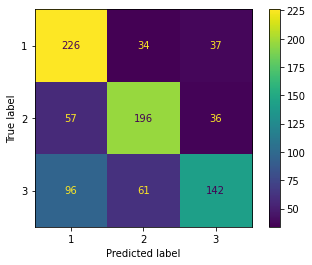


#### results for lowest loss model ####
Accuracy of: 0.6373


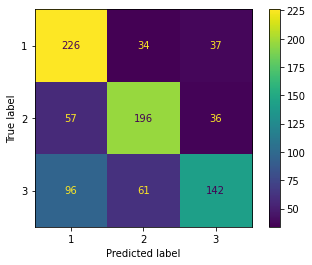


####################################################
# RESULTS FOR SUBJECT C
####################################################

#### results of training ####
Best training accuracy (max) 0.8444 @ epoch 926
Best training loss (min) 0.5307 @ epoch 1812

Best validation accuracy (max) 0.7667 @ epoch 304
Best validation loss (min) 0.6773 @ epoch 2486

#### results for highest accuracy model ####
Accuracy of: 0.6233


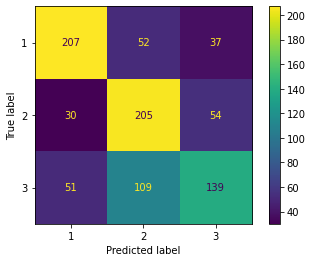


#### results for lowest loss model ####
Accuracy of: 0.6188


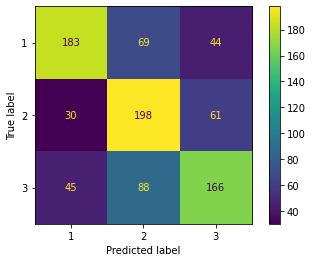


####################################################
# RESULTS FOR SUBJECT E
####################################################

#### results of training ####
Best training accuracy (max) 0.9333 @ epoch 1717
Best training loss (min) 0.3463 @ epoch 2386

Best validation accuracy (max) 0.7333 @ epoch 85
Best validation loss (min) 0.6853 @ epoch 2374

#### results for highest accuracy model ####
Accuracy of: 0.6432


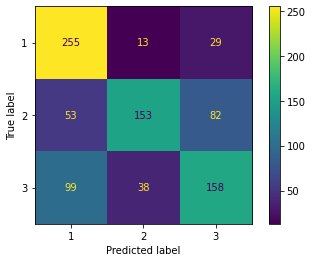


#### results for lowest loss model ####
Accuracy of: 0.6602


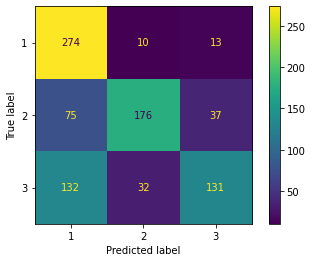

In [11]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/8/calibration/EEGNet/newsubject/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the test labels
        with open(f"saved_variables/8/calibration/EEGNet/newsubject/subject{subject_id}/y_test.pickle", 'rb') as f:
            y_test = pickle.load(f)
            
        # Get the test data
        with open(f"saved_variables/8/calibration/EEGNet/newsubject/subject{subject_id}/X_test.pickle", 'rb') as f:
            X_test = pickle.load(f)
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/4/newsubject/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/8/calibration/EEGNet/newsubject/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Inverse y_test to label
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset

<hr><hr>

## Subsampling electrodes

According to Kaya et al., the authors of the used dataset, the channels of most interest are C3, C4, T3, T4 and Cz.

